In [22]:
import fulu
import pandas as pd
from fulu import single_layer_aug
from fulu import bnn_aug
from fulu import nf_aug
from fulu import mlp_reg_aug
from fulu import gp_aug
import numpy as np
import utils
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
from sklearn.gaussian_process.kernels import RBF, Matern, \
RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel as C
import os
import time
from binned_split import binned_train_test_split
from joblib import Parallel, delayed
from copy import deepcopy
from scipy.optimize import minimize


np.random.seed(0)

diff_between_format_bts_and_mjd = 2458000 - 2400000.5
path = os.getcwd()
path_to = "{}/ZTF_BTS_23_29__22_09_2021.csv".format(os.getcwd())
color = {1: 'red', 0: 'green'}
passband2lam  = {0: 1, 1: 2} # green, red 
# models_dict = {'BNN': bnn_aug.BayesianNetAugmentation(passband2lam),
#                'NF': nf_aug.NormalizingFlowAugmentation(passband2lam),
#                'NN (pytorch)': single_layer_aug.SingleLayerNetAugmentation(passband2lam),
#                'NN (sklearn)': mlp_reg_aug.MLPRegressionAugmentation(passband2lam),
#                'GP': gp_aug.GaussianProcessesAugmentation(passband2lam),
#                'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()),
#                'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()), 'GP with err': gp_aug.GaussianProcessesAugmentation(passband2lam, use_err = True), 'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(), use_err = True),
#                'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel(), use_err = True)}

calculate_mjd = lambda x: x + diff_between_format_bts_and_mjd


bts = pd.read_csv(path_to, sep =',')
bts = bts.drop('Unnamed: 0', 1) 

df_all = pd.read_csv(path + '/ANTARES_NEW.csv')
#df_all = pd.read_csv(path + '/ANTARES_NEW_10_in_g_r_bands.csv')
df_all = df_all.drop('Unnamed: 0', 1)

#print("Названия колонок в таблице ANTARES.csv со всеми кривыми блеска: \n\n", df_all.columns, "\n\n")
print("Количество объектов: ", len(df_all['object_id'].unique()))

obj_names = df_all['object_id'].unique()
# df_all.loc[df_all.obj_type == 'SN Ia', 'obj_type'] = 1
# df_all.loc[df_all.obj_type != 1, 'obj_type'] = 0


# CUR = np.inf
# CUR_p = []
# CUR_std = 0
def get_object(df, name_in_BTSdf):
    """df - csv with all obj"""
    assert isinstance(name_in_BTSdf, str), 'Попробуйте ввести название объекта из ZTF'
    if name_in_BTSdf[:2] == 'ZT':
        df_num = df[df.object_id == name_in_BTSdf]
        return df_num
    else:
        return None

def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

def bootstrap_estimate_mean_stddev(arr, n_samples=10000):
    arr = np.array(arr)
    np.random.seed(0)
    bs_samples = np.random.randint(0, len(arr), size=(n_samples, len(arr)))
    bs_samples = arr[bs_samples].mean(axis=1)
    sigma = np.sqrt(np.sum((bs_samples - bs_samples.mean())**2) / (n_samples - 1))
    return np.mean(bs_samples), sigma

def gen_report(metrics, silent=False):
    report = pd.DataFrame(columns=["ID",
                                   'RMSE',
                                   'MAE',
                                   'RSE',
                                   'RAE',
                                   'MAPE',
                                   'NLPD',
                                   'NRMSEO',
                                   'NRMSEP',
                                   'PICP_68',
                                   'PICP_95',
                                   'C',
                                   't'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
#     n_failed = report[report.MAE == -999].shape[0]
#     if not silent: print("Num. of failed curves: ", n_failed)
#     report = report[report.MAE != -999]
    return report


def aug_one(model, name):
    #print(name)
    anobject = get_object(df_all, name)
    t = anobject['mjd'].values
    try:
        anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                            t=t, 
                                                            bin_size=5, 
                                                            test_size=2, 
                                                            shuffle=True, 
                                                            random_state=42, 
                                                            bounds_in_train=True)
    except:
        #print('here')
        return [np.nan]*12   
    
    start_time_moment =  time.time()

    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values,
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_test_pred, flux_err_test_pred =\
    model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

    end_time_moment =  time.time()
    time_of_work = end_time_moment - start_time_moment
    flux_test = anobject_test['flux'].values
    flux_err_test = anobject_test['flux_err'].values

    metrics = utils.regression_quality_metrics_report(flux_test,
                                                      flux_test_pred,
                                                      flux_err_test,
                                                      flux_err_test_pred)
    metrics.append(0)
    metrics.append(time_of_work)
    #print(metrics)
    return metrics 
    
    

def aug_mlp(x_params):#, CUR=CUR, CUR_p=CUR_p, CUR_std=CUR_std):#, model_name = 'NN (pytorch)'):
    
    #model = models_dict[model_name]
    params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),#(np.int(np.round(x_params[0])), np.int(np.round(x_params[1]))),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': x_params[0],
                              'max_iter': 90, #np.int(np.round(x_params[3])),
                              'batch_size': 1, #np.int(np.round(x_params[4])), 
                              'weight_decay': x_params[1]}
    
    model = mlp_reg_aug.MLPRegressionAugmentation(**params)
    #print(model)
    #print(model_name)
    
    
    metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)
    #print(metrics)
    #print("code worked")
    report = gen_report(metrics)   
    
    #print("На train_test_split упало {} объектов".format(np.sum(np.isnan(report['C'].values))))
    report = report.dropna()
#     for i in tqdm(report.columns[1:].values):
#         mean, std = bootstrap_estimate_mean_stddev(report[i].values)
#         print('Среднее значение метрики ' + i + ' {}'.format(mean), 
#               "+-", std)
    opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)
#     print(CUR)
#     if opt_bot < CUR:
#         #print('here')
#         CUR = opt_bot
#         CUR_p = x_params
#         CUR_std = std_bot
    opt = np.mean(report['MAPE'].values)
    print(opt, opt_bot, " +- ", std_bot)
    #print()
    print(x_params)
    #print("Best state now  ", CUR, CUR_std, CUR_p)
    return opt_bot

Количество объектов:  1870


In [5]:
np.int(1.0)

1

In [2]:
models_dict = {'BNN': bnn_aug.BayesianNetAugmentation(**params),
               'NF': nf_aug.NormalizingFlowAugmentation(**params_nf),
               'NN (pytorch)': single_layer_aug.SingleLayerNetAugmentation(**params_pt),
               'NN (sklearn)': mlp_reg_aug.MLPRegressionAugmentation(**params_sk),
               'GP': gp_aug.GaussianProcessesAugmentation(passband2lam),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()),
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()),
               'GP C(1.0) * Matern([1, 1]) + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0) * Matern([1, 1]) + WhiteKernel()),
               'GP with err': gp_aug.GaussianProcessesAugmentation(passband2lam, use_err = True),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(), use_err = True),
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel(), use_err = True),
              'GP C(1.0) * Matern([1, 1]) + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0) * Matern([1, 1]) + WhiteKernel(), use_err = True)}

NameError: name 'params' is not defined

# MLP sklearn optimization

In [6]:
%%time


from scipy.optimize import minimize#, rosen, rosen_der


x0 = [20, 10, 0.001, 90, 1, 0.0001]
#bounds = [(10, 30), (10, 30), (0.0001, 0.01), (50, 1000), (1, 500), (0.00001, 0.1)]
#aug_mlp(x0)
res = minimize(aug_mlp, x0, method='L-BFGS-B')#, method='L-BFGS-B', bounds=bounds, tol=0.00001)#, method='L-BFGS-B')

code worked
11.871407811375878
code worked
11.982566262751167
code worked
12.03180135897977
code worked
12.142355007937223
code worked
12.372755702921202
code worked
11.998073612294476
code worked
11.858260828481557
code worked
9.836314166634446
code worked
10.053931248820337
code worked
10.01025690467314
code worked
9.941724639577403
code worked
9.861252303663736
code worked
9.715032339718066
code worked
10.241127051476981
code worked
10.3618839335668
code worked
10.441984776120924
code worked
10.518412407040074
code worked
10.562364069929968
code worked
10.313114366999894
code worked
10.494503034175773
code worked
10.523945064276475
code worked
11.009089802169767
code worked
11.241290359347621
code worked
11.114311004874121
code worked
10.883168577005597
code worked
10.963056290458955
code worked
11.158118209209986
code worked
11.121371350478643
code worked
11.208362543755431
code worked
11.735107917226905
code worked
11.80439326903921
code worked
11.400215539566407
code worked
11.62

In [12]:
res

      fun: 11.954050455307101
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6840861.85130118, -13287113.30056239,  18803761.81814872,
         2323552.24851923,  17708864.3570662 ,  22008740.01636922])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 175
      nit: 2
     njev: 25
   status: 0
  success: True
        x: array([2.00000000e+01, 1.00000000e+01, 9.99999216e-04, 9.00000000e+01,
       1.00000000e+00, 1.00000038e-04])

In [26]:
%%time


x0 = [20, 10, 0.001, 90, 1, 0.0001]

res1 = minimize(aug_mlp, x0)#, method='L-BFGS-B')

12.273756675103314 12.275273948595773  +-  0.33816148718359373
[2.e+01 1.e+01 1.e-03 9.e+01 1.e+00 1.e-04]
12.445407164799107 12.440244788593782  +-  0.5421163392605102
[2.e+01 1.e+01 1.e-03 9.e+01 1.e+00 1.e-04]
11.938479724375398 11.941938767351566  +-  0.2910376526204332
[2.e+01 1.e+01 1.e-03 9.e+01 1.e+00 1.e-04]
12.044201265068107 12.04873794026859  +-  0.2893450689464979
[2.0000000e+01 1.0000000e+01 1.0000149e-03 9.0000000e+01 1.0000000e+00
 1.0000000e-04]
12.395430791361656 12.400111528470857  +-  0.3363439259669427
[2.e+01 1.e+01 1.e-03 9.e+01 1.e+00 1.e-04]
12.363079864299626 12.36447726565019  +-  0.37318926665940827
[2.00000000e+01 1.00000000e+01 1.00000000e-03 9.00000000e+01
 1.00000001e+00 1.00000000e-04]
11.9023071871744 11.90245688304943  +-  0.3366469641261589
[2.00000000e+01 1.00000000e+01 1.00000000e-03 9.00000000e+01
 1.00000000e+00 1.00014901e-04]
15.938712665863862 15.933067877626375  +-  0.37895303012239945
[19.7192331  10.56730926  0.38654579 89.78753663  0.84818

11.73776717175545 11.740993261001782  +-  0.3320187078515077
[1.99997823e+01 1.00004398e+01 1.29891591e-03 8.99998353e+01
 9.99882296e-01 5.91934820e-04]
11.747878008615158 11.749663332109984  +-  0.28894086172156075
[1.99997823e+01 1.00004398e+01 1.29891591e-03 8.99998353e+01
 9.99882296e-01 5.91934820e-04]
11.576247432011723 11.577453140975958  +-  0.2825259153350054
[1.99997823e+01 1.00004399e+01 1.29891591e-03 8.99998353e+01
 9.99882296e-01 5.91934820e-04]
11.76001789617878 11.762171751780903  +-  0.3182826339557444
[1.99997823e+01 1.00004398e+01 1.29893081e-03 8.99998353e+01
 9.99882296e-01 5.91934820e-04]
11.537663264972672 11.538430836407747  +-  0.2724830509400913
[1.99997823e+01 1.00004398e+01 1.29891591e-03 8.99998353e+01
 9.99882296e-01 5.91934820e-04]
11.935680326179805 11.93696992853878  +-  0.32623366120220415
[1.99997823e+01 1.00004398e+01 1.29891591e-03 8.99998353e+01
 9.99882310e-01 5.91934820e-04]
11.787063615493219 11.7934102233812  +-  0.3444800240861703
[1.99997823

12.357667707468579 12.356297434213907  +-  0.3705795866862258
[1.99999987e+01 1.00000026e+01 1.00177571e-03 8.99999990e+01
 9.99999301e-01 1.02923190e-04]
11.902096535677654 11.90477996556834  +-  0.2858802683552173
[1.99999987e+01 1.00000026e+01 1.00177571e-03 8.99999990e+01
 9.99999316e-01 1.02923190e-04]
11.764889221854423 11.763935697882035  +-  0.326191893767017
[1.99999987e+01 1.00000026e+01 1.00177571e-03 8.99999990e+01
 9.99999301e-01 1.02938092e-04]
11.943291359569102 11.947236924926289  +-  0.28873124246156634
[1.99999987e+01 1.00000026e+01 1.00177587e-03 8.99999990e+01
 9.99999301e-01 1.02922613e-04]
12.011171275793242 12.013336259104259  +-  0.3224166519100228
[1.99999987e+01 1.00000026e+01 1.00177587e-03 8.99999990e+01
 9.99999301e-01 1.02922613e-04]
12.125998117116069 12.124587719043399  +-  0.3743605874307485
[1.99999987e+01 1.00000026e+01 1.00177587e-03 8.99999990e+01
 9.99999301e-01 1.02922613e-04]
12.141489676908844 12.143508007007123  +-  0.36447581019073677
[1.99999

11.92672823309444 11.925023821453319  +-  0.3466653316080797
[1.99999987e+01 1.00000026e+01 1.00179068e-03 8.99999990e+01
 9.99999301e-01 1.02922933e-04]
12.087538546924094 12.087561276391735  +-  0.3457420087486851
[1.99999987e+01 1.00000026e+01 1.00177578e-03 8.99999990e+01
 9.99999301e-01 1.02922933e-04]
11.782051790843493 11.78339366703812  +-  0.2987895981211714
[1.99999987e+01 1.00000026e+01 1.00177578e-03 8.99999990e+01
 9.99999316e-01 1.02922933e-04]
12.16412226166365 12.164501016164888  +-  0.31421749817107136
[1.99999987e+01 1.00000026e+01 1.00177578e-03 8.99999990e+01
 9.99999301e-01 1.02937835e-04]
12.147000021793046 12.14910660661455  +-  0.31610641461338784
[1.99999987e+01 1.00000026e+01 1.00177579e-03 8.99999990e+01
 9.99999301e-01 1.02922887e-04]
12.277523735305182 12.279703702930624  +-  0.32015125758943613
[1.99999987e+01 1.00000026e+01 1.00177579e-03 8.99999990e+01
 9.99999301e-01 1.02922887e-04]
12.09207390062236 12.09556159898739  +-  0.3263394184092352
[1.99999987

In [27]:
res1 #[1.99669311e+01 1.00668180e+01 4.64097660e-02 8.99749760e+01
 #9.82118950e-01 7.48322063e-02]
    #9.838892351823896 9.837563148767785  +-  0.22494342305102297
#[1.99889975e+01 1.00222313e+01 1.61084963e-02 8.99916741e+01
 #9.94050718e-01 2.49644785e-02]

      fun: 11.614713044770415
 hess_inv: array([[ 3.81633434,  1.44429436,  1.79242171,  1.90861119, -1.0229777 ,
        -4.53557542],
       [ 1.44429436,  1.15855642,  0.45529625,  1.00087219, -0.27098659,
        -2.43205474],
       [ 1.79242171,  0.45529625,  1.7693048 ,  1.23553502, -0.41122966,
        -2.93572231],
       [ 1.90861119,  1.00087219,  1.23553502,  2.28670524, -0.77202412,
        -3.1346654 ],
       [-1.0229777 , -0.27098659, -0.41122966, -0.77202412,  0.4523083 ,
         0.9337745 ],
       [-4.53557542, -2.43205474, -2.93572231, -3.1346654 ,  0.9337745 ,
         7.5710048 ]])
      jac: array([19963035.28795731, 27115826.45019495, 24117065.95114863,
       16626647.14622927, 29122754.77220321, 12012312.87950408])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 199
      nit: 2
     njev: 26
   status: 2
  success: False
        x: array([1.99999987e+01, 1.00000026e+01, 1.00177579e-03, 8.99999990e+01,
       9.99999301e-

In [33]:
%%time


x0 = [0.001, 0.0001]
bd = ((0, 0.1),(0, 0.1))
res2 = minimize(aug_mlp, x0, bounds=bd) #, method='L-BFGS-B')
print(res2)

12.521883796619594 12.524490799487943  +-  0.3443949053683437
[0.001  0.0001]
11.821883666182655 11.824427065116808  +-  0.2830282458921482
[0.00100001 0.0001    ]
12.007629425288552 12.010650238301746  +-  0.299671633455625
[0.001      0.00010001]
10.05409742937427 10.05230393282202  +-  0.22099363978211137
[0.1 0.1]
10.161263707815314 10.160339924244603  +-  0.22802546362755544
[0.09999999 0.1       ]
10.116969878518404 10.1152653818468  +-  0.2289452122563576
[0.1        0.09999999]
9.974836711680025 9.974037791752602  +-  0.25693108593588826
[0.03171744 0.03109669]
9.857154880045126 9.855333876765615  +-  0.24242399475586282
[0.03171745 0.03109669]
9.998315741165007 9.998851622366356  +-  0.26832036500102086
[0.03171744 0.0310967 ]
10.353421257485111 10.353292013758974  +-  0.2592592311764683
[0.01083872 0.01002817]
10.135642256124722 10.13526329129678  +-  0.23505099566460907
[0.01083873 0.01002817]
10.27429973532467 10.275476908745732  +-  0.23472316385900152
[0.01083872 0.010028

12.25798701350654 12.256382682194058  +-  0.34759360574608716
[0.00100099 0.00010156]
11.988063974765568 11.990653754423972  +-  0.3334719497928253
[0.001001   0.00010156]
12.210088203328635 12.212241523203256  +-  0.3080614586470145
[0.00100099 0.00010157]
11.873294070318085 11.874908485352309  +-  0.27223366651336656
[0.00100099 0.00010196]
12.131554508057414 12.132767129943216  +-  0.30797037817878326
[0.001001   0.00010196]
11.799784393964424 11.80383966113576  +-  0.29532817175470494
[0.00100099 0.00010197]
11.97427759620018 11.97552140711628  +-  0.31040163396953074
[0.00100099 0.000102  ]
12.099777418776526 12.103264922729037  +-  0.32086084776013585
[0.001001 0.000102]
12.130239045869104 12.133766763506273  +-  0.30220167378950236
[0.00100099 0.00010201]
12.26470944126966 12.267649786225139  +-  0.35402377560044845
[0.00100099 0.00010198]
12.24819086093199 12.252537972691336  +-  0.3256939152329289
[0.001001   0.00010198]
12.54820766756077 12.550930468335519  +-  0.346687550755

In [ ]:
9.857154880045126 9.855333876765615  +-  0.24242399475586282
[0.03171745 0.03109669]

In [4]:
#best params from process of optimization
params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': 0.03171745,
                              'max_iter': 90, 
                              'batch_size': 1, 
                              'weight_decay': 0.03109669}
    
model = mlp_reg_aug.MLPRegressionAugmentation(**params)


metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

report = gen_report(metrics)   

#print("На train_test_split упало {} объектов".format(np.sum(np.isnan(report['C'].values))))
report = report.dropna()
for i in tqdm(report.columns[1:].values):
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)
    

  8%|▊         | 1/12 [00:01<00:11,  1.02s/it]

Среднее значение метрики RMSE 0.01837700296952252 +- 0.0012159684328202096


 17%|█▋        | 2/12 [00:02<00:10,  1.01s/it]

Среднее значение метрики MAE 0.015099386898390051 +- 0.0010211511794958232


 25%|██▌       | 3/12 [00:03<00:09,  1.02s/it]

Среднее значение метрики RSE 0.6635226655201915 +- 0.05043153038544747


 33%|███▎      | 4/12 [00:04<00:08,  1.02s/it]

Среднее значение метрики RAE 0.6472752682692176 +- 0.04953145381971025


 42%|████▏     | 5/12 [00:05<00:07,  1.01s/it]

Среднее значение метрики MAPE 9.934280098443516 +- 0.23190948566343697


 50%|█████     | 6/12 [00:06<00:06,  1.01s/it]

Среднее значение метрики NLPD 3.391451958279392 +- 0.6130064460310284


 58%|█████▊    | 7/12 [00:07<00:05,  1.01s/it]

Среднее значение метрики NRMSEO 1.0746718118772554 +- 0.026353398722190332


 67%|██████▋   | 8/12 [00:08<00:04,  1.01s/it]

Среднее значение метрики NRMSEP 2.636345883225947 +- 0.06628331286296568


 75%|███████▌  | 9/12 [00:09<00:03,  1.01s/it]

Среднее значение метрики PICP_68 0.45726800642845655 +- 0.006899146058686542


 83%|████████▎ | 10/12 [00:10<00:02,  1.00s/it]

Среднее значение метрики PICP_95 0.6803487950766914 +- 0.00679749183417175


 92%|█████████▏| 11/12 [00:10<00:00,  1.23it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

Среднее значение метрики t 0.02993478951555265 +- 0.00011562110710381365


In [8]:
res.x

array([2.00000007e+01, 1.00000072e+01, 1.01061829e-03, 9.00000061e+01,
       1.00000484e+00, 1.02126348e-04])

In [10]:
res

      fun: 11.756365099340492
 hess_inv: array([[ 0.0069212 , -0.05833543,  0.04745442,  0.01721841, -0.03206749,
         0.01046946],
       [-0.05833543,  0.7073405 , -0.39682674, -0.25522472, -0.07384532,
         0.12147593],
       [ 0.04745442, -0.39682674,  0.32542058,  0.11644541, -0.22493771,
         0.07487701],
       [ 0.01721841, -0.25522472,  0.11644541,  0.09904751,  0.09594327,
        -0.08104453],
       [-0.03206749, -0.07384532, -0.22493771,  0.09594327,  0.69802854,
        -0.38338084],
       [ 0.01046946,  0.12147593,  0.07487701, -0.08104453, -0.38338084,
         0.21993325]])
      jac: array([ 4996225.77276194, 21993982.69443989, 21490332.34978712,
       21666078.00527275, 18967358.23158395, 24519336.11134958])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 273
      nit: 4
     njev: 36
   status: 2
  success: False
        x: array([2.00000007e+01, 1.00000072e+01, 1.01061829e-03, 9.00000061e+01,
       1.00000484e+

In [ ]:
%%time

from scipy.optimize import brute, fmin


ranges = [slice(10, 30), 
          slice(10, 30), 
          slice(0.0001, 0.01), 
          slice(50, 1000), 
          slice(1, 500), 
          slice(0.00001, 0.1)]

brute = brute(aug_mlp, ranges, full_output=True, finish=fmin)

code worked
11.963367666665558
code worked
12.183155770344886
code worked
12.341461178023506
code worked
11.853039429925436
code worked
12.385000373264942
code worked
12.239627929231084
code worked
12.112334218687371
code worked
12.143978914589887
code worked
12.267764499850749
code worked
12.38751551092837
code worked
11.765058219860691
code worked
12.069792801904587
code worked
12.219408406796909
code worked
12.167795118620948
code worked
12.287503972475395
code worked
12.167496880523199
code worked
12.197204662364559
code worked
12.221897909884728
code worked
12.228065742706052
code worked
12.454854510586014
code worked
12.132427078575244
code worked
12.066319676639006
code worked
12.033386651030053
code worked
12.119646683358349
code worked
12.161337258999744
code worked
12.189166457130506
code worked
12.37690734661376
code worked
12.354909583483883
code worked
12.178055407612332
code worked
12.26275461927343
code worked
12.42173520450082
code worked
12.176296316638838
code worked


code worked
12.231737345530703
code worked
12.491428819763325
code worked
11.873586226540521
code worked
12.227360537707002
code worked
12.155529898231093
code worked
12.051765802916307
code worked
12.50838317109008
code worked
11.9872684181655
code worked
11.800802082070447
code worked
12.521808012913514
code worked
12.153891348158476
code worked
12.125144204517806
code worked
12.09298762867607
code worked
11.874927276319127
code worked
12.13370058575499
code worked
12.215711783691878
code worked
12.255036809797017
code worked
12.05601344357892
code worked
12.195116788485999
code worked
12.318822727218281
code worked
12.013482018009617
code worked
12.192682402216997
code worked
12.146967908329504
code worked
12.296778906293286
code worked
12.021353635564411
code worked
12.515620069690126
code worked
12.471045638382769
code worked
12.125329245249509
code worked
12.13676686208196
code worked
12.085898796293016
code worked
11.98050079178483
code worked
11.86074192323139
code worked
12.33

12.112127028605403
code worked
12.050811671254516
code worked
11.913517272847612
code worked
12.443239106437469
code worked
12.084560012697313
code worked
12.255221851825551
code worked
12.377594920431084
code worked
11.997263361335767
code worked
12.089159065145328
code worked
12.426795815558824
code worked
11.999672424286736
code worked
12.291534664715597
code worked
12.167027308378566
code worked
12.176226360933866
code worked
12.248983178729787
code worked
12.376636087585082
code worked
12.015883933078062
code worked
11.824657669823532
code worked
12.193515032427031
code worked
12.232959870349886
code worked
12.02207252876355
code worked
12.436600369760638
code worked
12.232444825300288
code worked
11.760622272348897
code worked
12.089385007586525
code worked
12.179951758486935
code worked
12.290069139977215
code worked
12.085824478495429
code worked
12.125333279263298
code worked
12.156179553532105
code worked
12.124411307184534
code worked
12.399146083079021
code worked
12.557760

11.937988612809955
code worked
11.987895364435877
code worked
11.950095793427462
code worked
12.251318765534746
code worked
12.331807729545956
code worked
12.471589396610772
code worked
12.071317925457578
code worked
12.357295422627365
code worked
12.659186806842792
code worked
12.056788997618773
code worked
12.087741400605061
code worked
11.70025684774838
code worked
12.191116289519968
code worked
12.348442699756793
code worked
12.281646526371132
code worked
11.953360635707782
code worked
11.992594423499135
code worked
12.056328902811792
code worked
11.910089103705909
code worked
12.12775833586863
code worked
12.286207964121711
code worked
12.257238870573296
code worked
12.07294339754473
code worked
12.102671499875104
code worked
11.887093261980732
code worked
12.08109285564819
code worked
12.204650199329768
code worked
12.217304850417648
code worked
12.226652917612094
code worked
12.05200564499343
code worked
12.11695186852842
code worked
11.814970962148681
code worked
12.25175957543

In [10]:
xs = [[20, 10, 0.001, 90, 1, 0.0001], [20, 20, 0.001, 900, 1, 0.001]]
for x0 in xs:

    aug_mlp(x0)

code worked
12.214495267623304
code worked
12.366985221361523


# NF optimization

In [2]:
def aug_nf(x_params):
    

    params = {'passband2lam': passband2lam, 
                              'batch_size': 500, 
                              'n_epochs': 3000, 
                              'lr': x_params[0], 
                              'device': 'cpu', 
                              'weight_decay': x_params[1]}
#     params = {'passband2lam': passband2lam, 
#           'batch_size': 500, 
#           'n_epochs': 1000, 
#           'lr': 0.01, 
#           'device': 'cpu', 
#           'weight_decay': 0.01}
    
    
    
    model = nf_aug.NormalizingFlowAugmentation(**params)

    
    
    metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

    report = gen_report(metrics)   
    

    report = report.dropna()

    opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)

    opt = np.mean(report['MAPE'].values)
    print(opt, opt_bot, " +- ", std_bot)

    print(x_params)
    
    return opt_bot

In [7]:
%%time

x0 = [0.005, 0]
bd = ((0.0001, 0.1),(0, 0.1))
res_nf = minimize(aug_nf, x0, bounds=bd)

10.450567449575763 10.451447453721116  +-  0.22293421669655114
[0.005 0.   ]
10.31515852409661 10.317104719662105  +-  0.21796910279137174
[0.00500001 0.        ]
10.335409007229632 10.33601091518907  +-  0.21287475333882652
[5.e-03 1.e-08]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [9]:
%%time

x0 = [0.005, 0]
bd = ((0.0001, 0.1),(0, 0.1))
res_nf = minimize(aug_nf, x0, bounds=bd)

10.434062616286587 10.435532092352615  +-  0.22225103718419087
[0.005 0.   ]
10.306955022117283 10.308454834936093  +-  0.2125692741071991
[0.00500001 0.        ]
10.401663899372949 10.403040794366827  +-  0.2202147277939889
[5.e-03 1.e-08]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [10]:
aug_nf([0.005, 0.05])

14.42856847481634 14.425941883056925  +-  0.40479202970422706
[0.005, 0.05]


14.425941883056925

In [8]:
aug_nf([0.05, 0.05])

3.942240043836565e+26 3.9310219855055554e+26  +-  2.3603525265327226e+26
[0.05, 0.05]


3.9310219855055554e+26

In [ ]:
# params = {'passband2lam': passband2lam, 
#           'batch_size': 500, 
#           'n_epochs': 1000, 
#           'lr': 0.01, 
#           'device': 'cpu', 
#           'weight_decay': 0.01}

In [12]:
aug_nf()

12.667621596857408 12.667813813843702  +-  0.2600659216661848


NameError: name 'x_params' is not defined

In [3]:
aug_nf([0.005, 0.01])

11.492082864175162 11.490004398543004  +-  0.2871360927081238
[0.005, 0.01]


11.490004398543004

In [40]:
res_nf

NameError: name 'res_nf' is not defined

In [3]:
params = {'passband2lam': passband2lam, 
                              'batch_size': 500, 
                              'n_epochs': 3000, 
                              'lr': 0.00500001, 
                              'device': 'cpu', 
                              'weight_decay': 0.}
    
    
    
model = nf_aug.NormalizingFlowAugmentation(**params)



metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

report = gen_report(metrics)   


report = report.dropna()

for i in tqdm(report.columns[1:].values):
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)

  8%|▊         | 1/12 [00:01<00:11,  1.01s/it]

Среднее значение метрики RMSE 0.02124698166953946 +- 0.001866175225408513


 17%|█▋        | 2/12 [00:01<00:09,  1.03it/s]

Среднее значение метрики MAE 0.017056689760752225 +- 0.0013949878455342712


 25%|██▌       | 3/12 [00:02<00:08,  1.04it/s]

Среднее значение метрики RSE 0.7190226035371227 +- 0.053511752339410065


 33%|███▎      | 4/12 [00:03<00:07,  1.05it/s]

Среднее значение метрики RAE 0.7154714257632068 +- 0.05137292446359726


 42%|████▏     | 5/12 [00:04<00:06,  1.04it/s]

Среднее значение метрики MAPE 10.560219900194198 +- 0.22290819323212424


 50%|█████     | 6/12 [00:05<00:05,  1.05it/s]

Среднее значение метрики NLPD -2.6114889338832974 +- 0.049265808323491325


 58%|█████▊    | 7/12 [00:06<00:04,  1.06it/s]

Среднее значение метрики NRMSEO 1.1921211951988784 +- 0.03292243721812565


 67%|██████▋   | 8/12 [00:07<00:03,  1.05it/s]

Среднее значение метрики NRMSEP 0.8578278061340762 +- 0.017224962734752228


 75%|███████▌  | 9/12 [00:08<00:02,  1.06it/s]

Среднее значение метрики PICP_68 0.7899136340678319 +- 0.005957558966888843


 83%|████████▎ | 10/12 [00:09<00:01,  1.07it/s]

Среднее значение метрики PICP_95 0.9436711116473285 +- 0.0035302071305630283


 92%|█████████▏| 11/12 [00:09<00:00,  1.32it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

Среднее значение метрики t 37.54313461667682 +- 0.08109830514949291


# BNN optimization

In [2]:
def aug_bnn(x_params):
    
    params = {'passband2lam': passband2lam, 
                          'n_hidden': 20, 
                          'prior_sigma': x_params[0], 
                          'n_epochs': 3000, 
                          'lr': x_params[1], 
                          'kl_weight': x_params[2], 
                          'optimizer': 'Adam', 
                          'device': 'cpu', 
                          'weight_decay': x_params[3]}
    
    model = bnn_aug.BayesianNetAugmentation(**params)
    
    metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

    report = gen_report(metrics)   
    
    report = report.dropna()

    opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)

    opt = np.mean(report['MAPE'].values)
    print(opt, opt_bot, " +- ", std_bot)

    print(x_params)

    return opt_bot

In [ ]:
%%time

x0 = [0.1, 0.01, 0.0001, 0]
bd = ((0, 0.15),(0, 0.1), (0, 0.1), (0, 0.1))
res_bnn = minimize(aug_bnn, x0, bounds=bd)

11.264102452902167 11.263921155562745  +-  0.2587837263416379
[0.1    0.01   0.0001 0.    ]
11.260140155639249 11.25936249897568  +-  0.25832105447906173
[1.0000001e-01 1.0000000e-02 1.0000000e-04 0.0000000e+00]
11.45672646307114 11.455197592484005  +-  0.2880475925996962
[0.1        0.01000001 0.0001     0.        ]
11.305450573666109 11.30635963698148  +-  0.2614984791177657
[0.1        0.01       0.00010001 0.        ]
11.311584795890042 11.310318023552185  +-  0.29159732282452194
[1.e-01 1.e-02 1.e-04 1.e-08]
102.29053175220456 102.24837150265797  +-  4.214801743360263
[0.5 0.  0.  0. ]
101.44460915333296 101.41115871918024  +-  4.1935475751584885
[0.49999999 0.         0.         0.        ]
100.12554280596432 100.0806377430039  +-  3.277802767514918
[5.e-01 1.e-08 0.e+00 0.e+00]
103.00970775495874 102.942401966697  +-  4.0802187481075585
[5.e-01 0.e+00 1.e-08 0.e+00]


In [3]:
%%time

x0 = [0.1, 0.01, 0.0001, 0]
bd = ((0, 0.15),(0, 0.1), (0, 0.1), (0, 0.1))
res_bnn = minimize(aug_bnn, x0, bounds=bd)

11.524801081246528 11.525576271546212  +-  0.30512209914303207
[0.1    0.01   0.0001 0.    ]
11.401538924028861 11.403114271078978  +-  0.2788907146586124
[1.0000001e-01 1.0000000e-02 1.0000000e-04 0.0000000e+00]
11.34122847941284 11.34020300254857  +-  0.2790364299378496
[0.1        0.01000001 0.0001     0.        ]
11.487188023053934 11.487587589022144  +-  0.272813982643888
[0.1        0.01       0.00010001 0.        ]
11.363843162591383 11.36199977734089  +-  0.27919582354580313
[1.e-01 1.e-02 1.e-04 1.e-08]
65.6591754148636 65.65878652432554  +-  3.1402703565878736
[0.15 0.1  0.1  0.1 ]
63.873987915729025 63.843786847556125  +-  1.9236855391786356
[0.14999999 0.1        0.1        0.1       ]
66.39463488423227 66.36794028405463  +-  2.067862322420171
[0.15       0.09999999 0.1        0.1       ]
63.93886155848126 63.91346690504992  +-  1.933906055516184
[0.15       0.1        0.09999999 0.1       ]
64.5136097857702 64.50653248421308  +-  2.23783286741096
[0.15       0.1        0.1

11.526278110411667 11.525331383149677  +-  0.32657773187594635
[9.99997512e-02 1.00030679e-02 1.01968431e-04 3.32389892e-06]
11.434639070974493 11.433508358093912  +-  0.29655285382236785
[9.99997512e-02 1.00030579e-02 1.01978431e-04 3.32389892e-06]
11.435725386520316 11.434905865398903  +-  0.27443320971101676
[9.99997512e-02 1.00030579e-02 1.01968431e-04 3.33389892e-06]
11.43127286374666 11.429237726399563  +-  0.285259005012067
[9.99995857e-02 1.00030506e-02 1.01842658e-04 3.29837984e-06]
11.469513301758703 11.46872680549765  +-  0.2729687720910248
[9.99995957e-02 1.00030506e-02 1.01842658e-04 3.29837984e-06]
11.347503908972108 11.347615994210306  +-  0.3171143403745264
[9.99995857e-02 1.00030606e-02 1.01842658e-04 3.29837984e-06]
11.3892929397474 11.388712582374806  +-  0.2750808549587555
[9.99995857e-02 1.00030506e-02 1.01852658e-04 3.29837984e-06]
11.48313975677258 11.481637087035832  +-  0.29149566839959734
[9.99995857e-02 1.00030506e-02 1.01842658e-04 3.30837984e-06]
11.5292990

In [4]:
res_bnn

      fun: 11.449176835058417
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2120985.80505588, -15701781.76086098,   4563730.92233063,
        22662381.60100262])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 95
      nit: 3
     njev: 19
   status: 0
  success: True
        x: array([9.99997512e-02, 1.00030579e-02, 1.01968431e-04, 3.32389892e-06])

In [ ]:
11.188518286703623 11.187347293473765  +-  0.25395154933673875
[9.99997363e-02 1.00030572e-02 1.01967102e-04 3.32160019e-06]

In [4]:
params_opt_bnn = {'passband2lam': passband2lam, 
                          'n_hidden': 20, 
                          'prior_sigma': 9.99997363e-02, 
                          'n_epochs': 3000, 
                          'lr': 1.00030572e-02, 
                          'kl_weight': 1.01967102e-04, 
                          'optimizer': 'Adam', 
                          'device': 'cpu', 
                          'weight_decay': 3.32160019e-06}
    
model = bnn_aug.BayesianNetAugmentation(**params_opt_bnn)

metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

report = gen_report(metrics)   

report = report.dropna()

for i in tqdm(report.columns[1:].values):
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)
    
# opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)

# opt = np.mean(report['MAPE'].values)
# print(opt, opt_bot, " +- ", std_bot)

# print(x_params)

  8%|▊         | 1/12 [00:00<00:10,  1.01it/s]

Среднее значение метрики RMSE 0.021245287788728598 +- 0.0011899404240524449


 17%|█▋        | 2/12 [00:02<00:10,  1.01s/it]

Среднее значение метрики MAE 0.017516983554452283 +- 0.0010035022168499795


 25%|██▌       | 3/12 [00:02<00:08,  1.00it/s]

Среднее значение метрики RSE 0.772572872444034 +- 0.062225902120261245


 33%|███▎      | 4/12 [00:04<00:08,  1.00s/it]

Среднее значение метрики RAE 0.7529285369674013 +- 0.058518457803048186


 42%|████▏     | 5/12 [00:04<00:06,  1.00it/s]

Среднее значение метрики MAPE 11.387837811631233 +- 0.2747849368058799


 50%|█████     | 6/12 [00:05<00:05,  1.01it/s]

Среднее значение метрики NLPD 66.35586887749918 +- 6.083967192981754


 58%|█████▊    | 7/12 [00:06<00:04,  1.02it/s]

Среднее значение метрики NRMSEO 1.2502986431453744 +- 0.031024679043170057


 67%|██████▋   | 8/12 [00:07<00:03,  1.02it/s]

Среднее значение метрики NRMSEP 7.8882062241207604 +- 0.20873281773546215


 75%|███████▌  | 9/12 [00:08<00:02,  1.02it/s]

Среднее значение метрики PICP_68 0.19673881424241824 +- 0.005085614684463724


 83%|████████▎ | 10/12 [00:09<00:01,  1.03it/s]

Среднее значение метрики PICP_95 0.35362015846484485 +- 0.006757849714277731


 92%|█████████▏| 11/12 [00:10<00:00,  1.27it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

Среднее значение метрики t 9.937263179579377 +- 0.05181434858384439


# MLP pytorch optimization

In [16]:
def aug_pt(x_params):
    
    params = {'passband2lam': passband2lam, 
                          'n_hidden': 20, 
                          'activation': 'tanh', 
                          'n_epochs': 1000, 
                          'batch_size': 500, 
                          'lr': x_params[0], 
                          'optimizer': 'Adam', 
                          'device': 'auto', 
                          'weight_decay': x_params[1]}
    
    model = single_layer_aug.SingleLayerNetAugmentation(**params)
    
    metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

    report = gen_report(metrics)   
    
    report = report.dropna()

    opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)

    opt = np.mean(report['MAPE'].values)
    print(opt, opt_bot, " +- ", std_bot)

    print(x_params)

    return opt_bot


In [17]:
%%time


x0 = [0.01, 0]
bd = ((0, 0.1),(0, 0.1))
res_pt = minimize(aug_pt, x0, bounds=bd) #, method='L-BFGS-B')
print(res_pt)

10.958079862838817 10.96110146885602  +-  0.2997664848838041
[0.01 0.  ]
10.963802895469314 10.963650894818755  +-  0.2943275243851515
[0.01000001 0.        ]
10.838825940032072 10.839300274052315  +-  0.2738168916555621
[1.e-02 1.e-08]
98.98787903716526 98.92159145650723  +-  3.900449514120798
[0.  0.1]
100.9901413910827 100.93503827799167  +-  3.86711360446131
[1.e-08 1.e-01]
102.0475726177272 102.00825489545424  +-  4.772256783032624
[0.         0.09999999]
11.126236006182824 11.12596612025457  +-  0.2755376222046663
[0.00982267 0.00177333]
11.187117684103152 11.187613979584448  +-  0.2754462334167889
[0.00982268 0.00177333]
10.981872620480717 10.982119552478812  +-  0.25620241030559326
[0.00982267 0.00177334]
10.582429852771158 10.582849747020907  +-  0.2734932784604823
[0.00996565 0.00034348]
10.68282192305289 10.68502378516452  +-  0.29139054413765836
[0.00996566 0.00034348]
10.54555324014033 10.54564237778278  +-  0.25607605104648085
[0.00996565 0.00034349]
10.80574582113882 10.

In [ ]:
#10.582429852771158 10.582849747020907  +-  0.2734932784604823
#[0.00996565 0.00034348]

10.54555324014033 10.54564237778278  +-  0.25607605104648085
[0.00996565 0.00034349]

In [18]:
# parameters from minimal mape in process of minimization
params = {'passband2lam': passband2lam, 
                      'n_hidden': 20, 
                      'activation': 'tanh', 
                      'n_epochs': 1000, 
                      'batch_size': 500, 
                      'lr': 0.00996565, 
                      'optimizer': 'Adam', 
                      'device': 'auto', 
                      'weight_decay': 0.00034349}

model = single_layer_aug.SingleLayerNetAugmentation(**params)

metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

report = gen_report(metrics)   

report = report.dropna()

# opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)

# opt = np.mean(report['MAPE'].values)
# print(opt, opt_bot, " +- ", std_bot)

for i in tqdm(report.columns[1:].values):
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)




  8%|▊         | 1/12 [00:01<00:17,  1.59s/it]

Среднее значение метрики RMSE 0.01881856846006276 +- 0.0010250057609399689


 17%|█▋        | 2/12 [00:02<00:14,  1.44s/it]

Среднее значение метрики MAE 0.015353266852806554 +- 0.0008527676653949469


 25%|██▌       | 3/12 [00:04<00:12,  1.38s/it]

Среднее значение метрики RSE 0.6802557692073025 +- 0.05007035978260015


 33%|███▎      | 4/12 [00:05<00:10,  1.37s/it]

Среднее значение метрики RAE 0.6620931596456127 +- 0.049198321146471484


 42%|████▏     | 5/12 [00:06<00:09,  1.35s/it]

Среднее значение метрики MAPE 10.427840742792357 +- 0.2683958251942478


 50%|█████     | 6/12 [00:08<00:07,  1.33s/it]

Среднее значение метрики NLPD 7.98384258018438 +- 1.9087862396561086


 58%|█████▊    | 7/12 [00:09<00:06,  1.31s/it]

Среднее значение метрики NRMSEO 1.1311920529142565 +- 0.028975821995809132


 67%|██████▋   | 8/12 [00:10<00:05,  1.29s/it]

Среднее значение метрики NRMSEP 2.987848541585268 +- 0.09127581280986236


 75%|███████▌  | 9/12 [00:11<00:03,  1.27s/it]

Среднее значение метрики PICP_68 0.4469930076248238 +- 0.007125640637982284


 83%|████████▎ | 10/12 [00:13<00:02,  1.29s/it]

Среднее значение метрики PICP_95 0.6580569788674331 +- 0.007199416943315949


 92%|█████████▏| 11/12 [00:13<00:01,  1.06s/it]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]

Среднее значение метрики t 2.1303213881898797 +- 0.019562248450562307


In [2]:
#[9.99999824e-03, 7.94665906e-09] #parameters from final of scipy

params = {'passband2lam': passband2lam, 
                      'n_hidden': 20, 
                      'activation': 'tanh', 
                      'n_epochs': 1000, 
                      'batch_size': 500, 
                      'lr': 9.99999824e-03, 
                      'optimizer': 'Adam', 
                      'device': 'auto', 
                      'weight_decay': 7.94665906e-09}

model = single_layer_aug.SingleLayerNetAugmentation(**params)

metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

report = gen_report(metrics)   

report = report.dropna()


for i in tqdm(report.columns[1:].values):
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)

  8%|▊         | 1/12 [00:01<00:13,  1.24s/it]

Среднее значение метрики RMSE 0.01809062906861821 +- 0.0009615392137845786


 17%|█▋        | 2/12 [00:02<00:12,  1.23s/it]

Среднее значение метрики MAE 0.014568758153788719 +- 0.0007698272284220167


 25%|██▌       | 3/12 [00:03<00:11,  1.23s/it]

Среднее значение метрики RSE 0.6964136430074324 +- 0.048907478372909874


 33%|███▎      | 4/12 [00:04<00:09,  1.23s/it]

Среднее значение метрики RAE 0.6800218517319605 +- 0.047909667359909


 42%|████▏     | 5/12 [00:06<00:08,  1.23s/it]

Среднее значение метрики MAPE 10.813860955352318 +- 0.2814103111111994


 50%|█████     | 6/12 [00:07<00:07,  1.22s/it]

Среднее значение метрики NLPD 15.097914232595201 +- 2.29695970912735


 58%|█████▊    | 7/12 [00:08<00:06,  1.21s/it]

Среднее значение метрики NRMSEO 1.1356446981361965 +- 0.028286711566372722


 67%|██████▋   | 8/12 [00:09<00:04,  1.21s/it]

Среднее значение метрики NRMSEP 3.6544942889472973 +- 0.11554926548245653


 75%|███████▌  | 9/12 [00:10<00:03,  1.20s/it]

Среднее значение метрики PICP_68 0.4121712081015208 +- 0.007057360491718021


 83%|████████▎ | 10/12 [00:12<00:02,  1.18s/it]

Среднее значение метрики PICP_95 0.6152376858057328 +- 0.007397284813384133


 92%|█████████▏| 11/12 [00:12<00:00,  1.05it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:12<00:00,  1.08s/it]

Среднее значение метрики t 1.5513718469737117 +- 0.009957788611047635


In [5]:
#check n_hidden= 30, n_epochs = 1500 with opt params
params = {'passband2lam': passband2lam, 
                      'n_hidden': 30, 
                      'activation': 'tanh', 
                      'n_epochs': 1500, 
                      'batch_size': 500, 
                      'lr': 0.00996565, 
                      'optimizer': 'Adam', 
                      'device': 'auto', 
                      'weight_decay': 0.00034349}

model = single_layer_aug.SingleLayerNetAugmentation(**params)

metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

report = gen_report(metrics)   

report = report.dropna()

# opt_bot, std_bot = bootstrap_estimate_mean_stddev(report['MAPE'].values)

# opt = np.mean(report['MAPE'].values)
# print(opt, opt_bot, " +- ", std_bot)

for i in tqdm(report.columns[1:].values):
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)

  8%|▊         | 1/12 [00:01<00:11,  1.07s/it]

Среднее значение метрики RMSE 0.01856131226563654 +- 0.000997690935520573


 17%|█▋        | 2/12 [00:02<00:10,  1.06s/it]

Среднее значение метрики MAE 0.015052934134581756 +- 0.0008475562053113586


 25%|██▌       | 3/12 [00:03<00:09,  1.05s/it]

Среднее значение метрики RSE 0.7056405913073652 +- 0.05214542231926131


 33%|███▎      | 4/12 [00:04<00:08,  1.03s/it]

Среднее значение метрики RAE 0.688831055077183 +- 0.05143190166381745


 42%|████▏     | 5/12 [00:05<00:07,  1.04s/it]

Среднее значение метрики MAPE 10.431175096292026 +- 0.2666304891245245


 50%|█████     | 6/12 [00:06<00:06,  1.03s/it]

Среднее значение метрики NLPD 10.514358904588773 +- 1.8151229634979198


 58%|█████▊    | 7/12 [00:07<00:05,  1.02s/it]

Среднее значение метрики NRMSEO 1.1303238446594623 +- 0.028532369587679365


 67%|██████▋   | 8/12 [00:08<00:04,  1.02s/it]

Среднее значение метрики NRMSEP 3.278855177370853 +- 0.10050845661041036


 75%|███████▌  | 9/12 [00:09<00:03,  1.01s/it]

Среднее значение метрики PICP_68 0.4350894382592771 +- 0.007070332934536173


 83%|████████▎ | 10/12 [00:10<00:02,  1.01s/it]

Среднее значение метрики PICP_95 0.6406904029301631 +- 0.00736275500252064


 92%|█████████▏| 11/12 [00:10<00:00,  1.23it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

Среднее значение метрики t 2.1712580744336085 +- 0.013790897998942347


# Check all GP (with err and without)

In [5]:
models_dict = {'GP': gp_aug.GaussianProcessesAugmentation(passband2lam),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()),
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()),
               'GP C(1.0) * Matern([1, 1]) + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0) * Matern([1, 1]) + WhiteKernel()),
               'GP with err': gp_aug.GaussianProcessesAugmentation(passband2lam, use_err = True),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(), use_err = True),
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel(), use_err = True),
              'GP C(1.0) * Matern([1, 1]) + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0) * Matern([1, 1]) + WhiteKernel(), use_err = True)}

In [8]:
for model, model_name in zip(models_dict.values(), models_dict.keys()):
    
    print(model_name)
    metrics = Parallel(n_jobs=-1)(delayed(aug_one)(model, name) for name in obj_names)

    report = gen_report(metrics)   

    report = report.dropna()


    for i in tqdm(report.columns[1:].values):
        mean, std = bootstrap_estimate_mean_stddev(report[i].values)
        print('Среднее значение метрики ' + i + ' {}'.format(mean), 
              "+-", std)

GP


  8%|▊         | 1/12 [00:01<00:11,  1.04s/it]

Среднее значение метрики RMSE 0.021106303372792845 +- 0.0012738212197979683


 17%|█▋        | 2/12 [00:02<00:10,  1.04s/it]

Среднее значение метрики MAE 0.017745988132160075 +- 0.0011134282869054684


 25%|██▌       | 3/12 [00:03<00:09,  1.05s/it]

Среднее значение метрики RSE 0.8598250023660654 +- 0.07036926458373527


 33%|███▎      | 4/12 [00:04<00:08,  1.06s/it]

Среднее значение метрики RAE 0.8596600037740092 +- 0.06943453437750084


 42%|████▏     | 5/12 [00:05<00:07,  1.05s/it]

Среднее значение метрики MAPE 15.859711135516898 +- 1.0657416855411013


 50%|█████     | 6/12 [00:06<00:06,  1.05s/it]

Среднее значение метрики NLPD -2.4445693657932233 +- 0.05661800326994681


 58%|█████▊    | 7/12 [00:07<00:05,  1.05s/it]

Среднее значение метрики NRMSEO 1.4539454915008838 +- 0.06624278864216931


 67%|██████▋   | 8/12 [00:08<00:04,  1.05s/it]

Среднее значение метрики NRMSEP 1.2199677104020101 +- 0.020041072260491316


 75%|███████▌  | 9/12 [00:09<00:03,  1.05s/it]

Среднее значение метрики PICP_68 0.6304509579507499 +- 0.006629462972029799


 83%|████████▎ | 10/12 [00:10<00:02,  1.05s/it]

Среднее значение метрики PICP_95 0.8732960567009326 +- 0.004698170952143039


 92%|█████████▏| 11/12 [00:10<00:00,  1.18it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

Среднее значение метрики t 0.27498463429915876 +- 0.01889526432357957
GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()



  8%|▊         | 1/12 [00:01<00:11,  1.06s/it]

Среднее значение метрики RMSE 0.016800222443938733 +- 0.0010102001778354481


 17%|█▋        | 2/12 [00:02<00:10,  1.06s/it]

Среднее значение метрики MAE 0.0139080365656874 +- 0.0008860883677270002


 25%|██▌       | 3/12 [00:03<00:09,  1.06s/it]

Среднее значение метрики RSE 0.676761010050601 +- 0.04530872494858254


 33%|███▎      | 4/12 [00:04<00:08,  1.07s/it]

Среднее значение метрики RAE 0.673830614171037 +- 0.04511454391749831


 42%|████▏     | 5/12 [00:05<00:07,  1.07s/it]

Среднее значение метрики MAPE 11.147829698694412 +- 0.3033084872561545


 50%|█████     | 6/12 [00:06<00:06,  1.07s/it]

Среднее значение метрики NLPD -2.5627580569016604 +- 0.054586834977446035


 58%|█████▊    | 7/12 [00:07<00:05,  1.07s/it]

Среднее значение метрики NRMSEO 1.106548019601873 +- 0.03031176247639996


 67%|██████▋   | 8/12 [00:08<00:04,  1.06s/it]

Среднее значение метрики NRMSEP 1.1621094380801582 +- 0.01957255763608407


 75%|███████▌  | 9/12 [00:09<00:03,  1.06s/it]

Среднее значение метрики PICP_68 0.65583747884147 +- 0.00642228531294012


 83%|████████▎ | 10/12 [00:10<00:02,  1.06s/it]

Среднее значение метрики PICP_95 0.8817492496399731 +- 0.004630245292726189


 92%|█████████▏| 11/12 [00:11<00:00,  1.17it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

Среднее значение метрики t 0.4744488474681201 +- 0.023322819931225897
GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()



  8%|▊         | 1/12 [00:01<00:11,  1.08s/it]

Среднее значение метрики RMSE 0.017597980569244463 +- 0.001784371105868418


 17%|█▋        | 2/12 [00:02<00:10,  1.08s/it]

Среднее значение метрики MAE 0.014663712240002118 +- 0.0016530454249862156


 25%|██▌       | 3/12 [00:03<00:09,  1.08s/it]

Среднее значение метрики RSE 0.6626609791389888 +- 0.04487675090417952


 33%|███▎      | 4/12 [00:04<00:08,  1.09s/it]

Среднее значение метрики RAE 0.6579773416393764 +- 0.04435501194134899


 42%|████▏     | 5/12 [00:05<00:07,  1.09s/it]

Среднее значение метрики MAPE 10.986677079702114 +- 0.29122606096289794


 50%|█████     | 6/12 [00:06<00:06,  1.09s/it]

Среднее значение метрики NLPD -2.5671108396957862 +- 0.053355286869977675


 58%|█████▊    | 7/12 [00:07<00:05,  1.08s/it]

Среднее значение метрики NRMSEO 1.1007695530457113 +- 0.031452886116484946


 67%|██████▋   | 8/12 [00:08<00:04,  1.09s/it]

Среднее значение метрики NRMSEP 1.164420608997363 +- 0.019486969223332765


 75%|███████▌  | 9/12 [00:09<00:03,  1.09s/it]

Среднее значение метрики PICP_68 0.6573146053191171 +- 0.0063342223073919795


 83%|████████▎ | 10/12 [00:10<00:02,  1.08s/it]

Среднее значение метрики PICP_95 0.8842246555011362 +- 0.004509082664015905


 92%|█████████▏| 11/12 [00:11<00:00,  1.15it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

Среднее значение метрики t 0.8645072893382645 +- 0.037811479192239796
GP C(1.0) * Matern([1, 1]) + WhiteKernel()



  8%|▊         | 1/12 [00:01<00:12,  1.10s/it]

Среднее значение метрики RMSE 0.017483462593075517 +- 0.0011734012276797825


 17%|█▋        | 2/12 [00:02<00:11,  1.10s/it]

Среднее значение метрики MAE 0.014651145447364093 +- 0.0010751941782316586


 25%|██▌       | 3/12 [00:03<00:09,  1.11s/it]

Среднее значение метрики RSE 0.6960735289084666 +- 0.05218918579384966


 33%|███▎      | 4/12 [00:04<00:08,  1.10s/it]

Среднее значение метрики RAE 0.6870073029221553 +- 0.04882355964988685


 42%|████▏     | 5/12 [00:05<00:07,  1.11s/it]

Среднее значение метрики MAPE 11.63547576469437 +- 0.6034457099079338


 50%|█████     | 6/12 [00:06<00:06,  1.10s/it]

Среднее значение метрики NLPD -2.7294834217283954 +- 0.03339438442152111


 58%|█████▊    | 7/12 [00:07<00:05,  1.10s/it]

Среднее значение метрики NRMSEO 1.1277212578700546 +- 0.03948361317411042


 67%|██████▋   | 8/12 [00:08<00:04,  1.10s/it]

Среднее значение метрики NRMSEP 0.9506226232501853 +- 0.014937513281960711


 75%|███████▌  | 9/12 [00:09<00:03,  1.09s/it]

Среднее значение метрики PICP_68 0.7227994121143718 +- 0.006207650338718151


 83%|████████▎ | 10/12 [00:10<00:02,  1.09s/it]

Среднее значение метрики PICP_95 0.9262284712762253 +- 0.0036526539962065717


 92%|█████████▏| 11/12 [00:11<00:00,  1.14it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

Среднее значение метрики t 0.33248996365371103 +- 0.022626953080320675
GP with err



  8%|▊         | 1/12 [00:01<00:14,  1.30s/it]

Среднее значение метрики RMSE 0.017649555353733394 +- 0.0010981538247710149


 17%|█▋        | 2/12 [00:02<00:12,  1.30s/it]

Среднее значение метрики MAE 0.014814884293023425 +- 0.0009765289828558376


 25%|██▌       | 3/12 [00:03<00:11,  1.31s/it]

Среднее значение метрики RSE 0.723862430509503 +- 0.06495785892096188


 33%|███▎      | 4/12 [00:05<00:10,  1.26s/it]

Среднее значение метрики RAE 0.7266330447597793 +- 0.0633728849266849


 42%|████▏     | 5/12 [00:06<00:08,  1.23s/it]

Среднее значение метрики MAPE 12.022515577827104 +- 0.9392574310979014


 50%|█████     | 6/12 [00:07<00:07,  1.21s/it]

Среднее значение метрики NLPD -2.4229794455676372 +- 0.07548014563026692


 58%|█████▊    | 7/12 [00:08<00:06,  1.20s/it]

Среднее значение метрики NRMSEO 1.1665748667085014 +- 0.056885759035277636


 67%|██████▋   | 8/12 [00:09<00:04,  1.19s/it]

Среднее значение метрики NRMSEP 1.3093612584057637 +- 0.022610447967064438


 75%|███████▌  | 9/12 [00:10<00:03,  1.18s/it]

Среднее значение метрики PICP_68 0.6058786141253814 +- 0.006642284664631284


 83%|████████▎ | 10/12 [00:12<00:02,  1.18s/it]

Среднее значение метрики PICP_95 0.8540490594118417 +- 0.005085766360419777


 92%|█████████▏| 11/12 [00:12<00:00,  1.05it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

Среднее значение метрики t 0.3276526646770966 +- 0.024356875624758436
GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel() with err



  8%|▊         | 1/12 [00:01<00:12,  1.14s/it]

Среднее значение метрики RMSE 0.017368871167172832 +- 0.0017064131267895868


 17%|█▋        | 2/12 [00:02<00:11,  1.12s/it]

Среднее значение метрики MAE 0.01459358399698019 +- 0.001586200324633576


 25%|██▌       | 3/12 [00:03<00:10,  1.14s/it]

Среднее значение метрики RSE 0.6544786592121464 +- 0.0447588137226679


 33%|███▎      | 4/12 [00:04<00:09,  1.16s/it]

Среднее значение метрики RAE 0.6558678837532311 +- 0.04388336093497556


 42%|████▏     | 5/12 [00:05<00:08,  1.15s/it]

Среднее значение метрики MAPE 10.34908234869898 +- 0.24603224251027245


 50%|█████     | 6/12 [00:06<00:06,  1.15s/it]

Среднее значение метрики NLPD -2.4658114132370796 +- 0.07657040676339326


 58%|█████▊    | 7/12 [00:08<00:05,  1.15s/it]

Среднее значение метрики NRMSEO 1.0605751323982358 +- 0.028413145030148888


 67%|██████▋   | 8/12 [00:09<00:04,  1.16s/it]

Среднее значение метрики NRMSEP 1.287955189249597 +- 0.022098706323244136


 75%|███████▌  | 9/12 [00:10<00:03,  1.16s/it]

Среднее значение метрики PICP_68 0.6117871740630225 +- 0.006663136115973578


 83%|████████▎ | 10/12 [00:11<00:02,  1.16s/it]

Среднее значение метрики PICP_95 0.856116311044362 +- 0.005007225747489196


 92%|█████████▏| 11/12 [00:11<00:00,  1.07it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]

Среднее значение метрики t 0.47949225175865906 +- 0.02390336876098909
GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err



  8%|▊         | 1/12 [00:01<00:12,  1.12s/it]

Среднее значение метрики RMSE 0.017257366132502054 +- 0.0017098263539350445


 17%|█▋        | 2/12 [00:02<00:11,  1.12s/it]

Среднее значение метрики MAE 0.014475141518889867 +- 0.0015876670018285324


 25%|██▌       | 3/12 [00:03<00:10,  1.13s/it]

Среднее значение метрики RSE 0.6477636029984546 +- 0.04449988537440307


 33%|███▎      | 4/12 [00:04<00:08,  1.12s/it]

Среднее значение метрики RAE 0.6491102776711697 +- 0.04345704613125497


 42%|████▏     | 5/12 [00:05<00:07,  1.12s/it]

Среднее значение метрики MAPE 10.229747627443055 +- 0.23871540560563465


 50%|█████     | 6/12 [00:06<00:06,  1.12s/it]

Среднее значение метрики NLPD -2.489038028450777 +- 0.07496723318809616


 58%|█████▊    | 7/12 [00:07<00:05,  1.12s/it]

Среднее значение метрики NRMSEO 1.05167228926172 +- 0.028344293848264365


 67%|██████▋   | 8/12 [00:08<00:04,  1.12s/it]

Среднее значение метрики NRMSEP 1.2867117810791666 +- 0.02182853587030352


 75%|███████▌  | 9/12 [00:10<00:03,  1.12s/it]

Среднее значение метрики PICP_68 0.6105584092085091 +- 0.006645874980417799


 83%|████████▎ | 10/12 [00:11<00:02,  1.12s/it]

Среднее значение метрики PICP_95 0.8562151373067136 +- 0.004993541148113597


 92%|█████████▏| 11/12 [00:11<00:00,  1.11it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Среднее значение метрики t 0.8425355094113671 +- 0.030204828827033476
GP C(1.0) * Matern([1, 1]) + WhiteKernel() with err



  8%|▊         | 1/12 [00:01<00:12,  1.13s/it]

Среднее значение метрики RMSE 0.01851492078089328 +- 0.0011489171185378173


 17%|█▋        | 2/12 [00:02<00:11,  1.12s/it]

Среднее значение метрики MAE 0.015592695068982644 +- 0.0010382967082304792


 25%|██▌       | 3/12 [00:03<00:10,  1.12s/it]

Среднее значение метрики RSE 0.7274062668867824 +- 0.05329871827115719


 33%|███▎      | 4/12 [00:04<00:08,  1.12s/it]

Среднее значение метрики RAE 0.7351574339725656 +- 0.0505001379013093


 42%|████▏     | 5/12 [00:05<00:07,  1.12s/it]

Среднее значение метрики MAPE 11.221417093989038 +- 0.5657618246774334


 50%|█████     | 6/12 [00:06<00:06,  1.12s/it]

Среднее значение метрики NLPD -2.5161610665260072 +- 0.05565625228234736


 58%|█████▊    | 7/12 [00:07<00:05,  1.12s/it]

Среднее значение метрики NRMSEO 1.1527307355052163 +- 0.03742105087442027


 67%|██████▋   | 8/12 [00:08<00:04,  1.11s/it]

Среднее значение метрики NRMSEP 1.0352255885694759 +- 0.019361222176162807


 75%|███████▌  | 9/12 [00:10<00:03,  1.11s/it]

Среднее значение метрики PICP_68 0.691580026585444 +- 0.006921475623985574


 83%|████████▎ | 10/12 [00:11<00:02,  1.10s/it]

Среднее значение метрики PICP_95 0.9025913157994755 +- 0.004644383335211287


 92%|█████████▏| 11/12 [00:11<00:00,  1.13it/s]

Среднее значение метрики C 0.0 +- 0.0


100%|██████████| 12/12 [00:11<00:00,  1.00it/s]

Среднее значение метрики t 0.34220903944213976 +- 0.02210975617712868


In [2]:
import numpy as np


np.__version__

'1.21.2'

In [8]:
params_mlp = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': 0.03171745,
                              'max_iter': 90, 
                              'batch_size': 1, 
                              'weight_decay': 0.03109669}
params_nf = {'passband2lam': passband2lam, 
                          'batch_size': 500, 
                          'n_epochs': 3000, 
                          'lr': 0.00500001, 
                          'device': 'cpu', 
                          'weight_decay': 0.}

params_bnn = {'passband2lam': passband2lam, 
                          'n_hidden': 20, 
                          'prior_sigma': 9.99997363e-02, 
                          'n_epochs': 3000, 
                          'lr': 1.00030572e-02, 
                          'kl_weight': 1.01967102e-04, 
                          'optimizer': 'Adam', 
                          'device': 'cpu', 
                          'weight_decay': 3.32160019e-06}

params_mlp_p = {'passband2lam': passband2lam, 
                      'n_hidden': 20, 
                      'activation': 'tanh', 
                      'n_epochs': 1000, 
                      'batch_size': 500, 
                      'lr': 0.00996565, 
                      'optimizer': 'Adam', 
                      'device': 'auto', 
                      'weight_decay': 0.00034349}







models_dict_all = {'BNN': bnn_aug.BayesianNetAugmentation(**params_bnn),
               'NF': nf_aug.NormalizingFlowAugmentation(**params_nf),
               'NN (pytorch)': single_layer_aug.SingleLayerNetAugmentation(**params_mlp_p),
               'NN (sklearn)': mlp_reg_aug.MLPRegressionAugmentation(**params_mlp),
               'GP': gp_aug.GaussianProcessesAugmentation(passband2lam),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()),
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()),
               'GP C(1.0) * Matern([1, 1]) + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0) * Matern([1, 1]) + WhiteKernel()),
               'GP with err': gp_aug.GaussianProcessesAugmentation(passband2lam, use_err = True),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(), use_err = True),
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel(), use_err = True),
              'GP C(1.0) * Matern([1, 1]) + WhiteKernel() with err': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0) * Matern([1, 1]) + WhiteKernel(), use_err = True)}

NN (sklearn)
ZTF20aahbamv
Your graph was saved into NN (sklearn)_ZTF20aahbamv_peak.pdf
ZTF19abirmkt
Your graph was saved into NN (sklearn)_ZTF19abirmkt_peak.pdf
BNN
ZTF20aahbamv
Your graph was saved into BNN_ZTF20aahbamv_peak.pdf
ZTF19abirmkt
Your graph was saved into BNN_ZTF19abirmkt_peak.pdf
NN (pytorch)
ZTF20aahbamv
Your graph was saved into NN (pytorch)_ZTF20aahbamv_peak.pdf
ZTF19abirmkt
Your graph was saved into NN (pytorch)_ZTF19abirmkt_peak.pdf
NF
ZTF20aahbamv
Your graph was saved into NF_ZTF20aahbamv_peak.pdf
ZTF19abirmkt
Your graph was saved into NF_ZTF19abirmkt_peak.pdf
GP
ZTF20aahbamv
Your graph was saved into GP_ZTF20aahbamv_peak.pdf
ZTF19abirmkt
Your graph was saved into GP_ZTF19abirmkt_peak.pdf
GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()
ZTF20aahbamv
Your graph was saved into GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()_ZTF20aahbamv_peak.pdf
ZTF19abirmkt
Your graph was saved into GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()_ZTF19abirmkt_peak.pdf
G

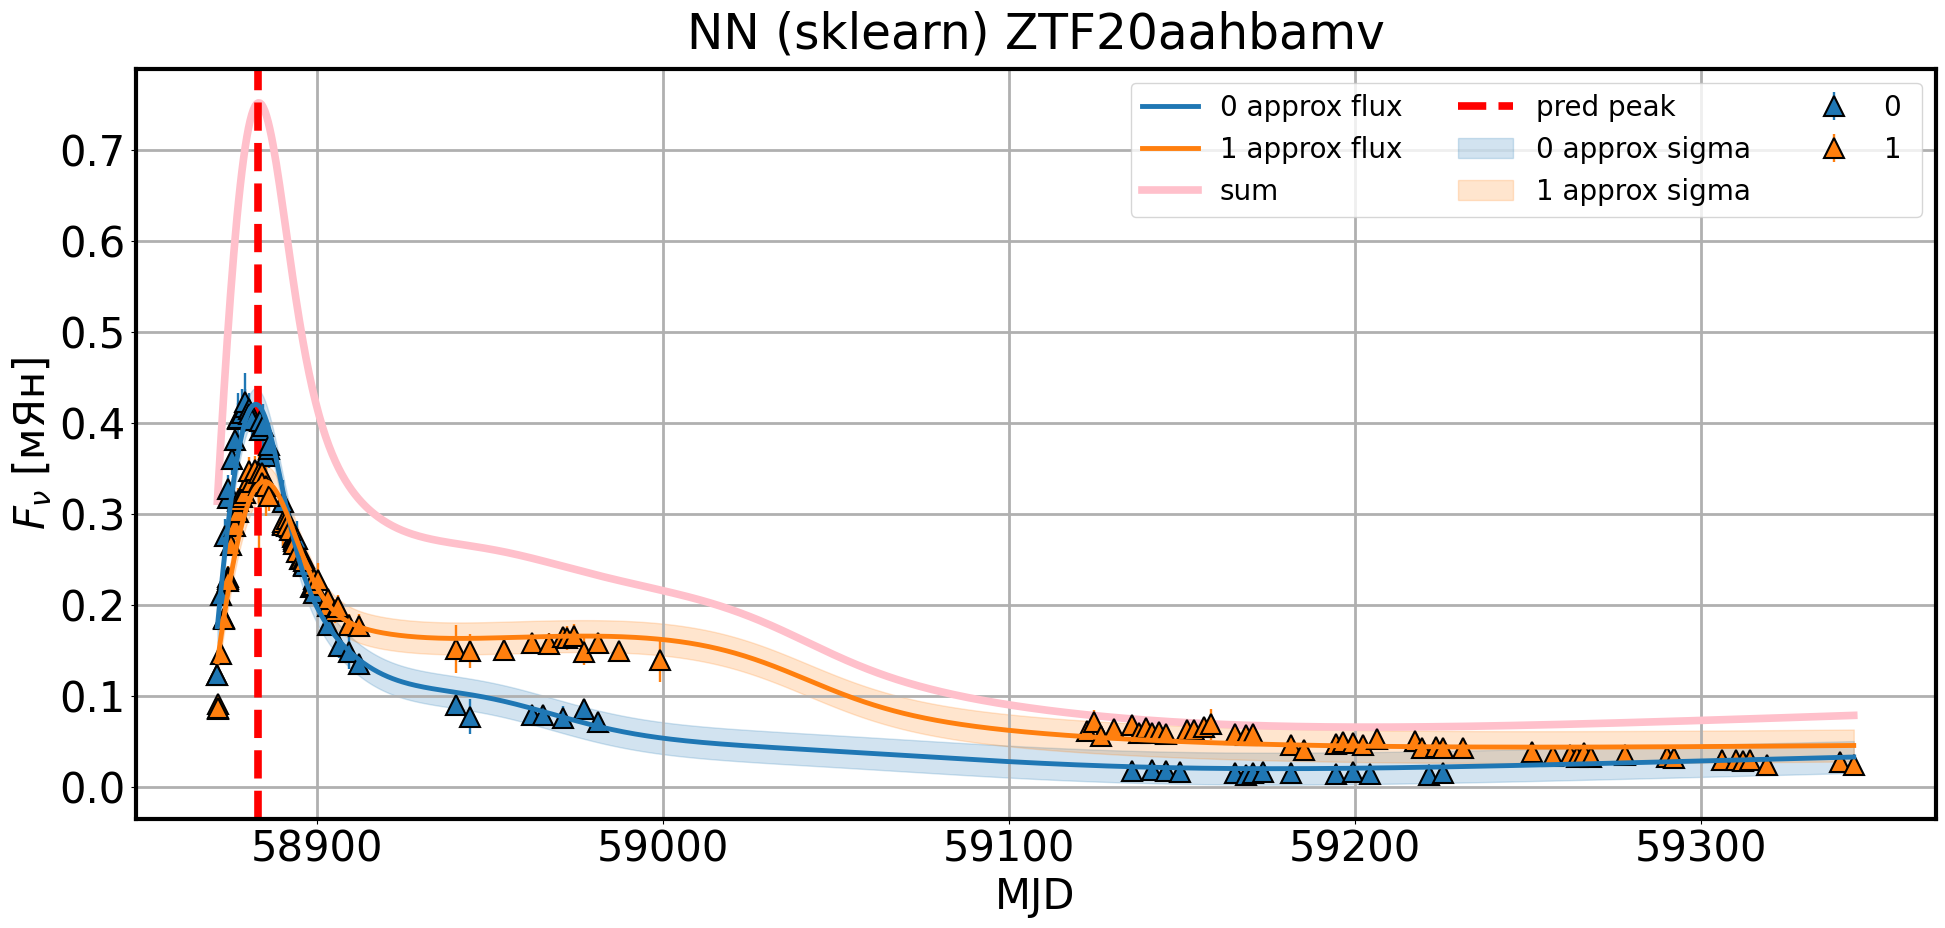

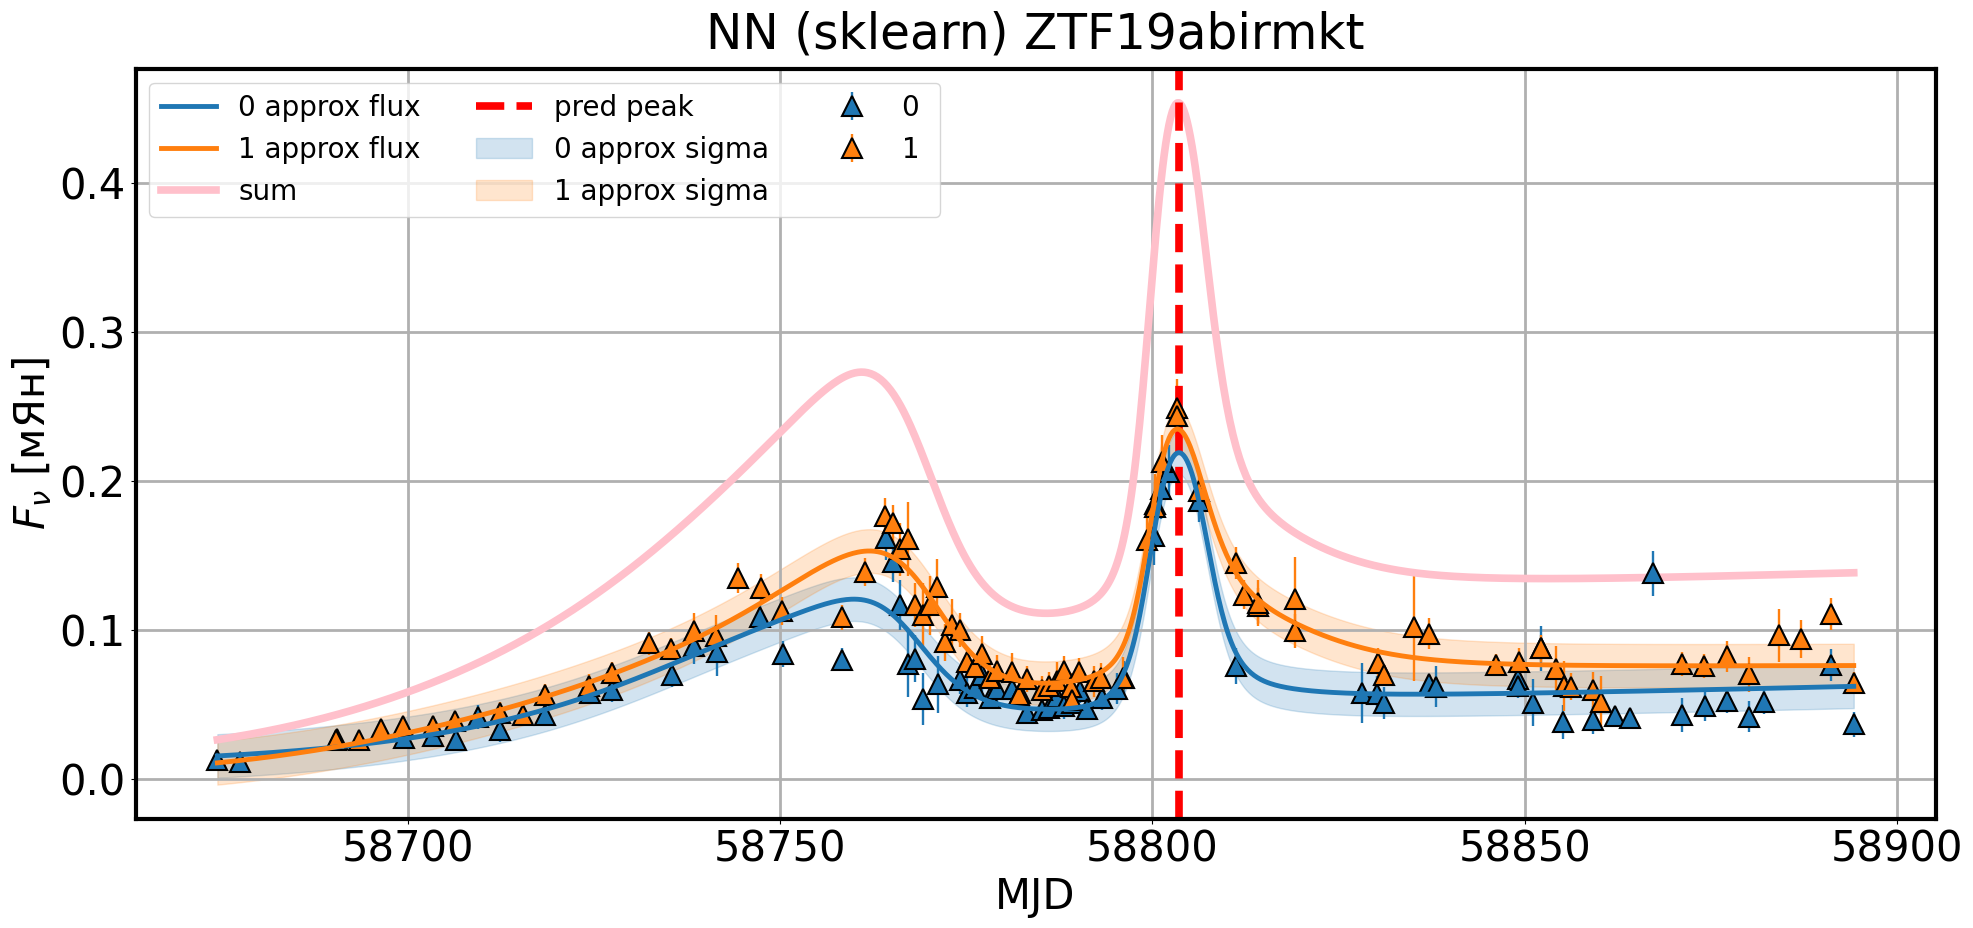

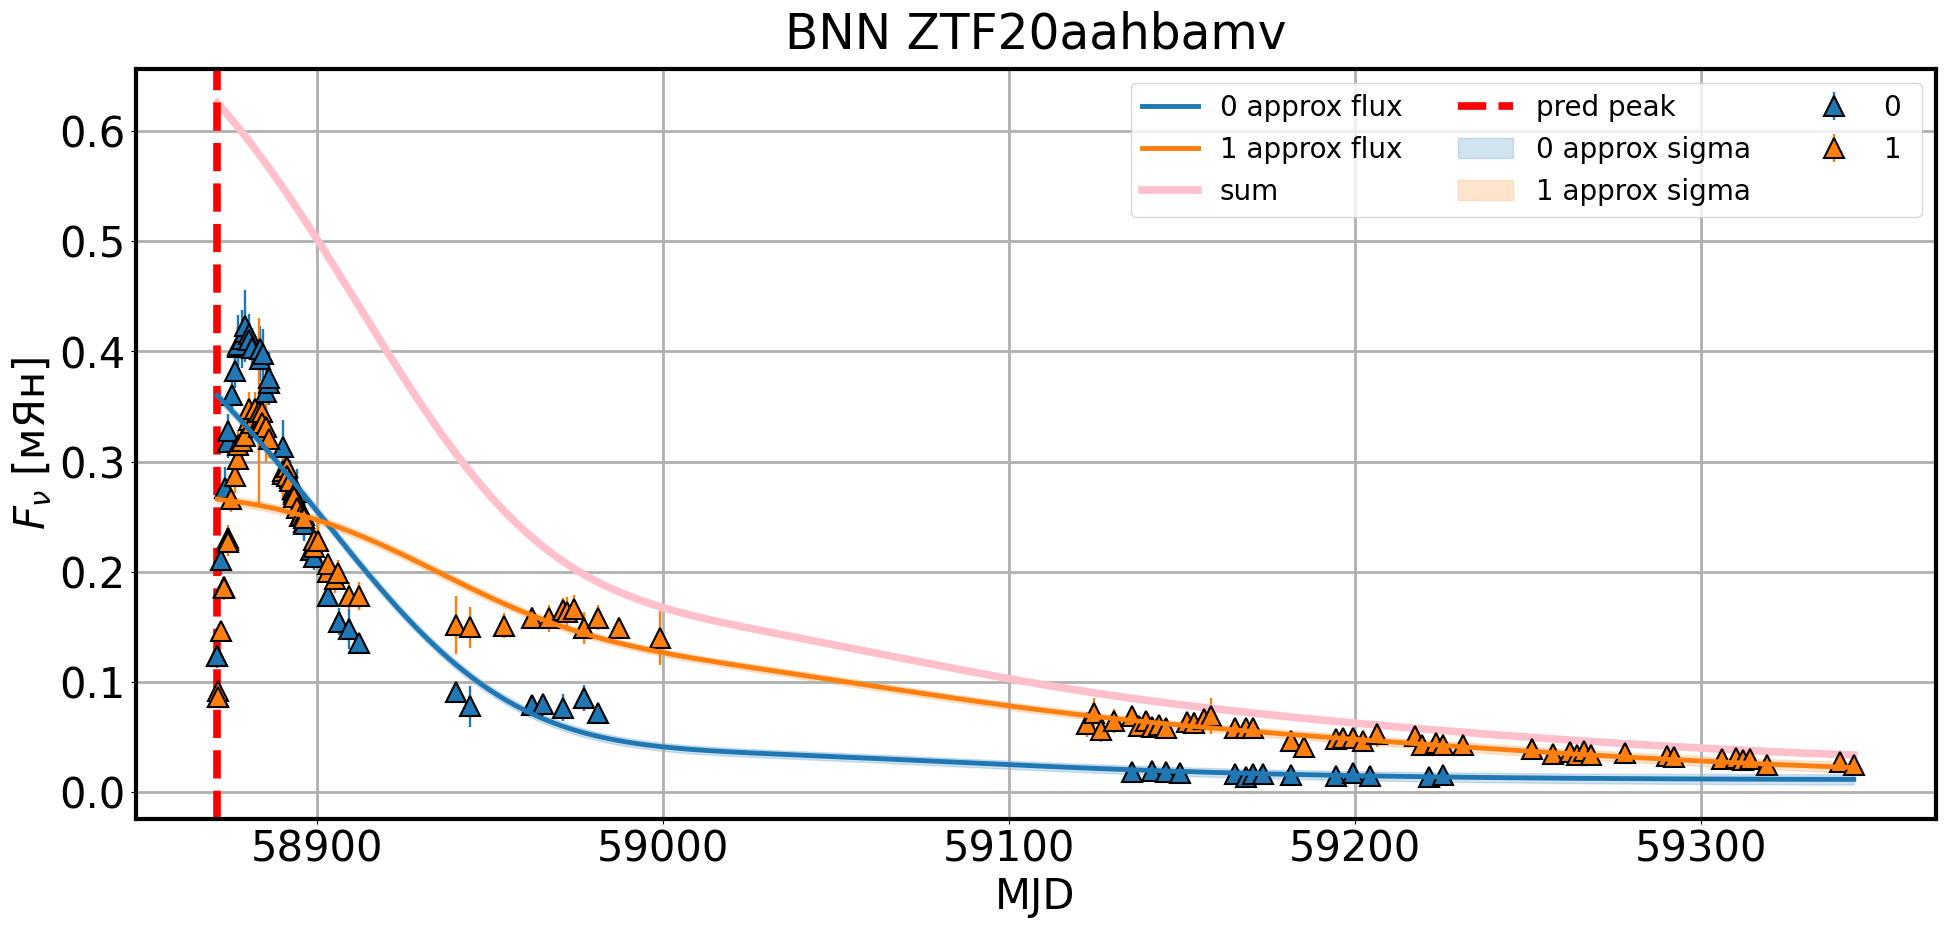

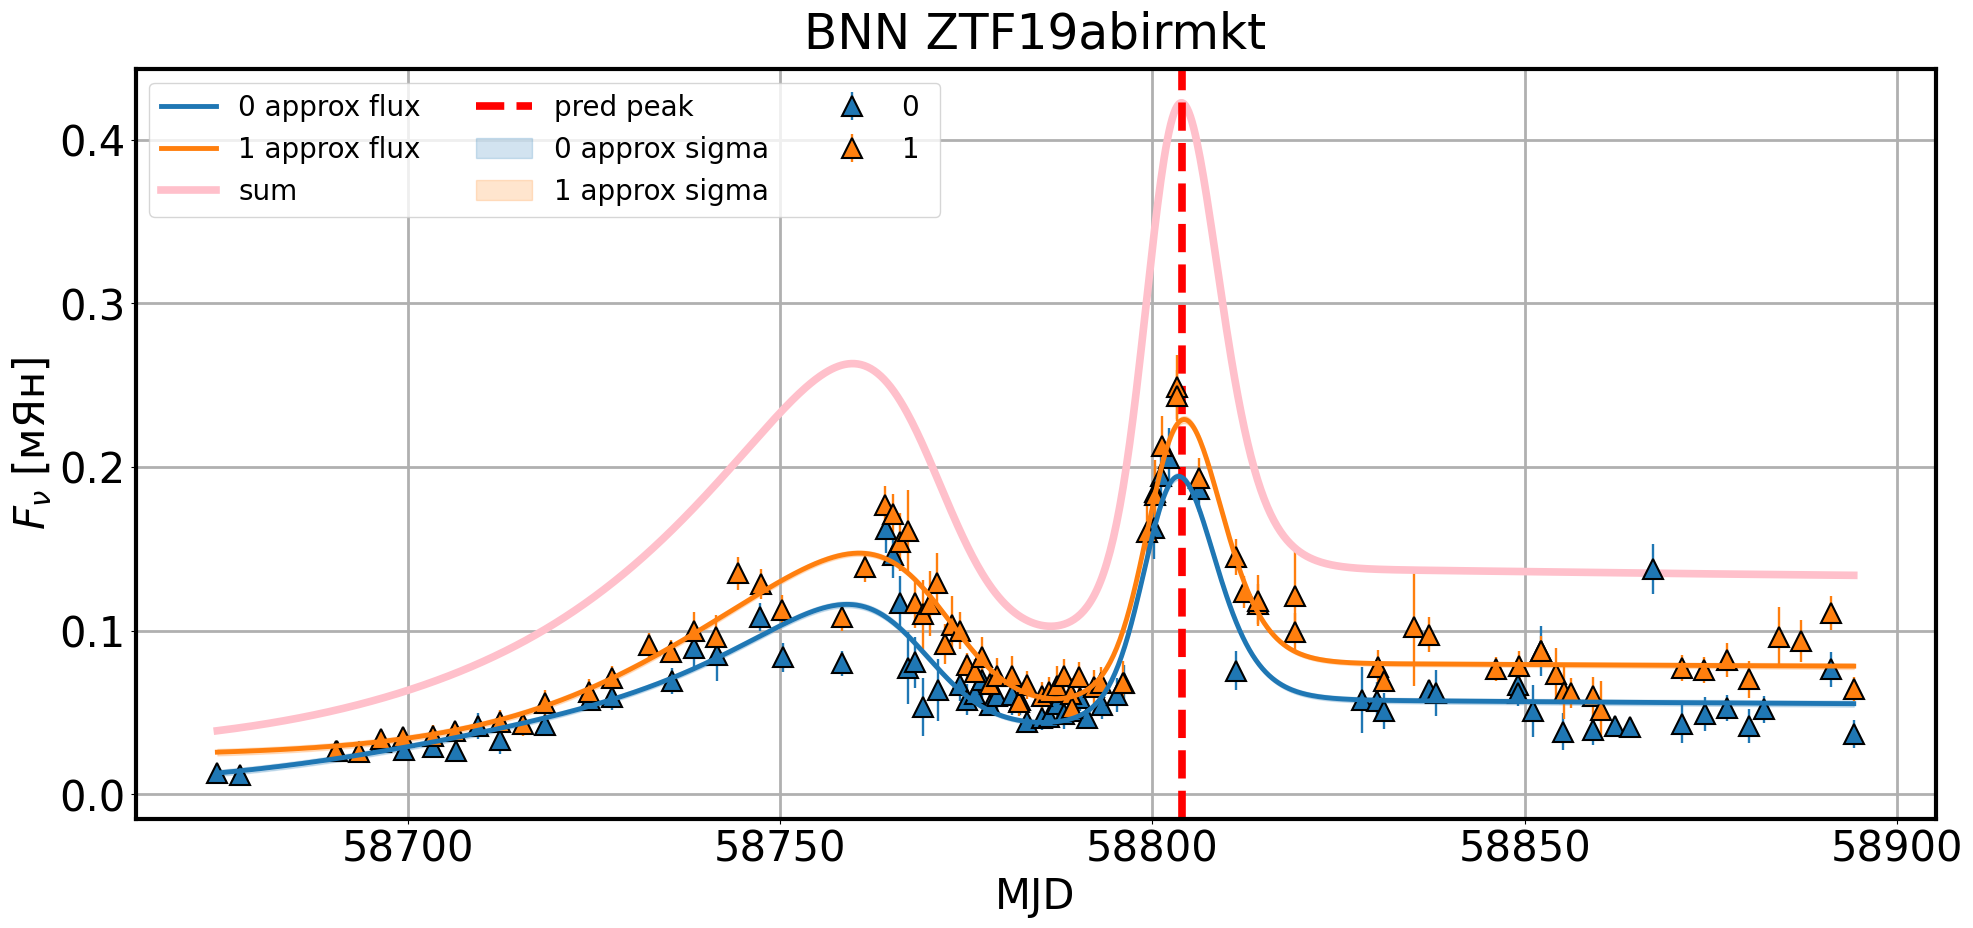

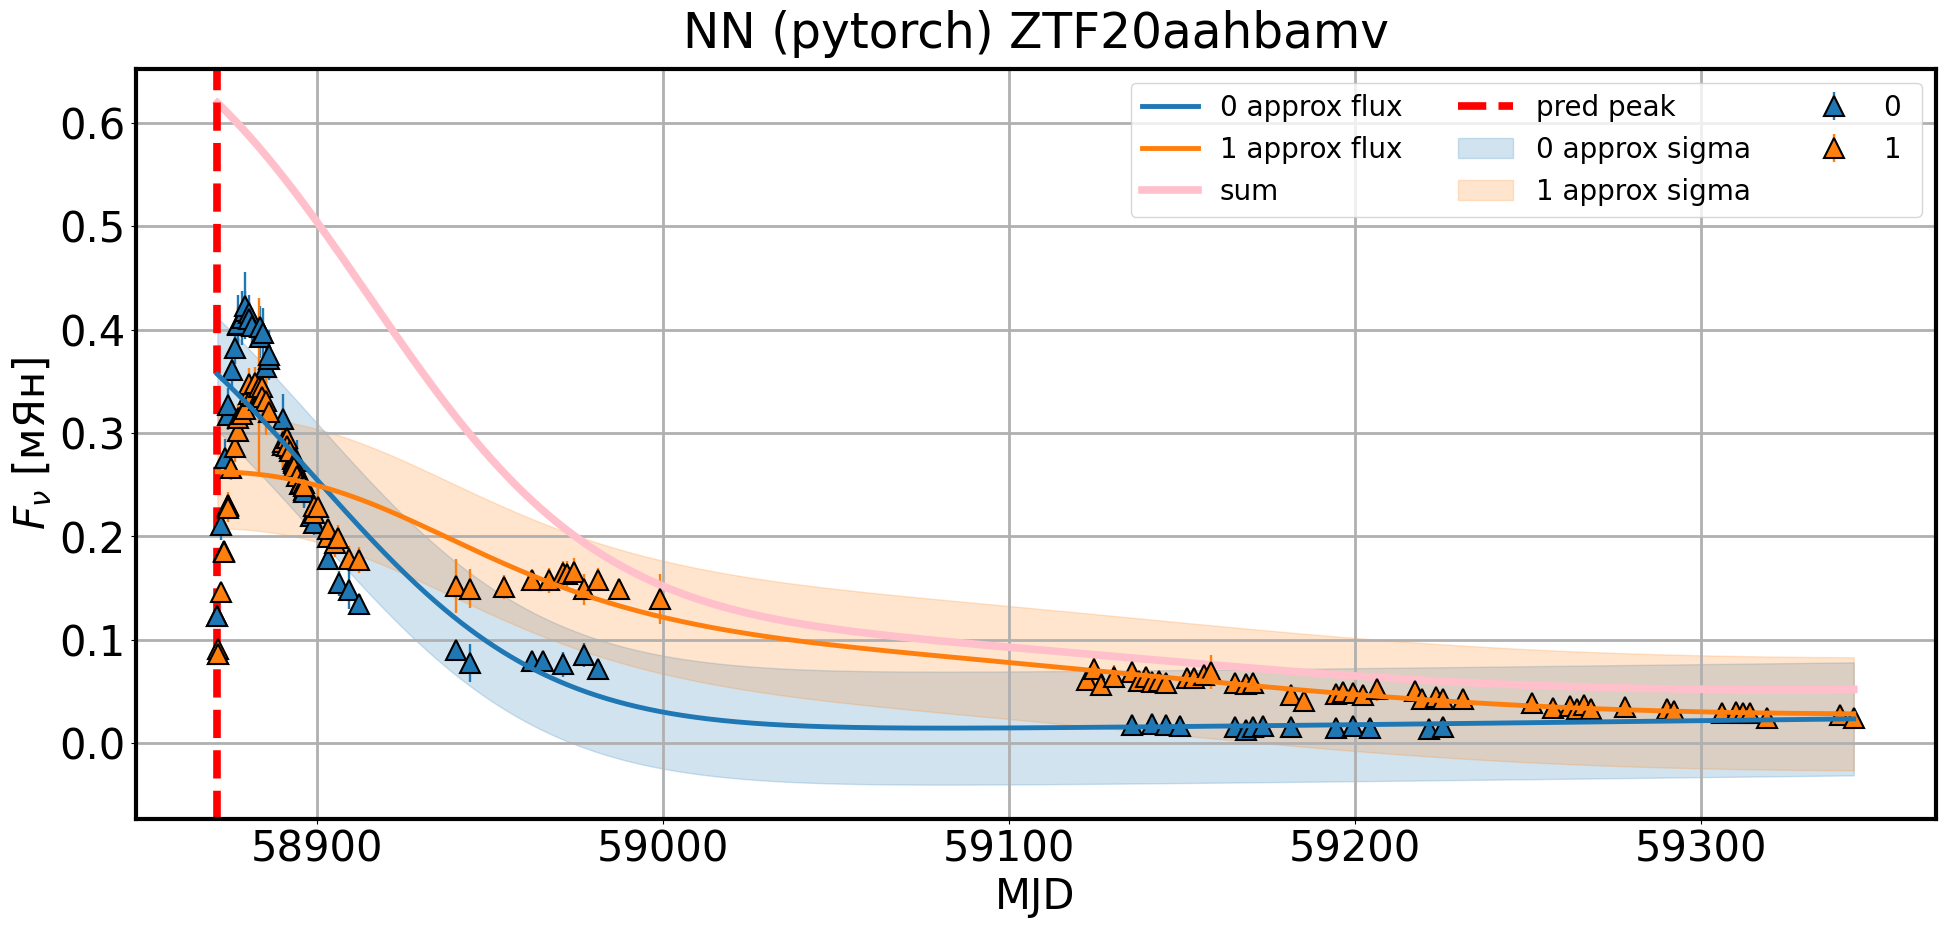

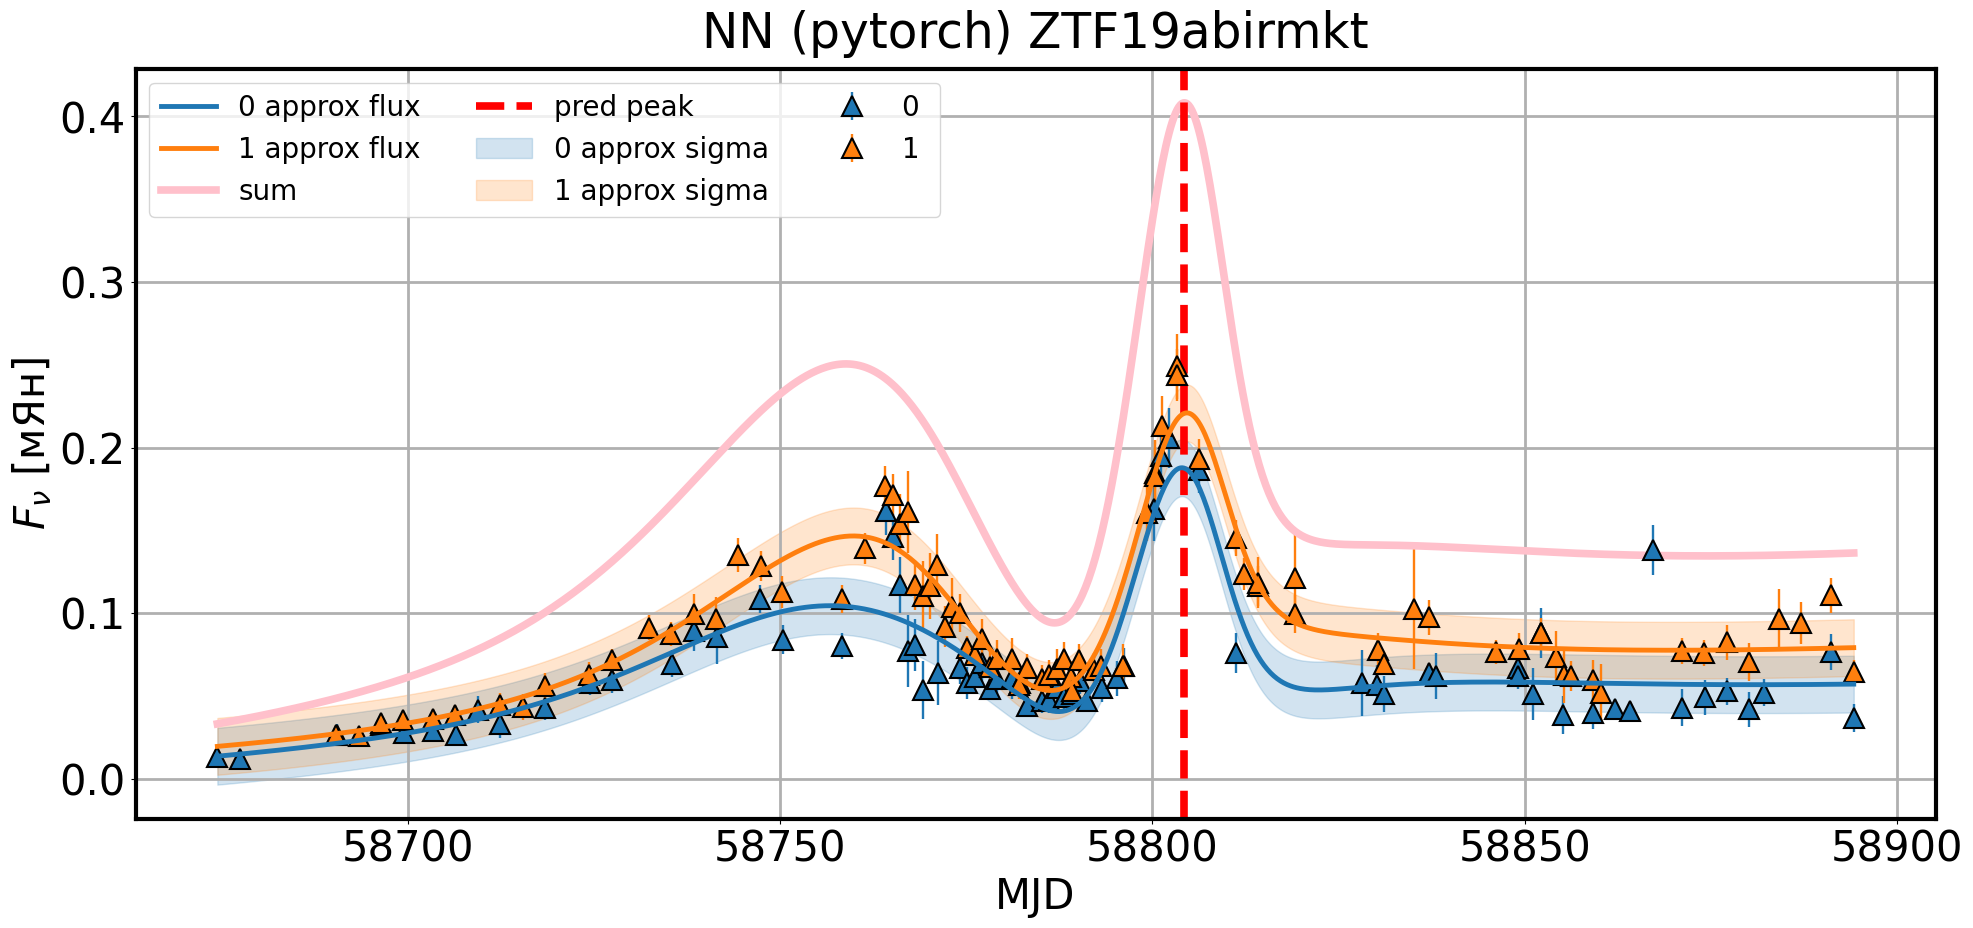

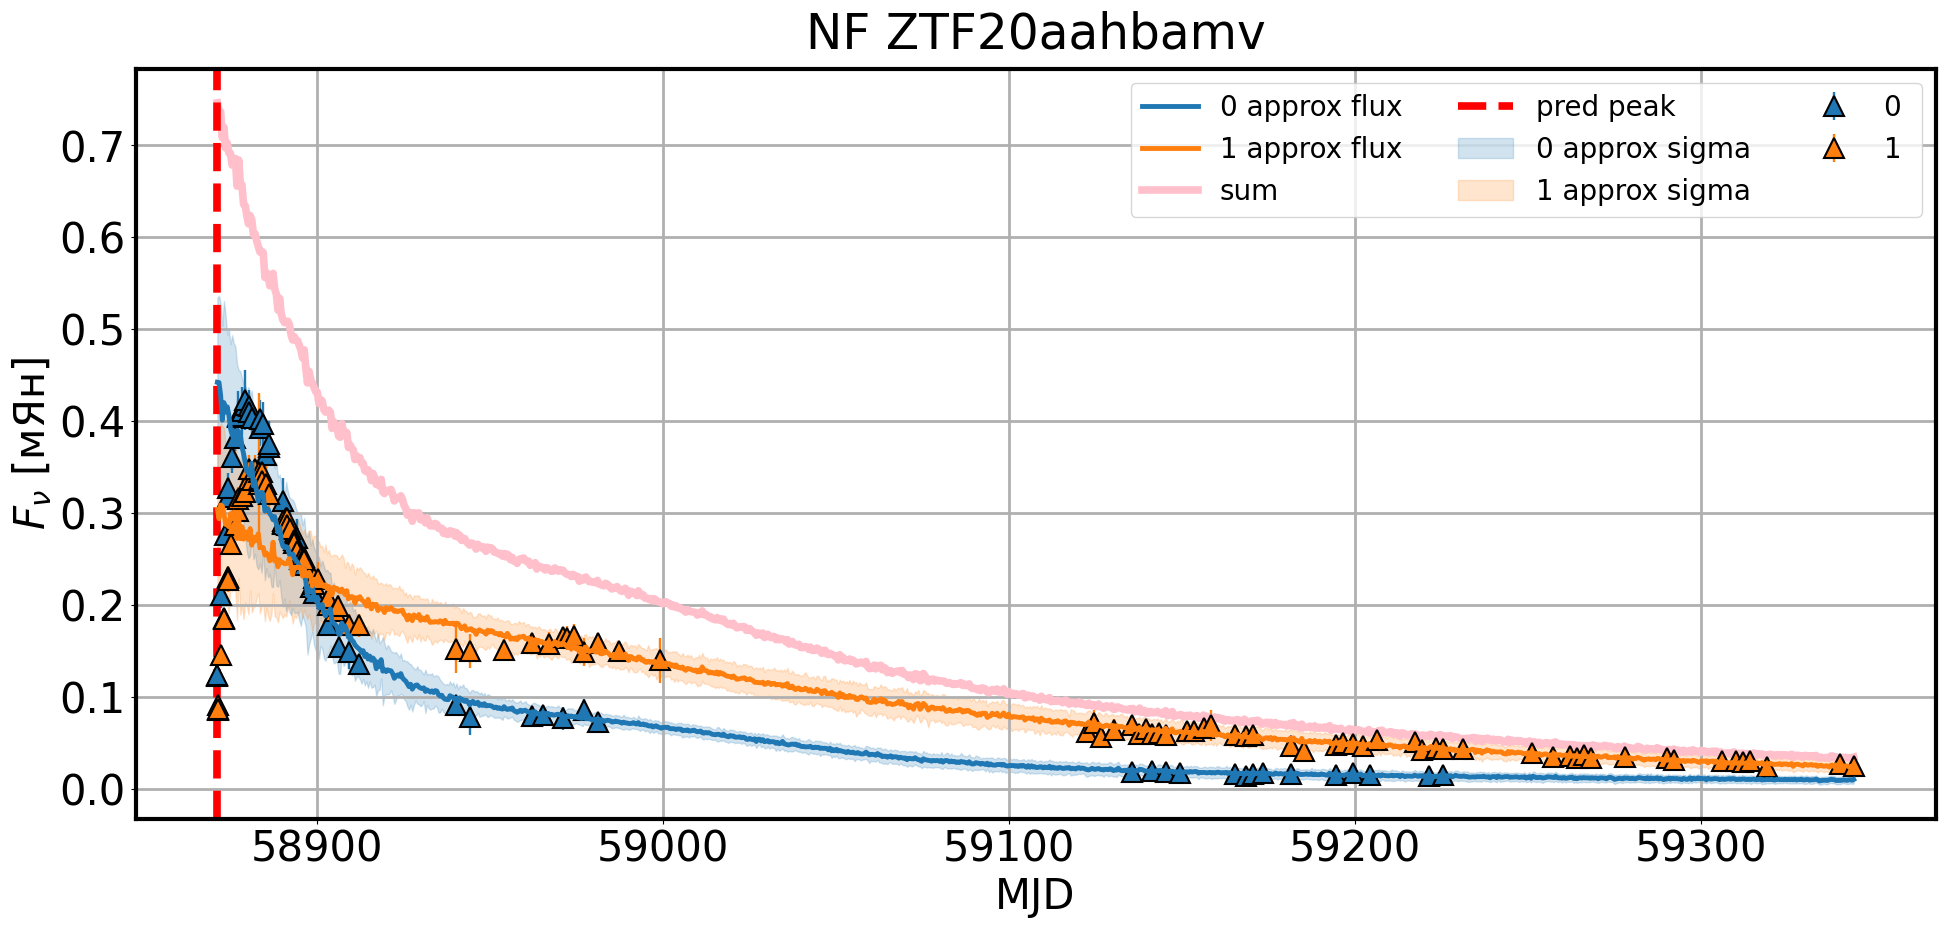

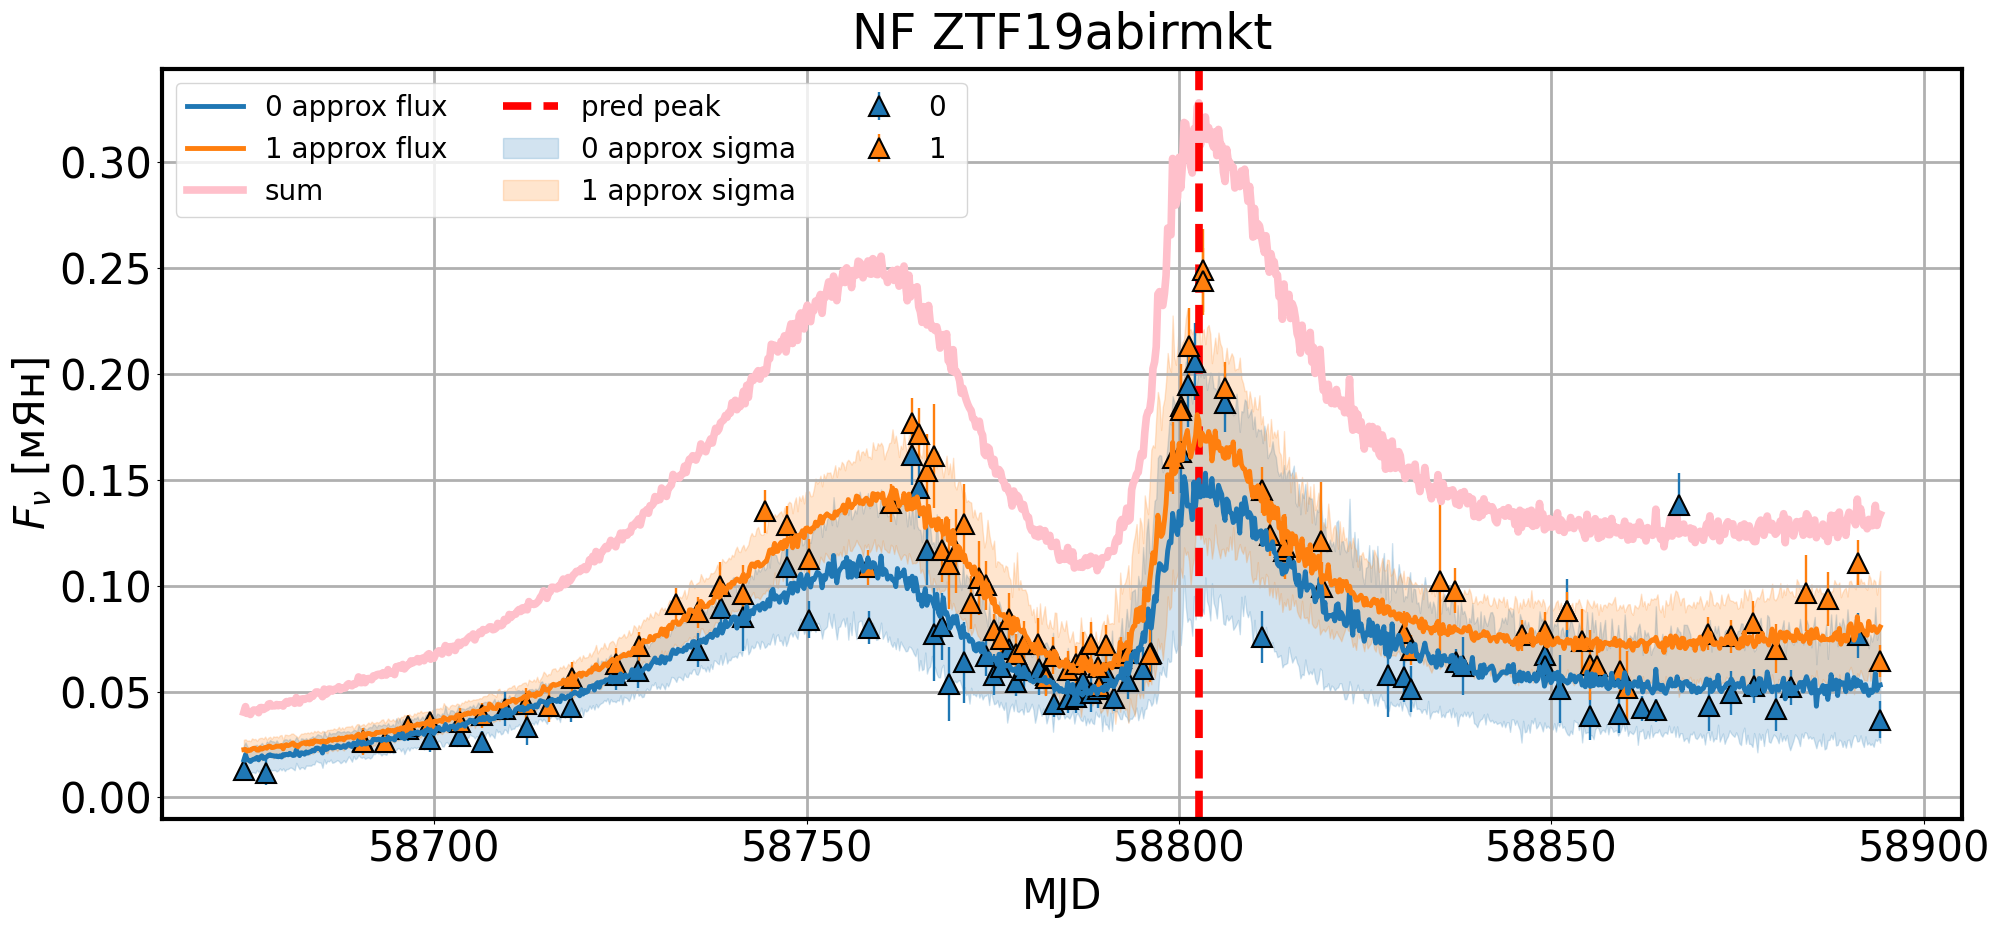

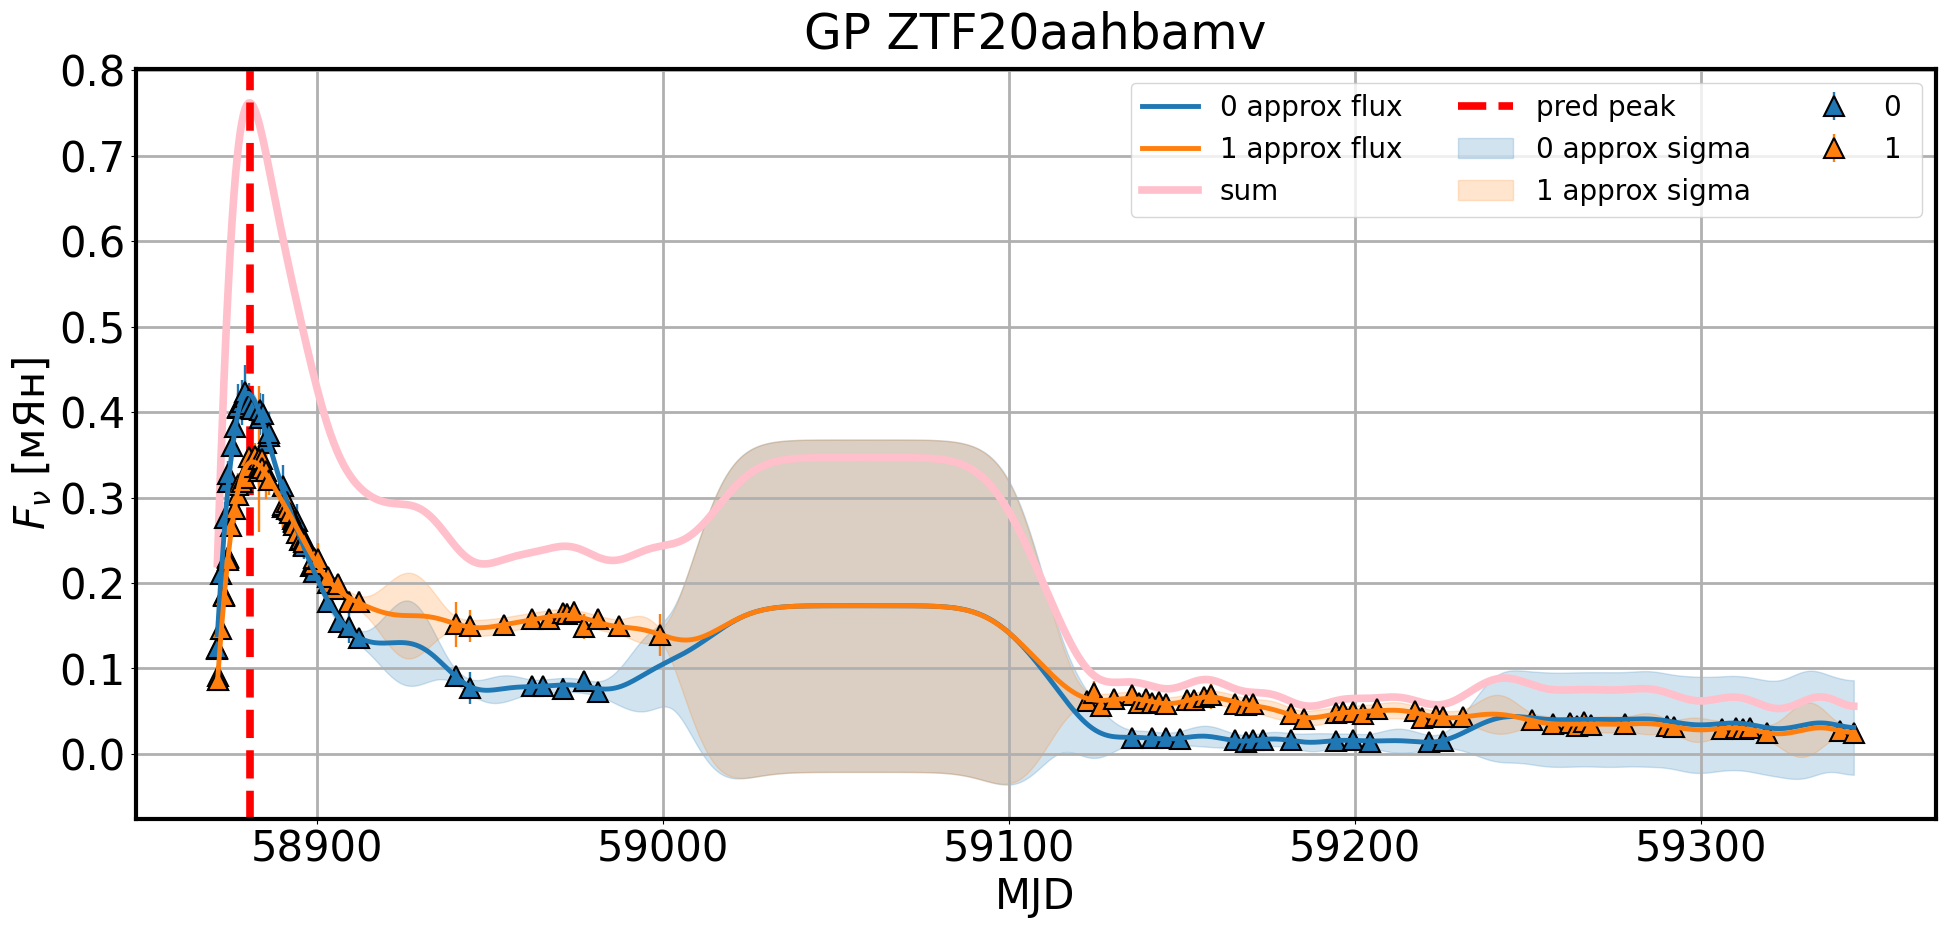

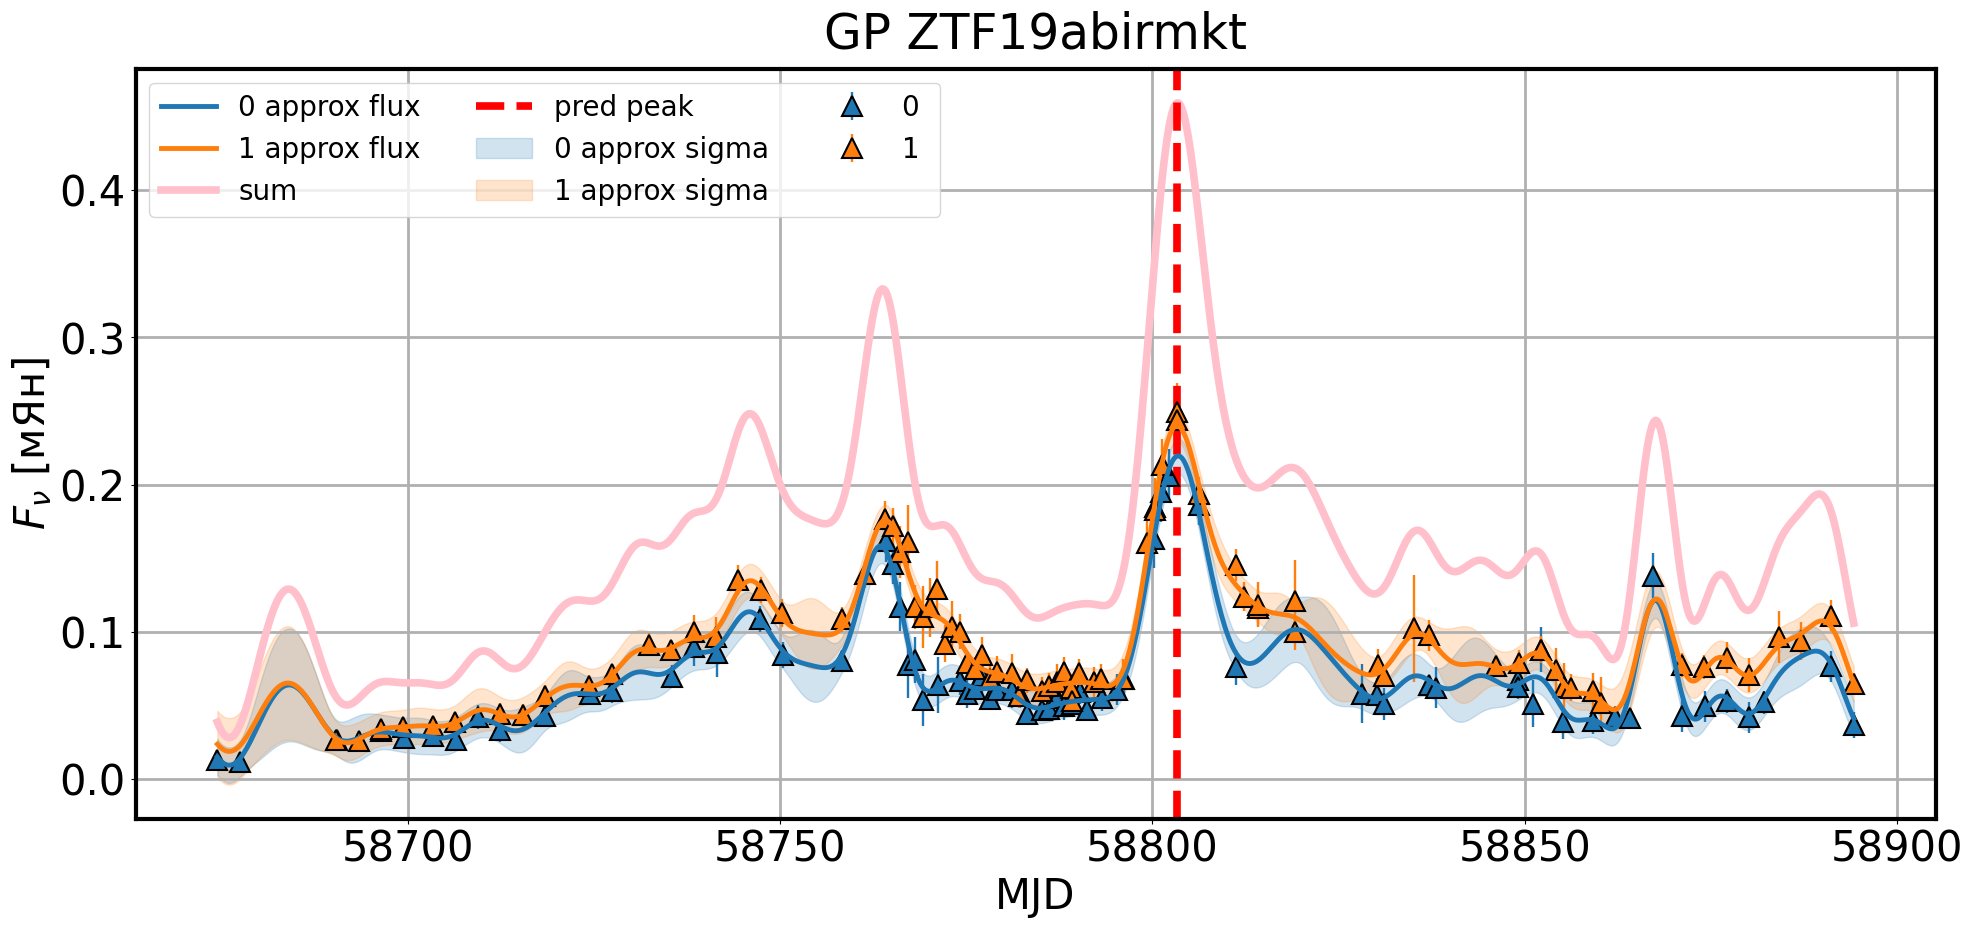

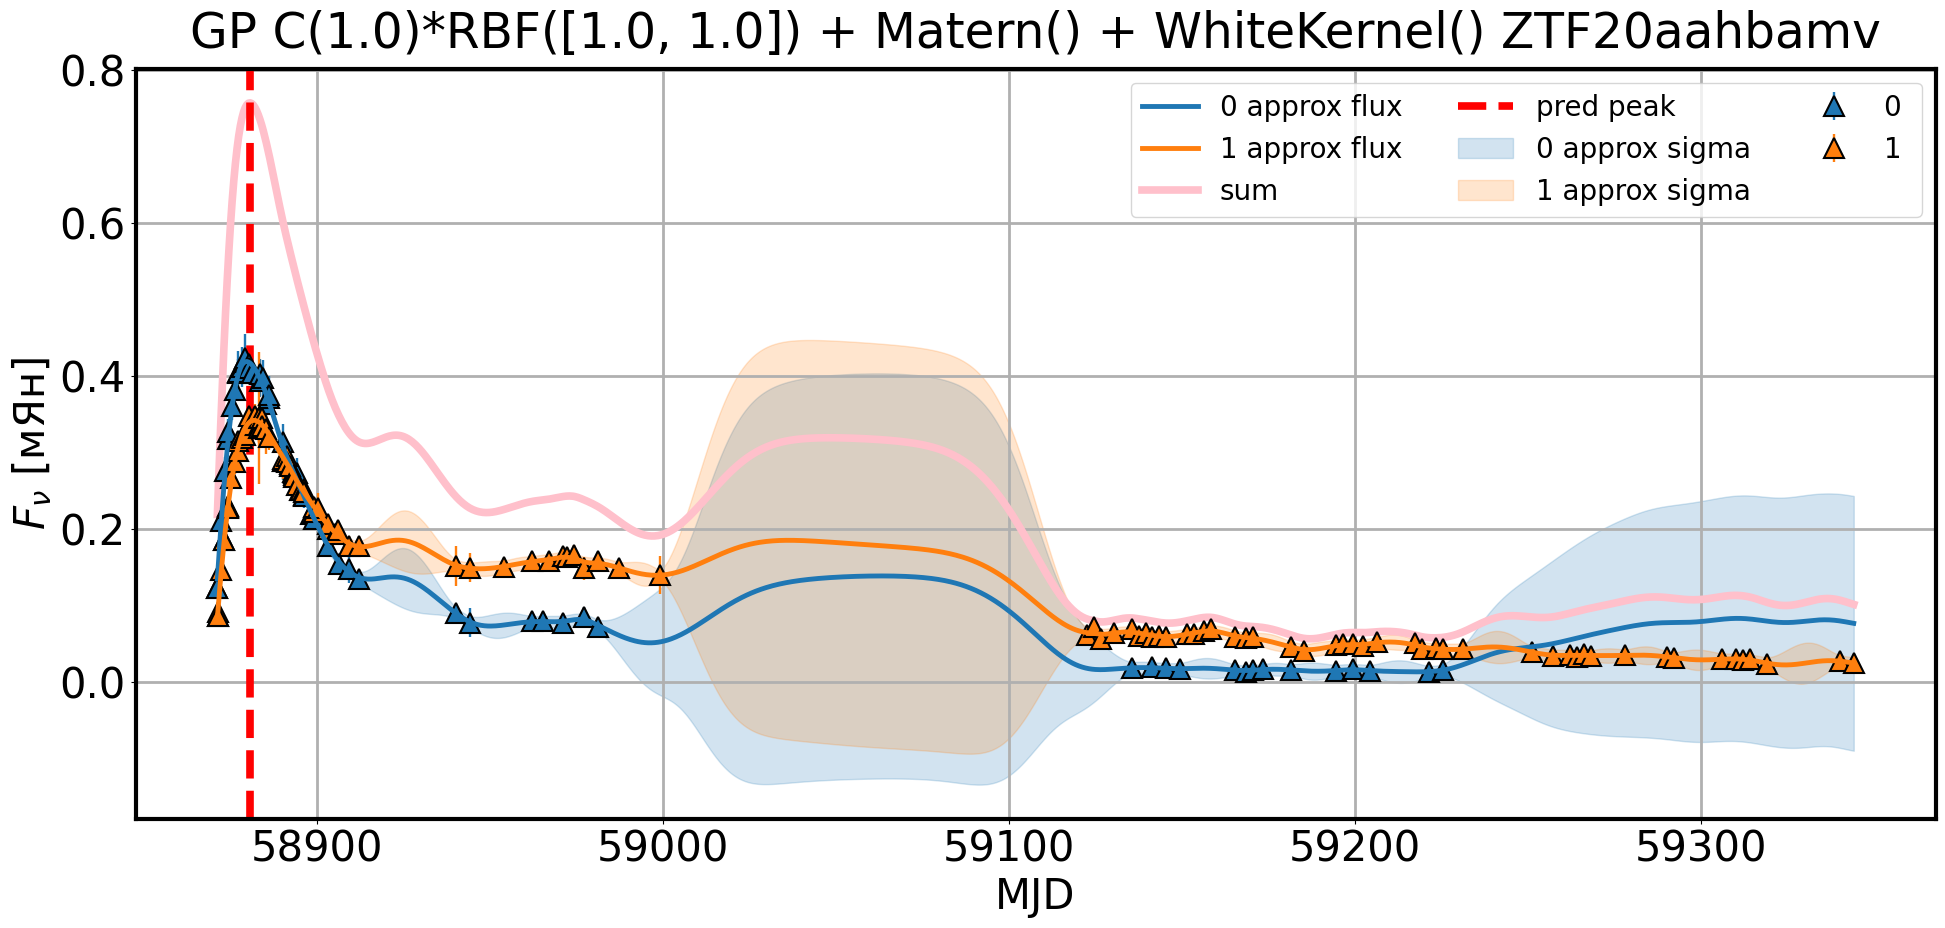

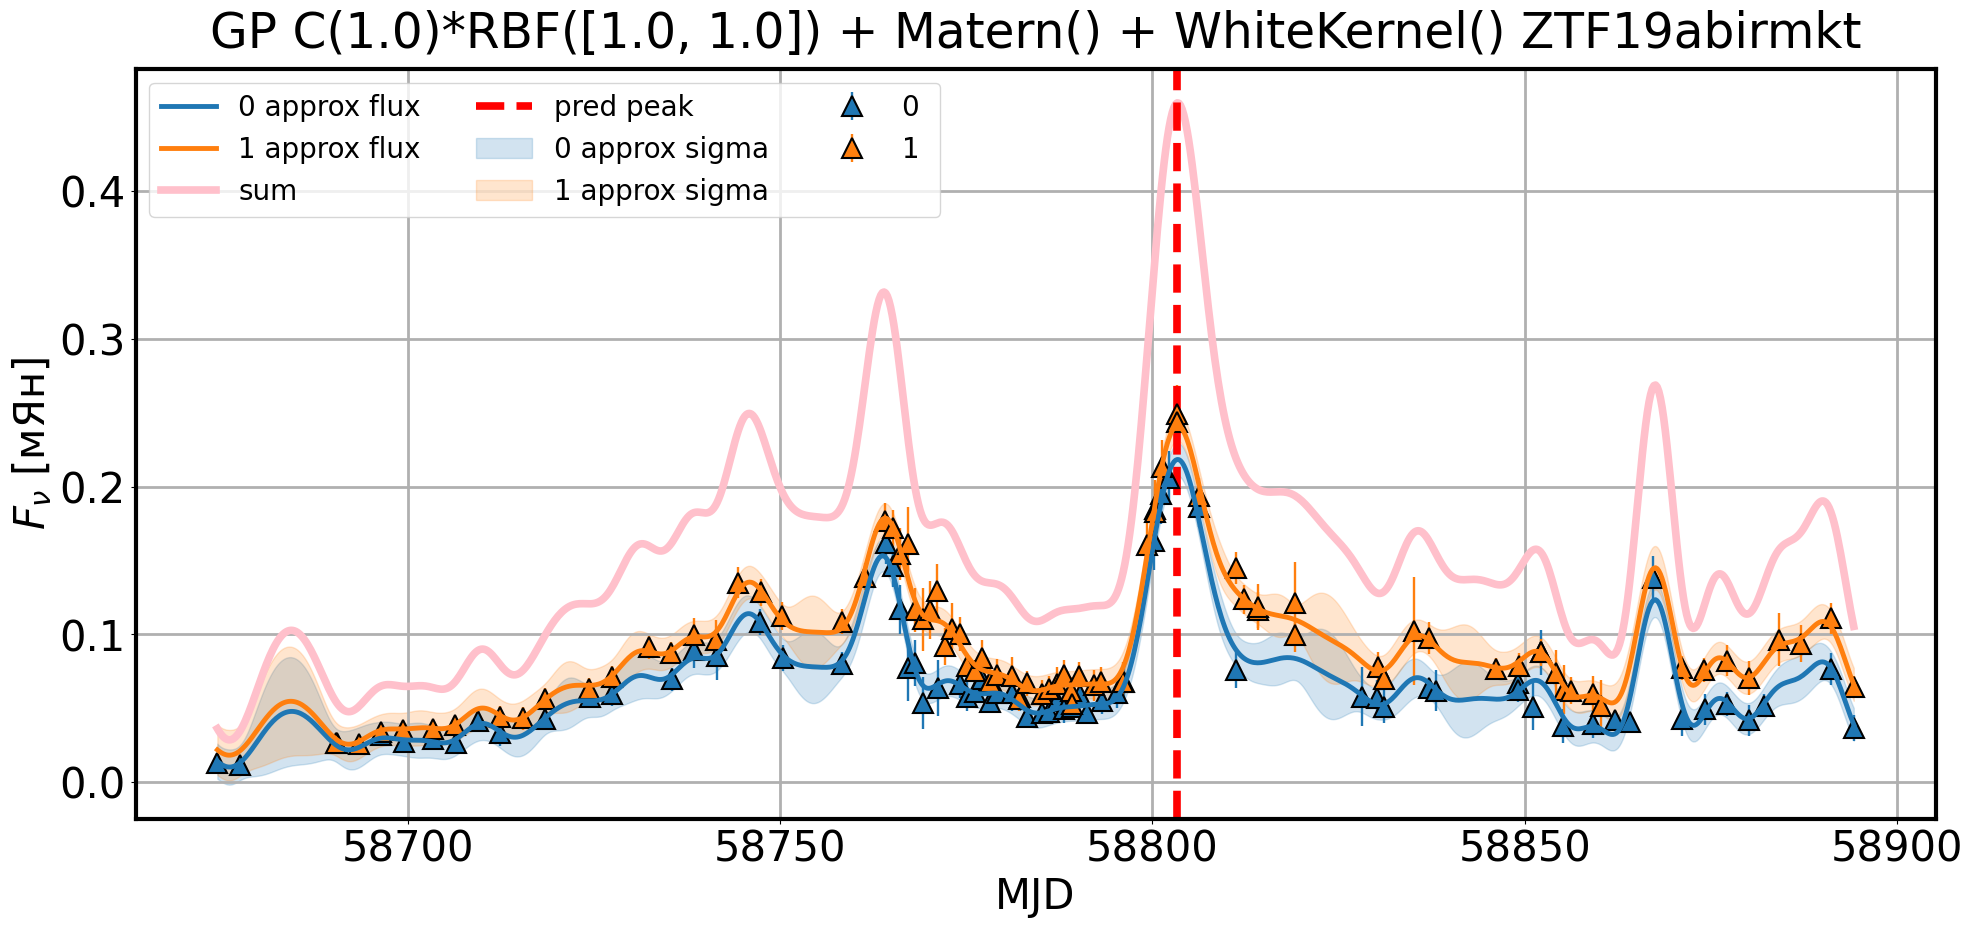

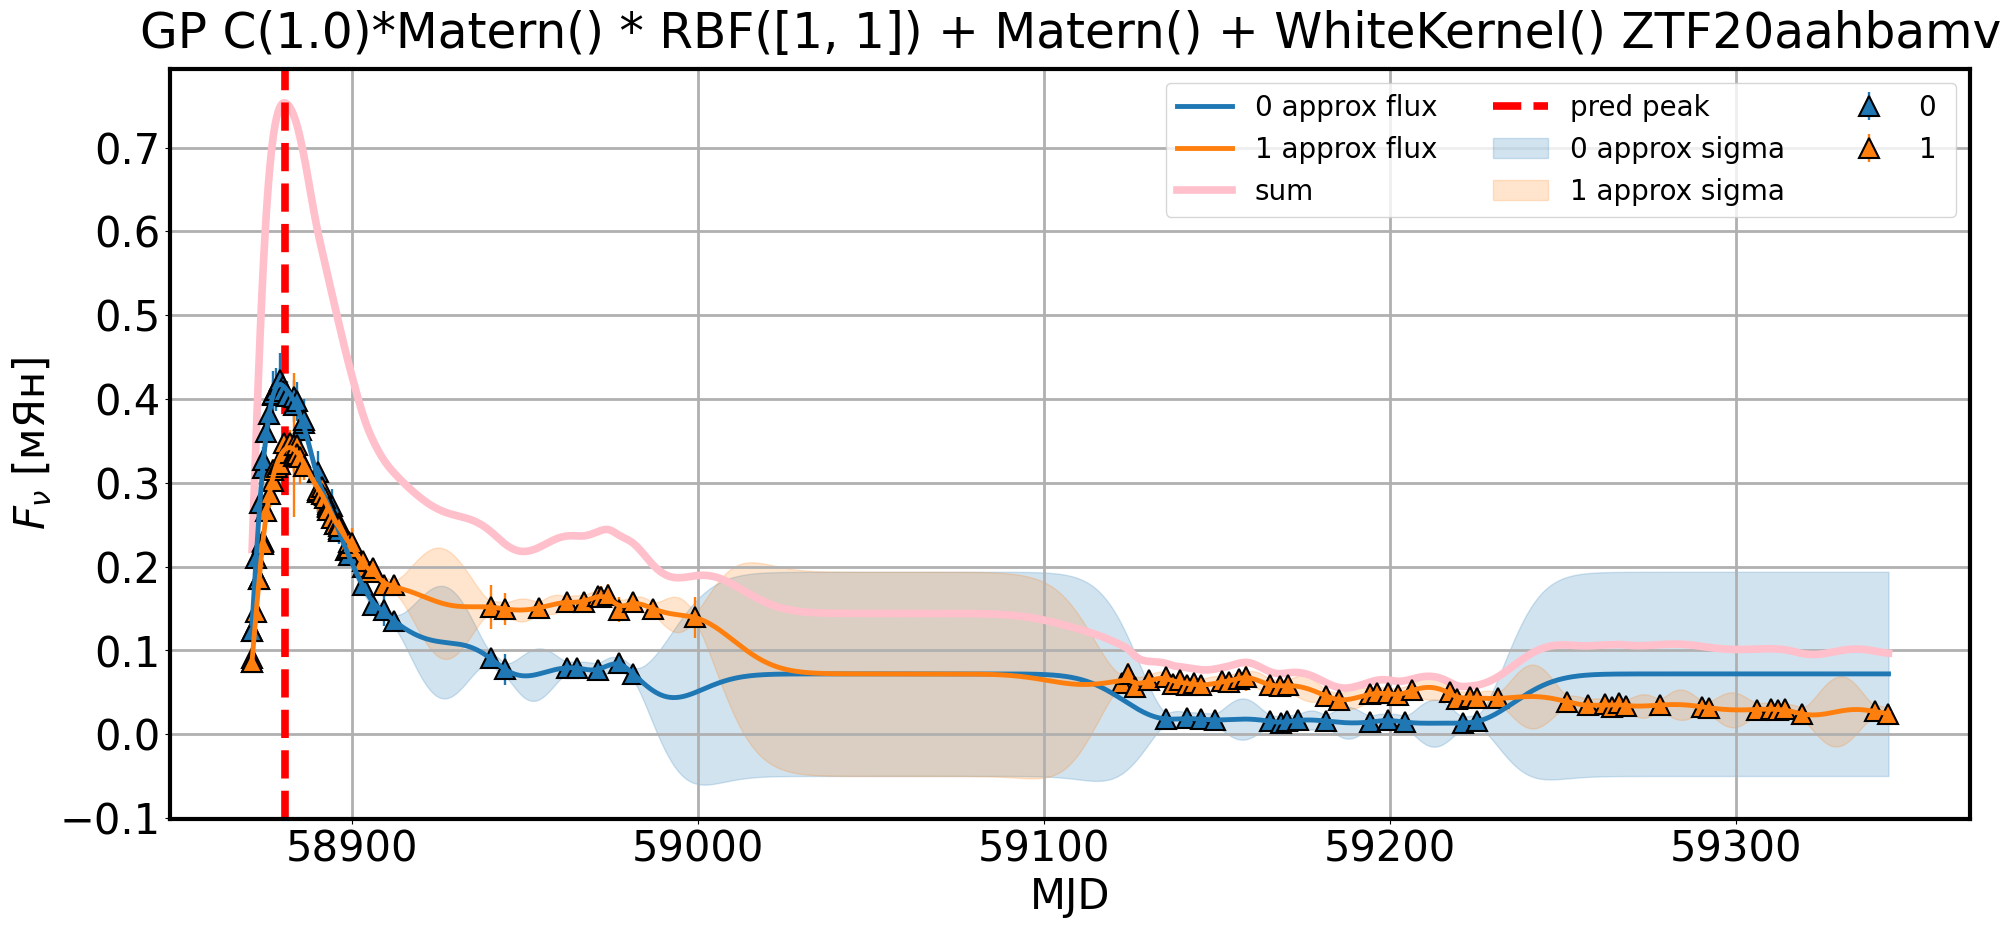

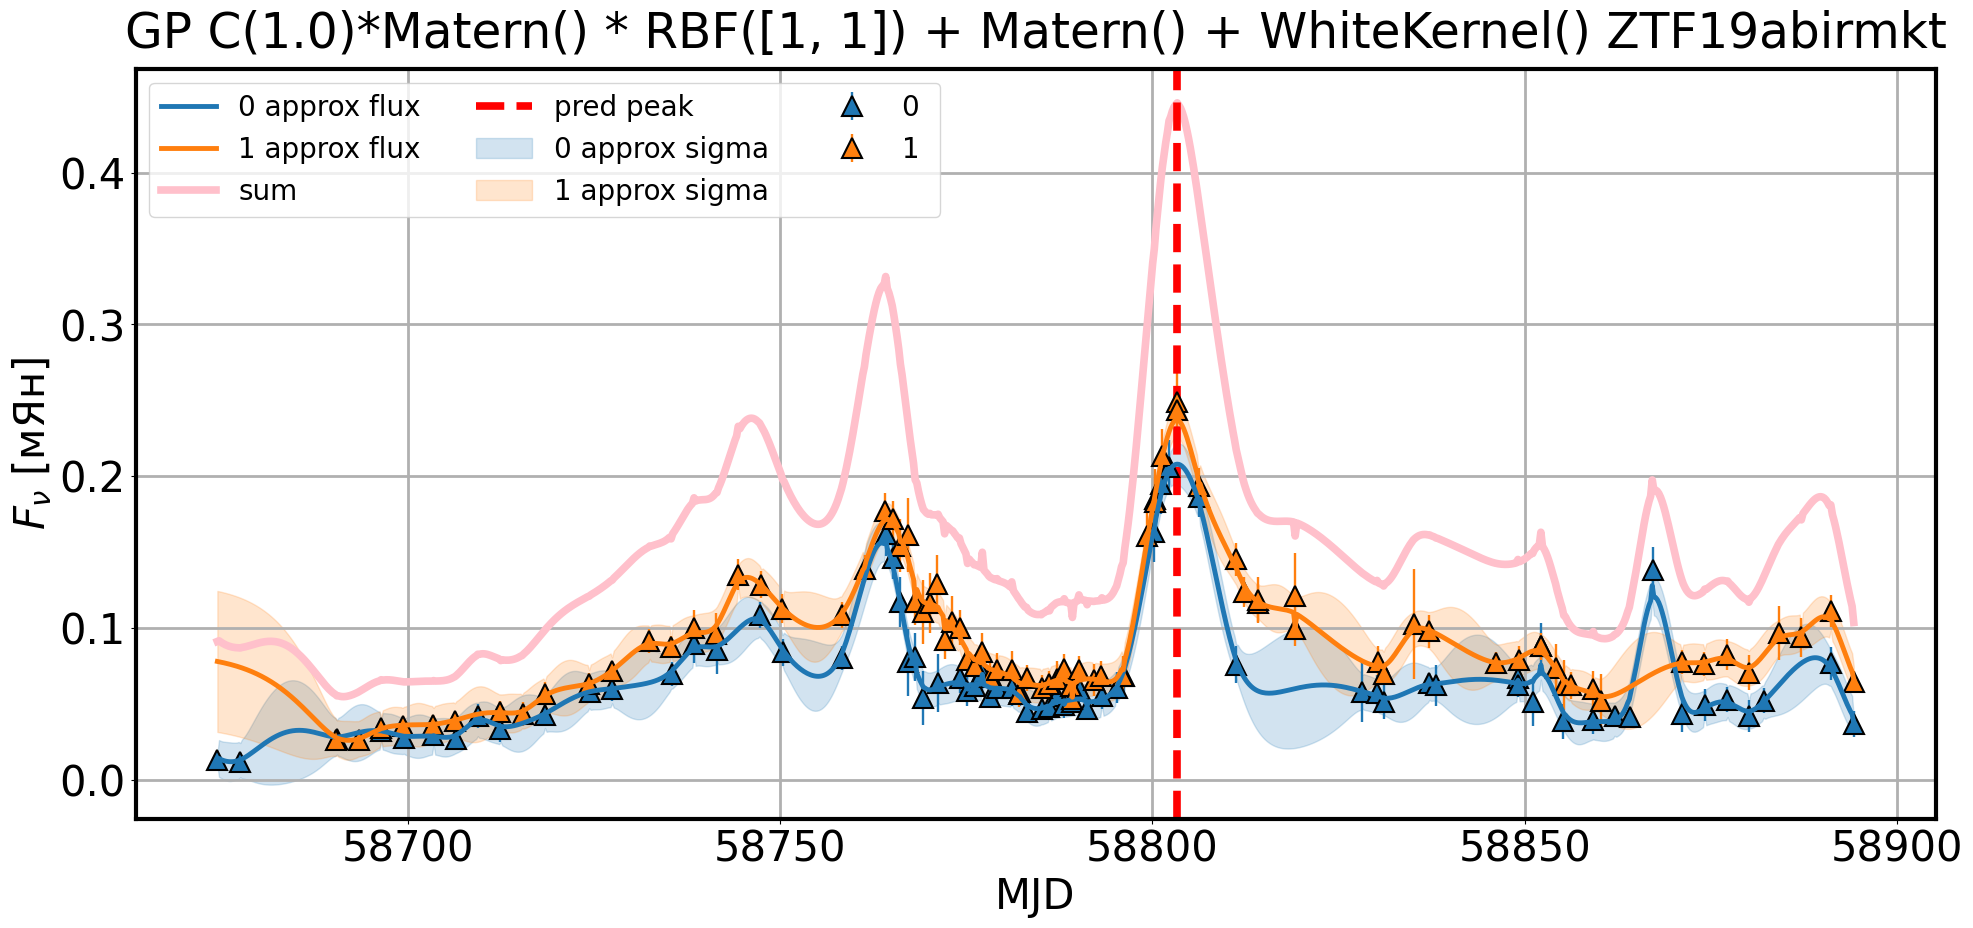

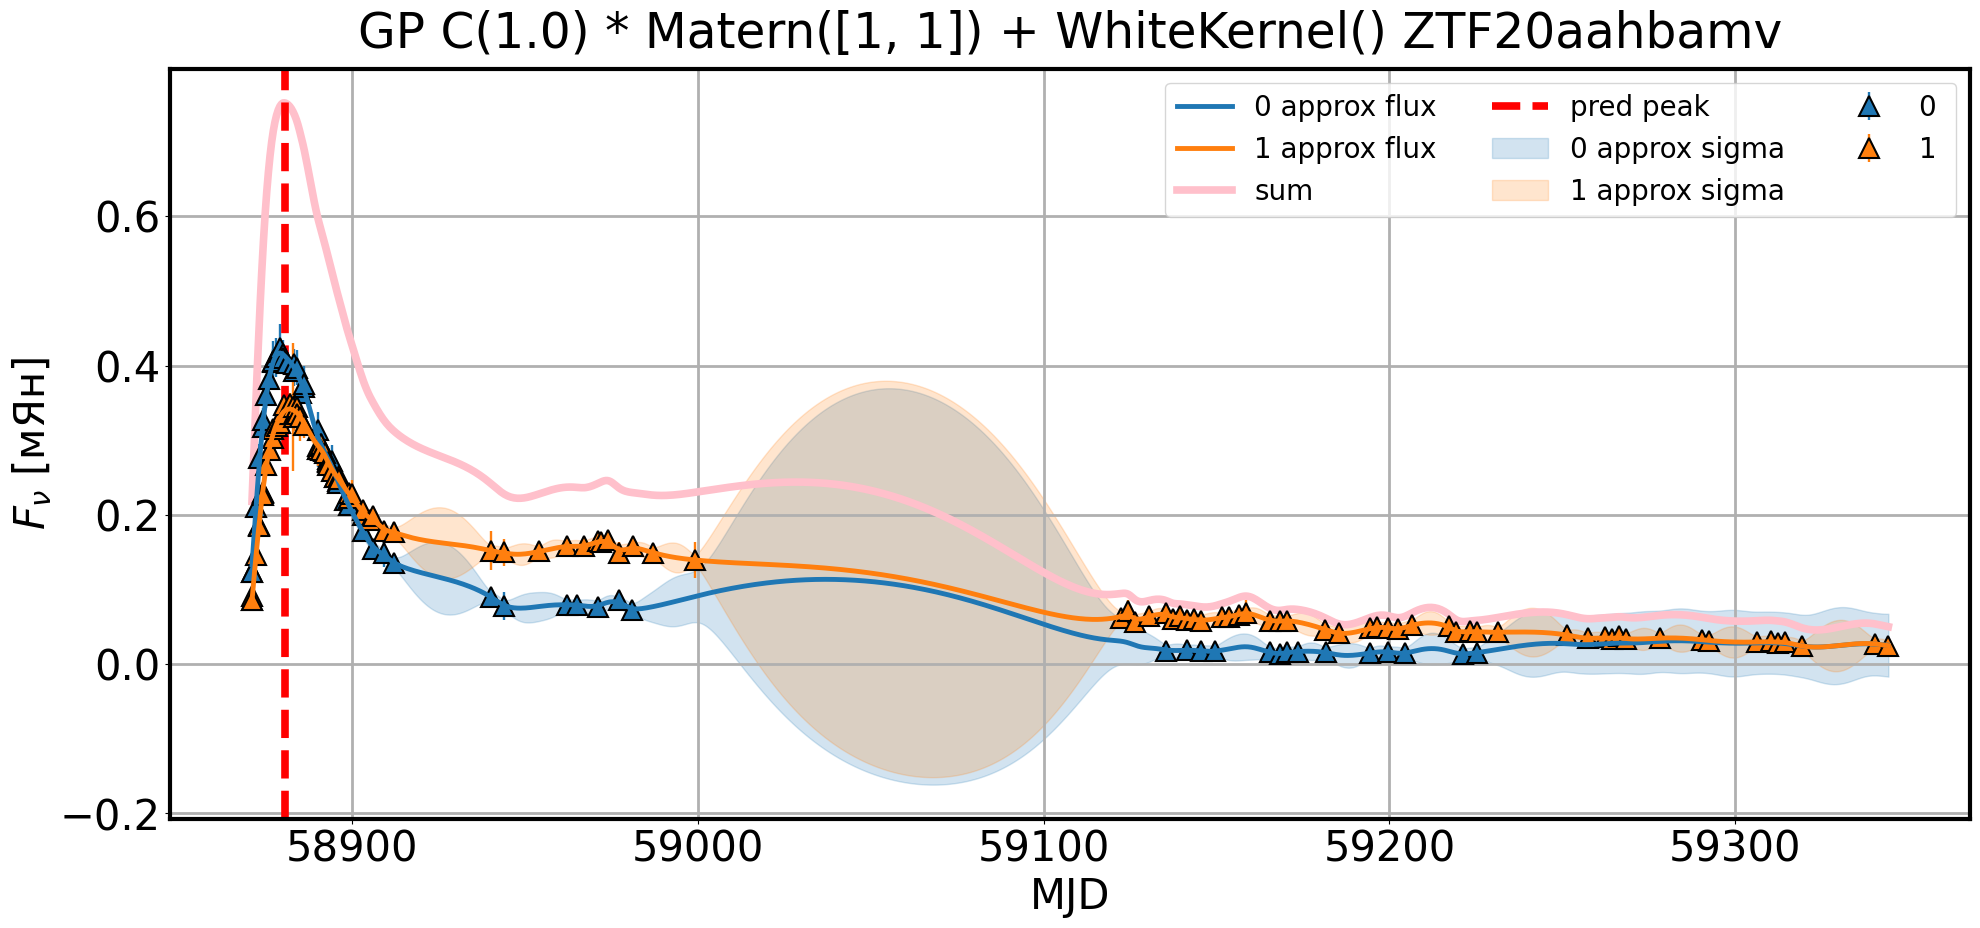

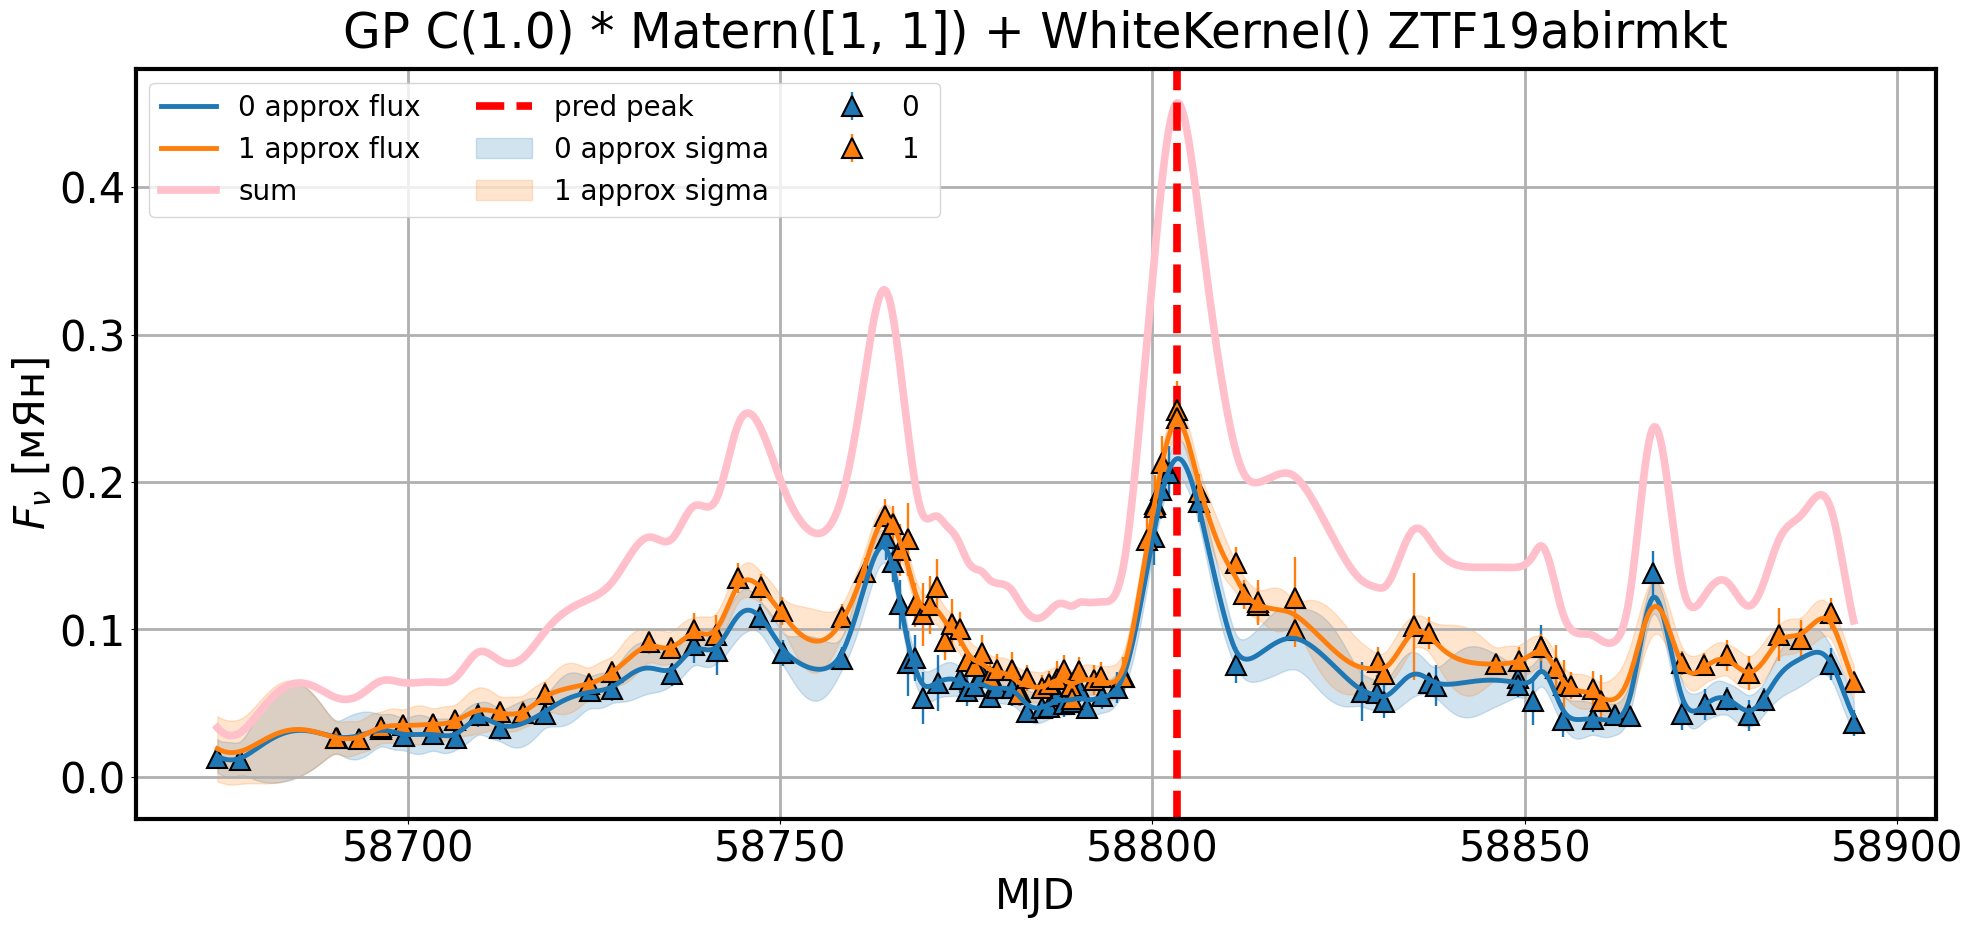

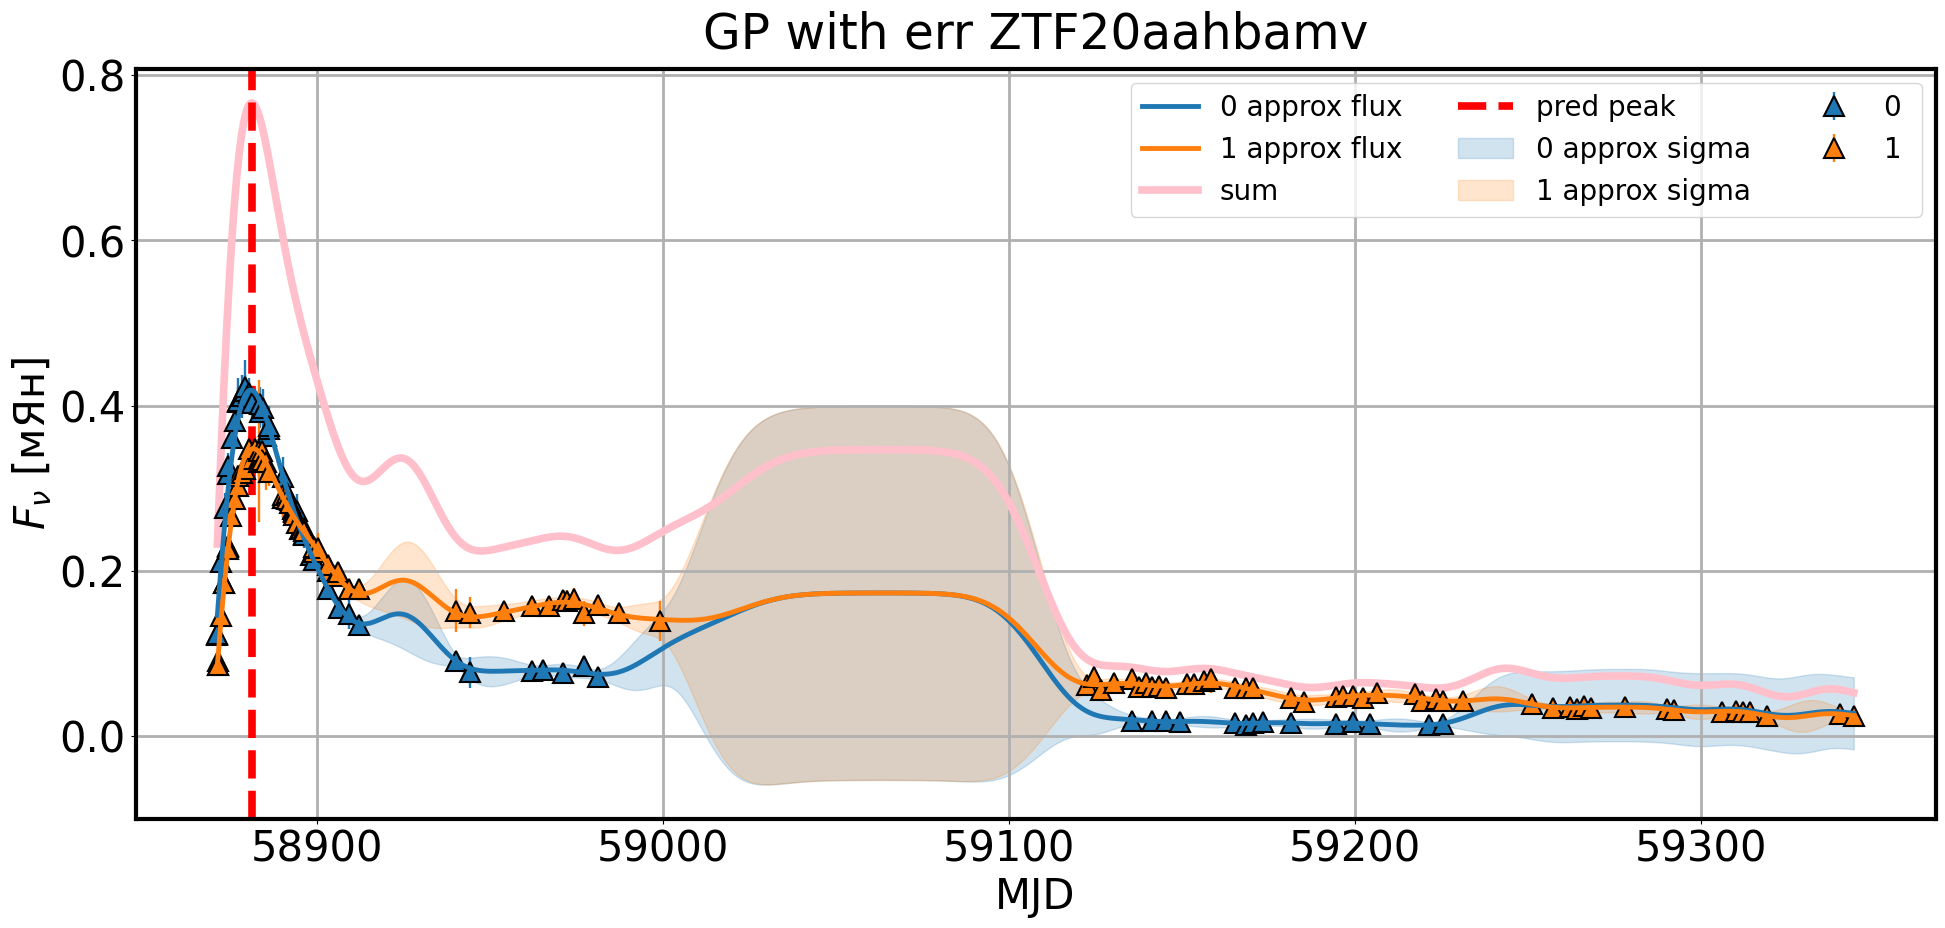

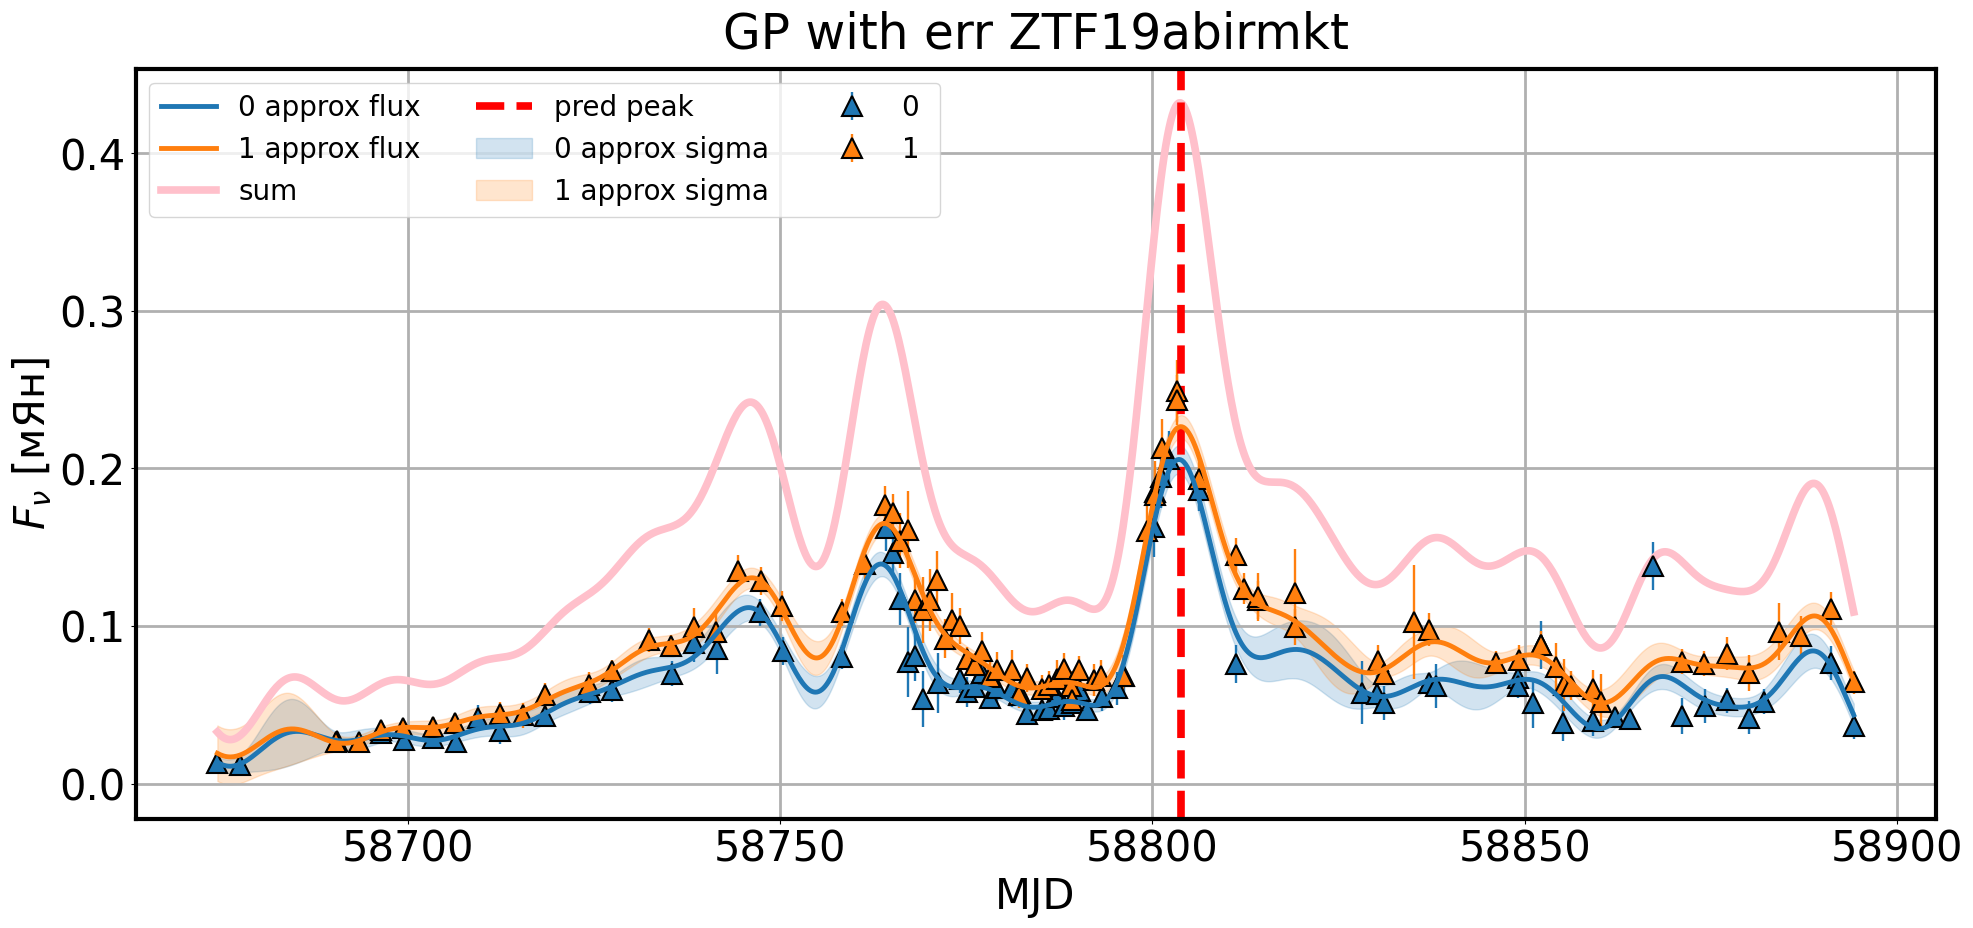

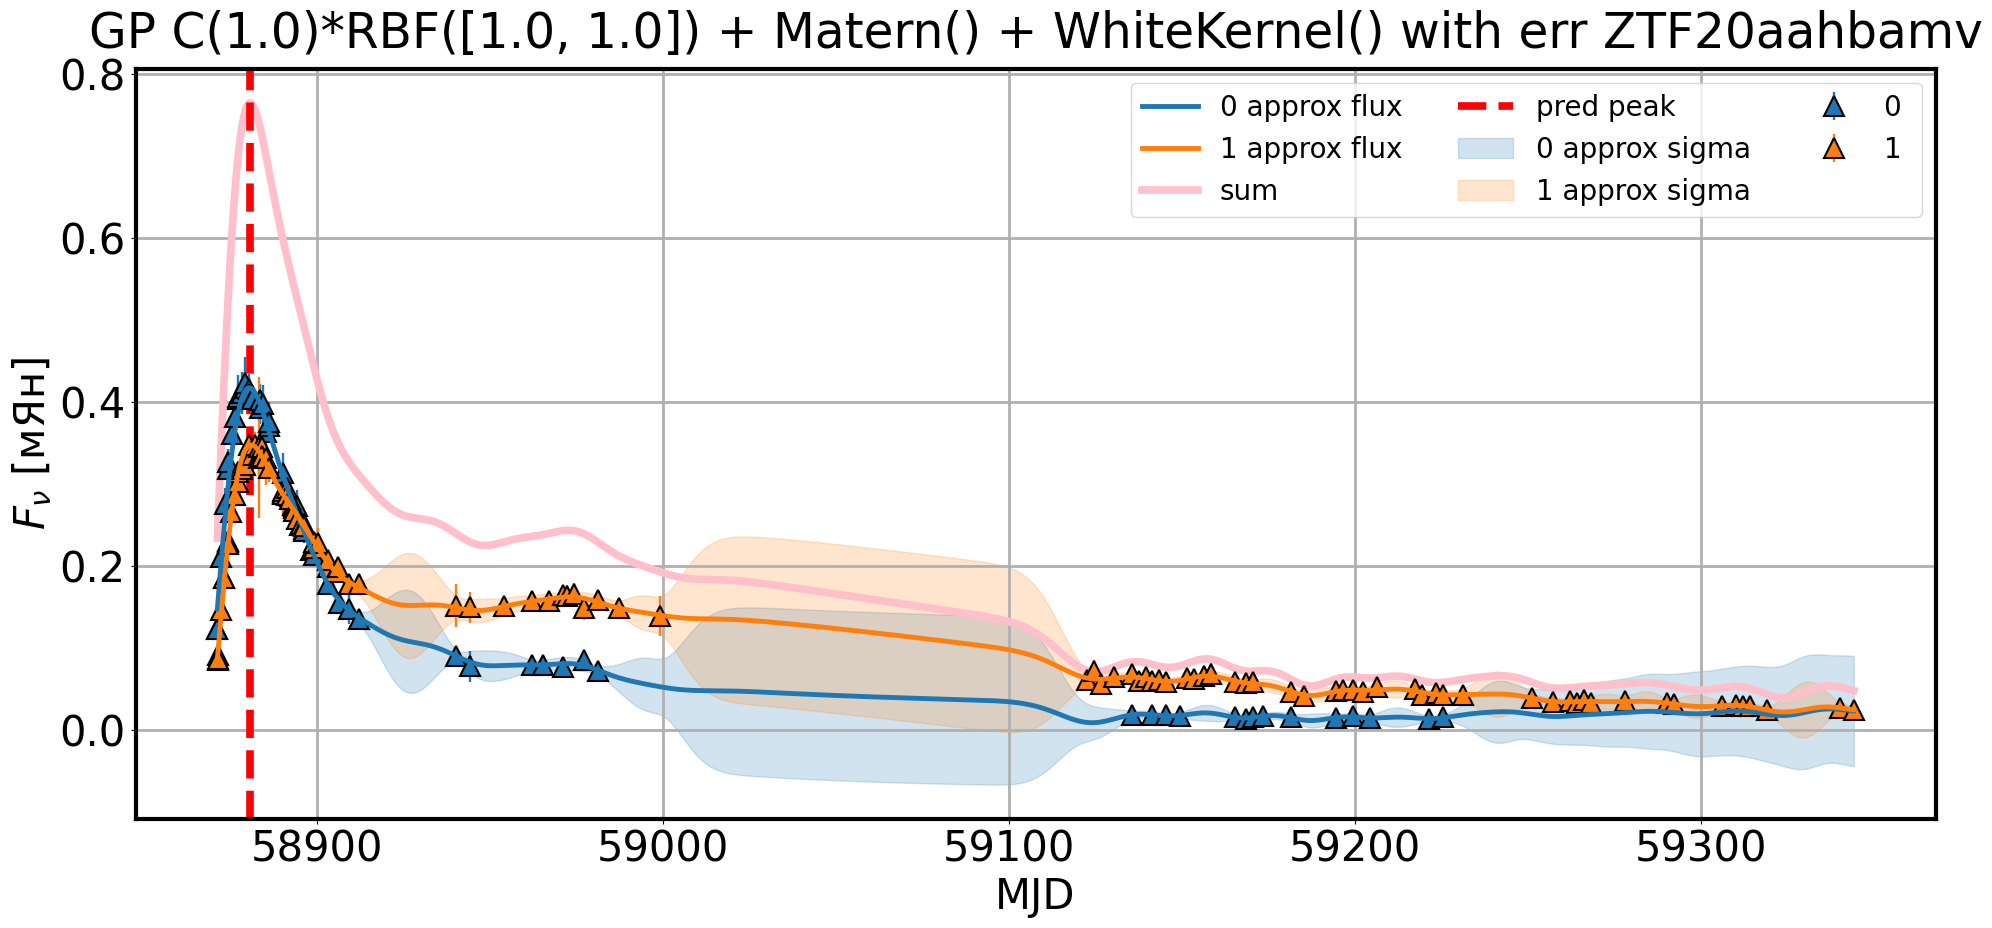

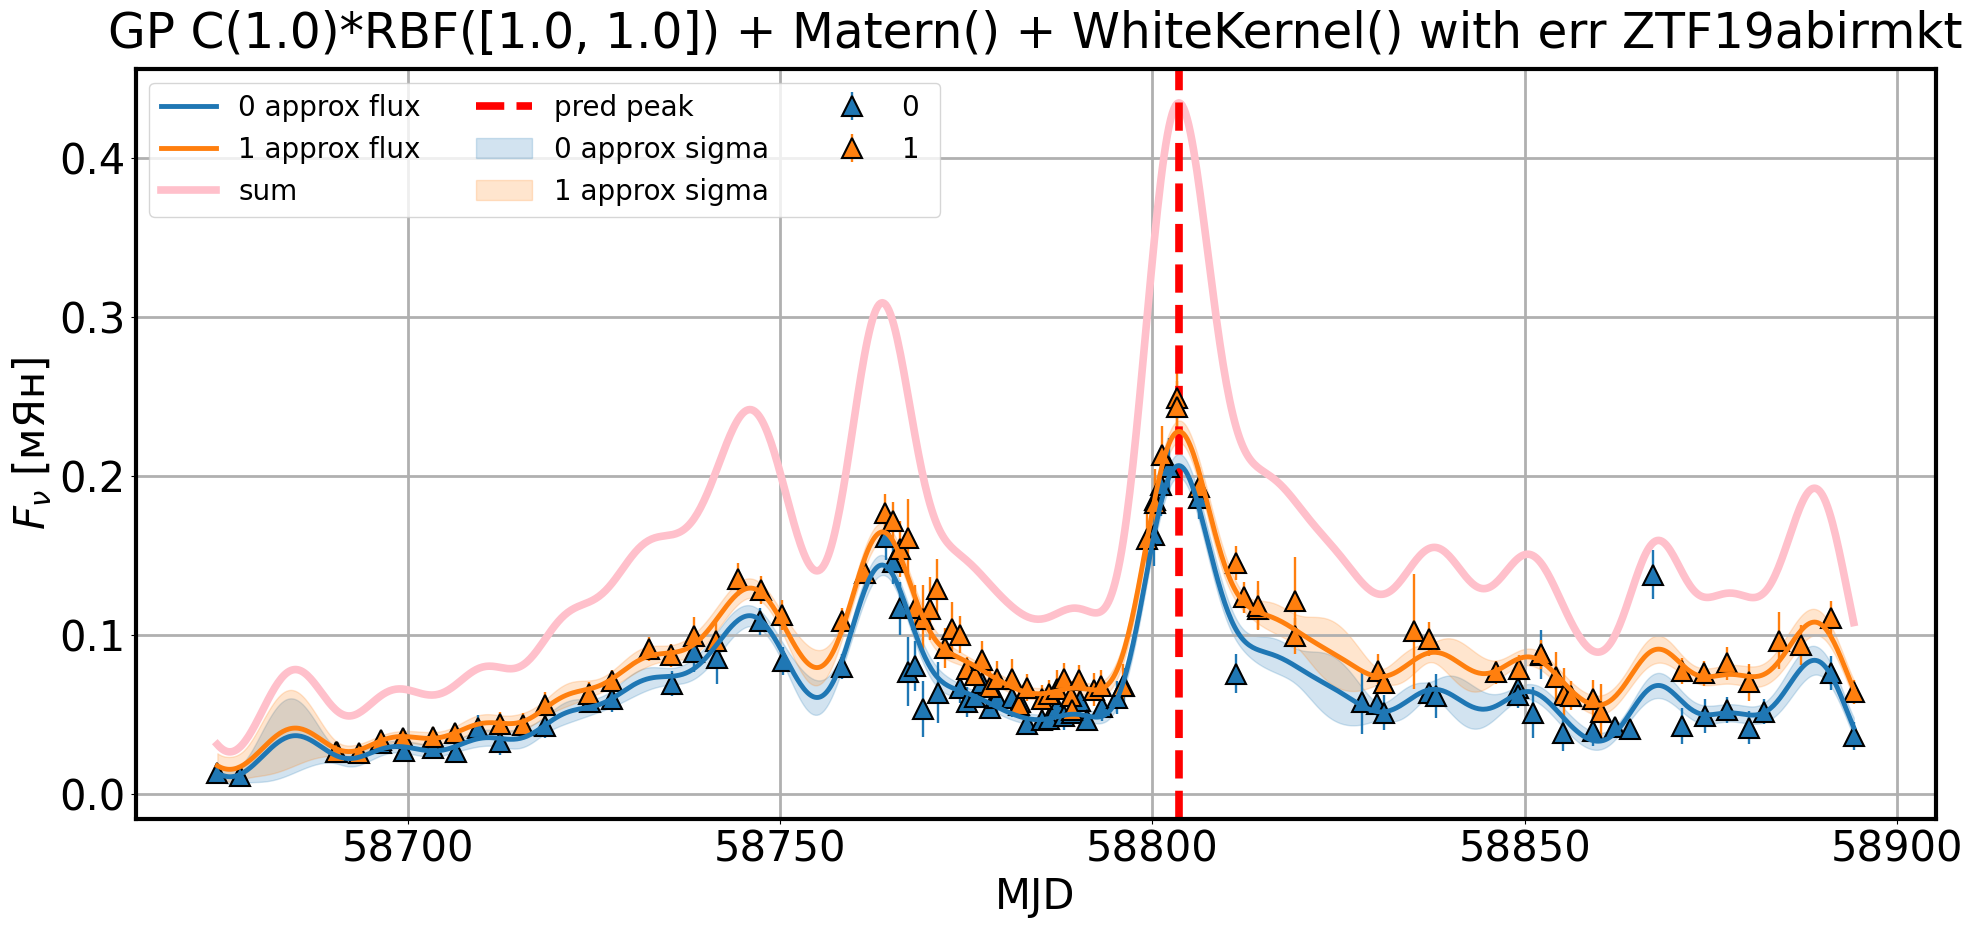

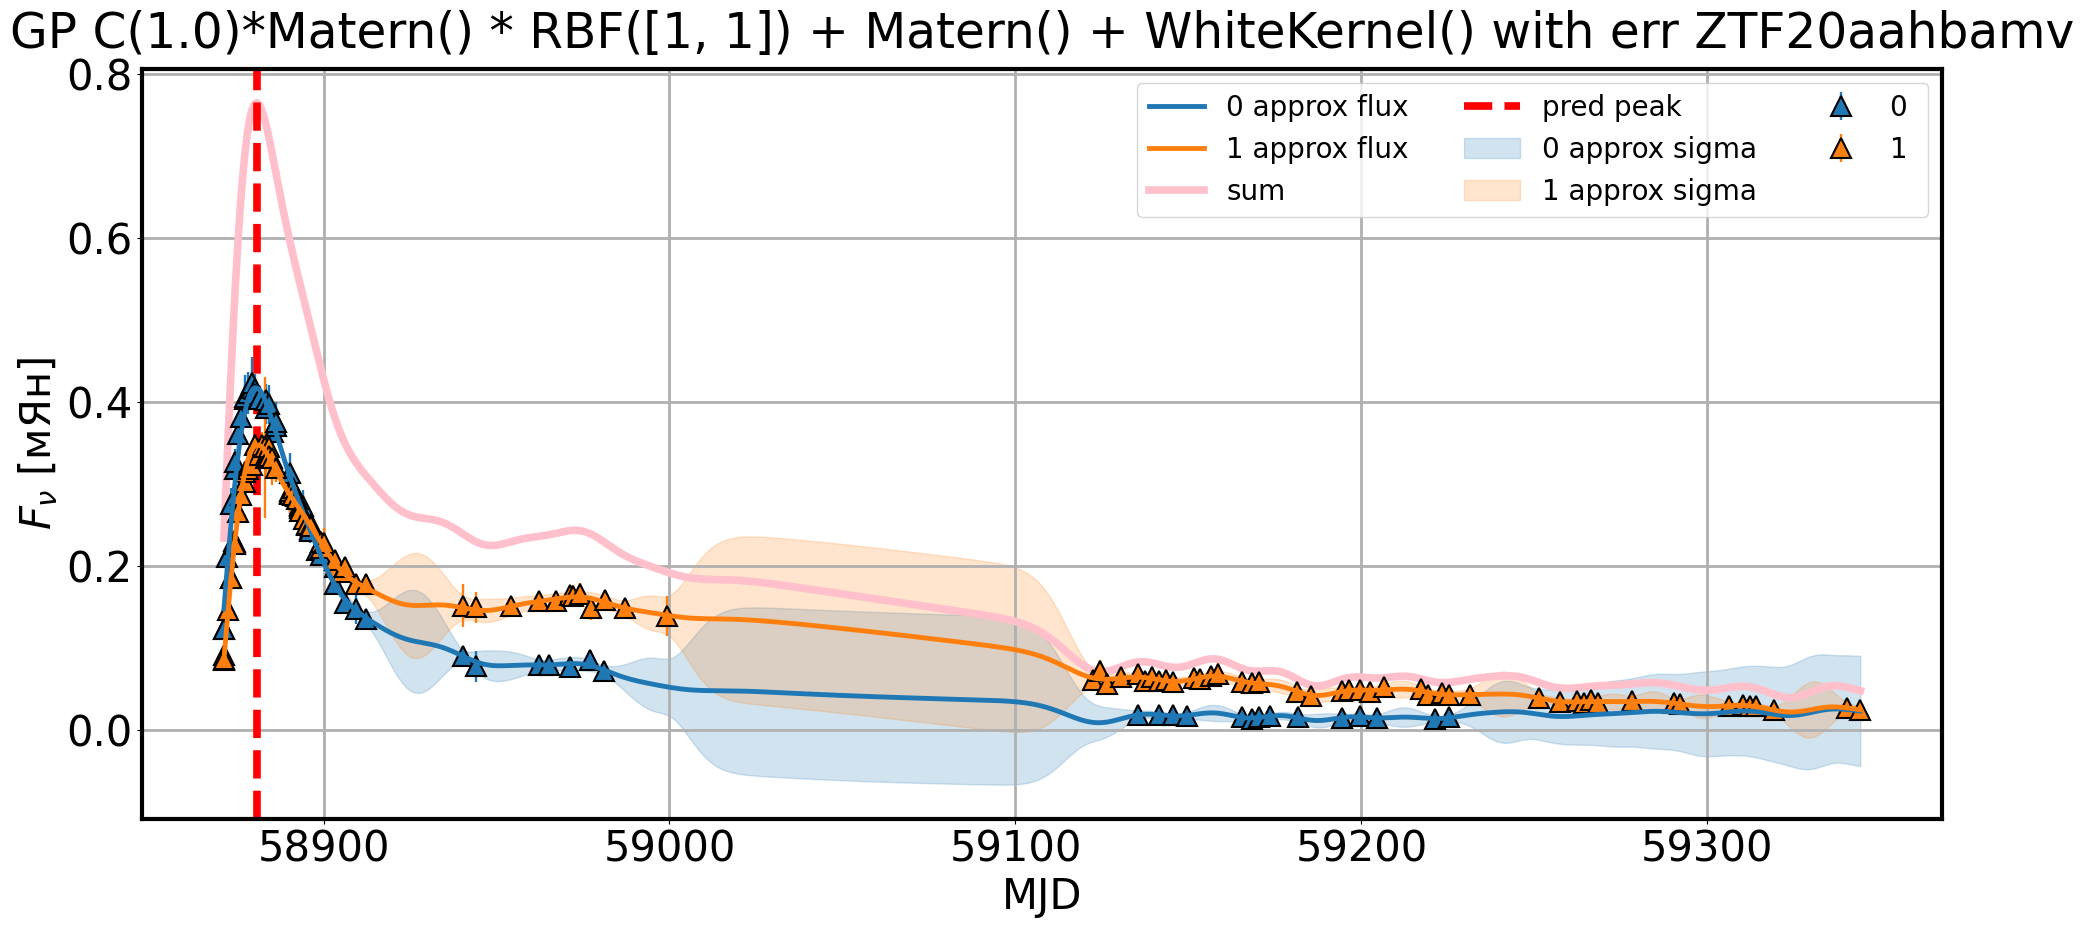

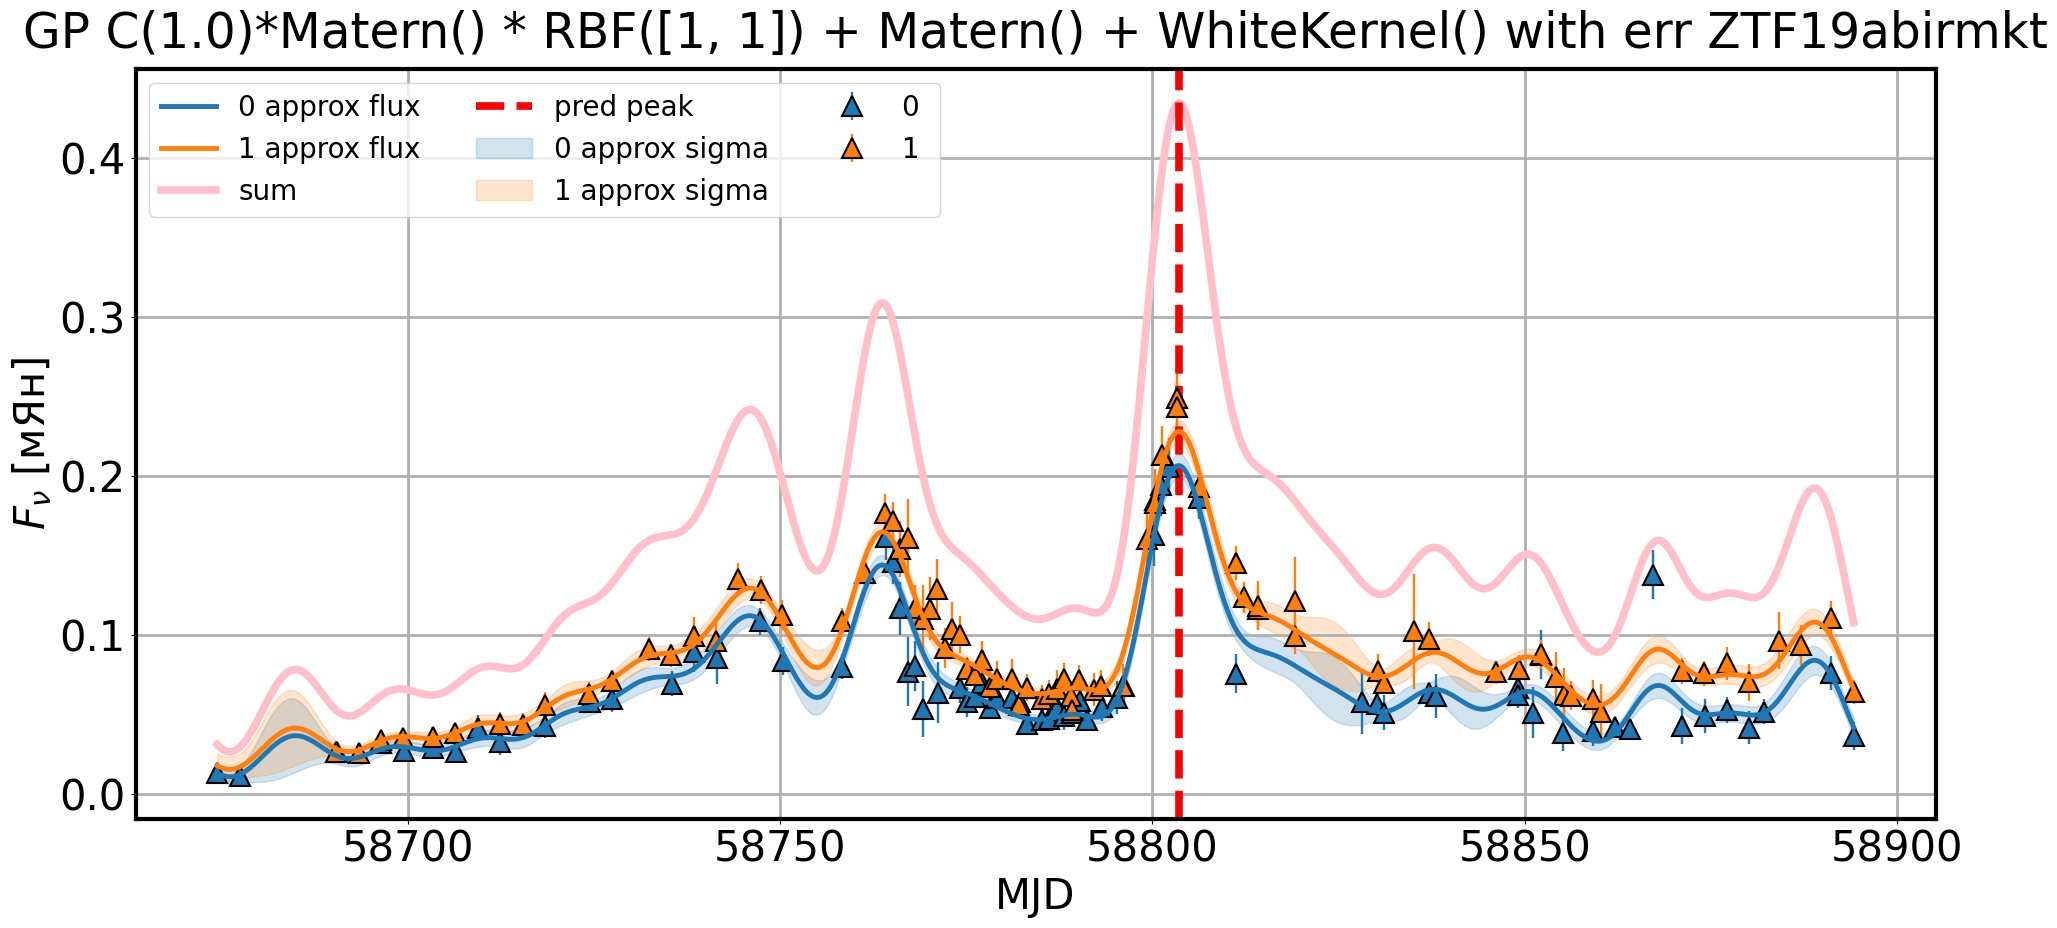

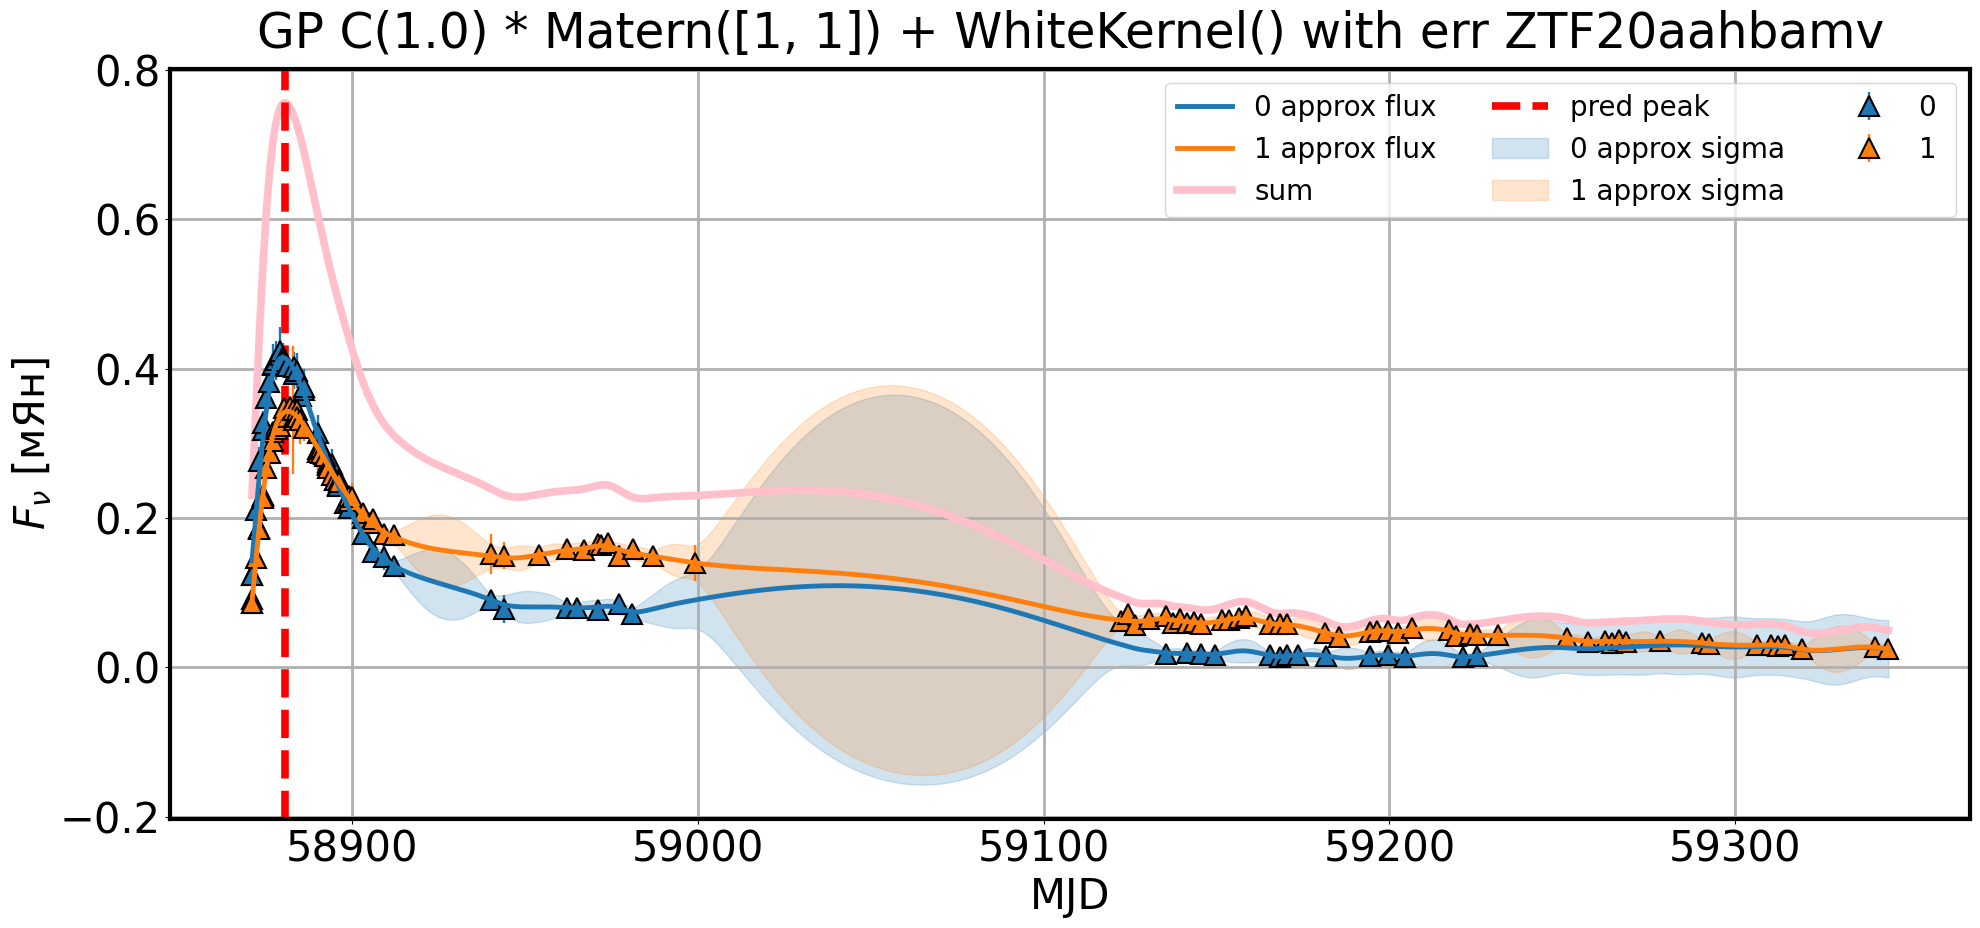

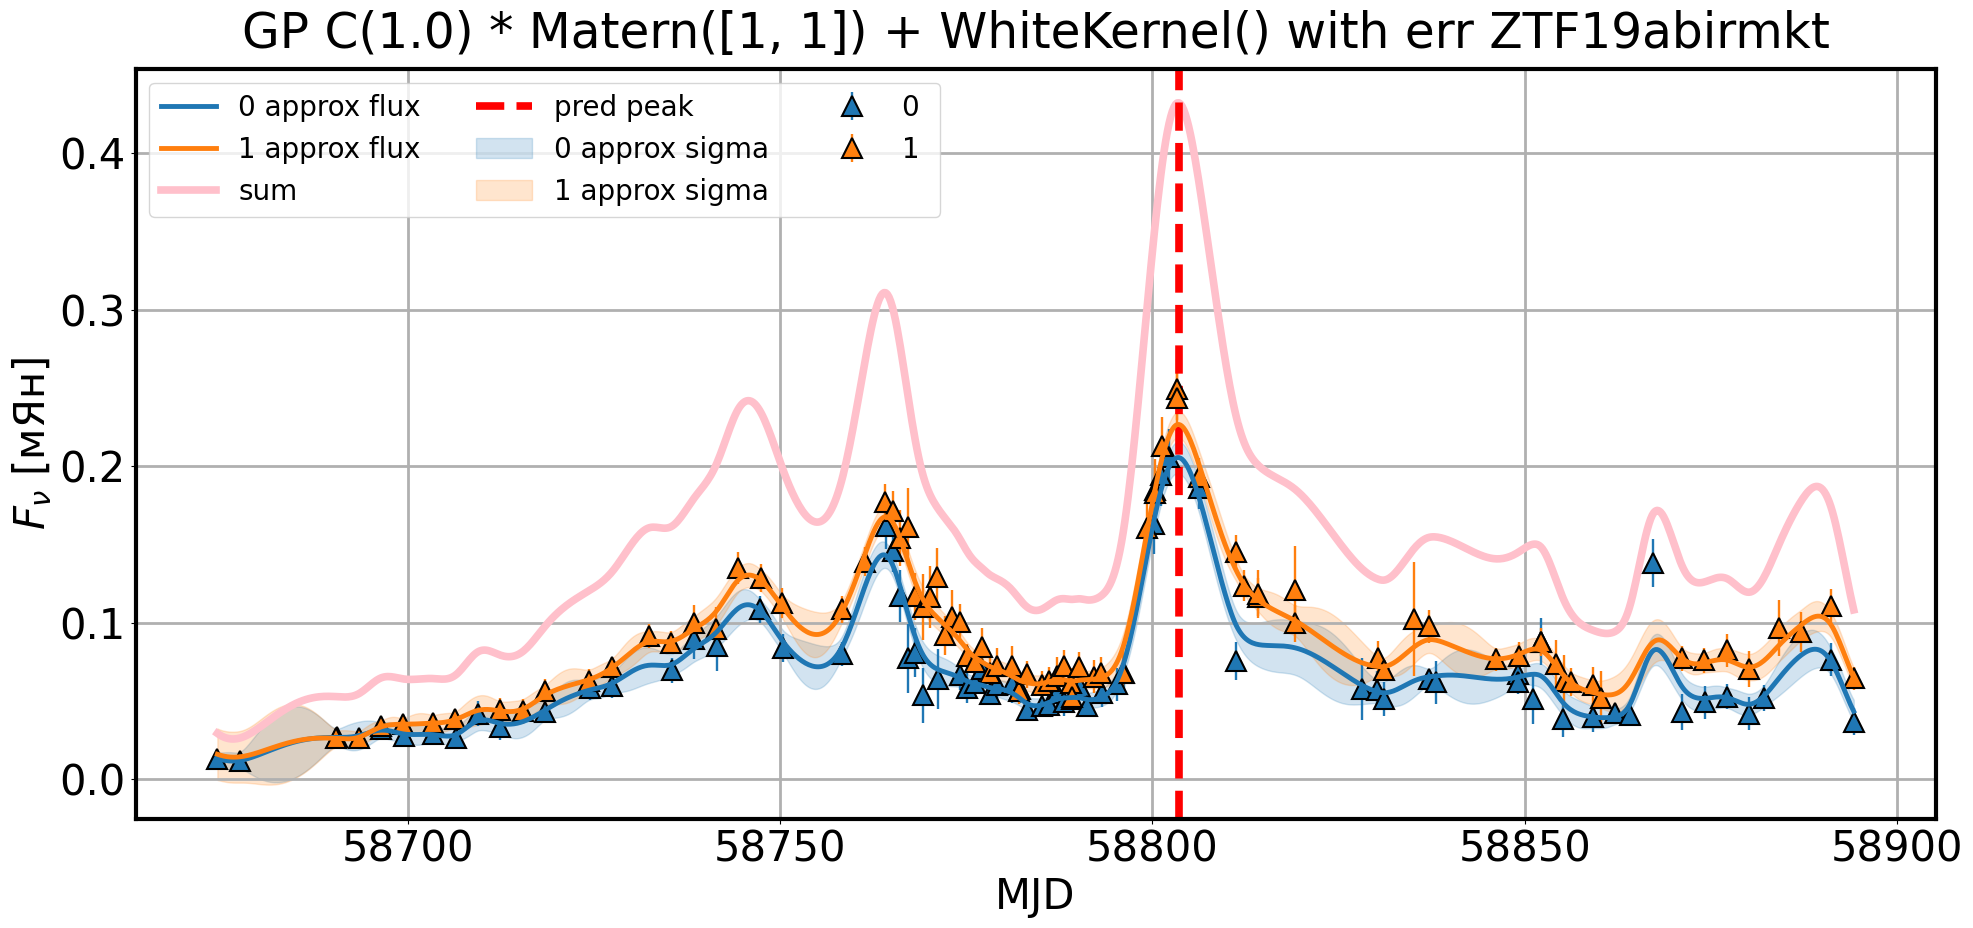

In [15]:
cool_objects = ['ZTF20aahbamv', 'ZTF19abirmkt']
model_names = ['NN (sklearn)',
               'BNN',
               'NN (pytorch)',
               'NF',
               'GP',
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()',
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()',
               'GP C(1.0) * Matern([1, 1]) + WhiteKernel()',
               'GP with err',
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel() with err',
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err',
               'GP C(1.0) * Matern([1, 1]) + WhiteKernel() with err'
              ]

import matplotlib.pyplot as plt




for model_name in model_names:
    print(model_name)
    for obj_name in cool_objects:
        print(obj_name)
        anobject = get_object(df_all, obj_name)
        t = anobject['mjd'].values 
        model = models_dict_all[model_name]
        model.fit(anobject['mjd'].values, anobject['flux'].values,
                  anobject['flux_err'].values, anobject['passband'].values)

        t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(t.min(),t.max())
        fig = plt.figure(figsize=(20, 10), dpi=100)
        plt.rcParams.update({"font.size": 30})
        fig.subplots_adjust(left=0.08, right=0.98, top=0.90, bottom=0.15)
        ax = plt.subplot(1, 1, 1)
        ax.spines["bottom"].set_linewidth(3)
        ax.spines["top"].set_linewidth(3)
        ax.spines["left"].set_linewidth(3)
        ax.spines["right"].set_linewidth(3)
        ax.set_xlabel("MJD", size=30)
        ax.set_ylabel(r"$F_{\nu}$ [мЯн]", size=30)
        ax.grid(linewidth=2)
        model.plot(ax = ax, plot_peak=True, title="{} {}".format(model_name, obj_name), save="{}_{}_peak.pdf".format(model_name, obj_name))
#     flux_test_pred, flux_err_test_pred =\
#     model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

    

# ZTF17aaazdba - TDE

Your graph was saved into GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err_ZTF17aaazdba_peak.pdf


<AxesSubplot:title={'center':'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err ZTF17aaazdba'}, xlabel='MJD', ylabel='$F_{\\nu}$ [мЯн]'>

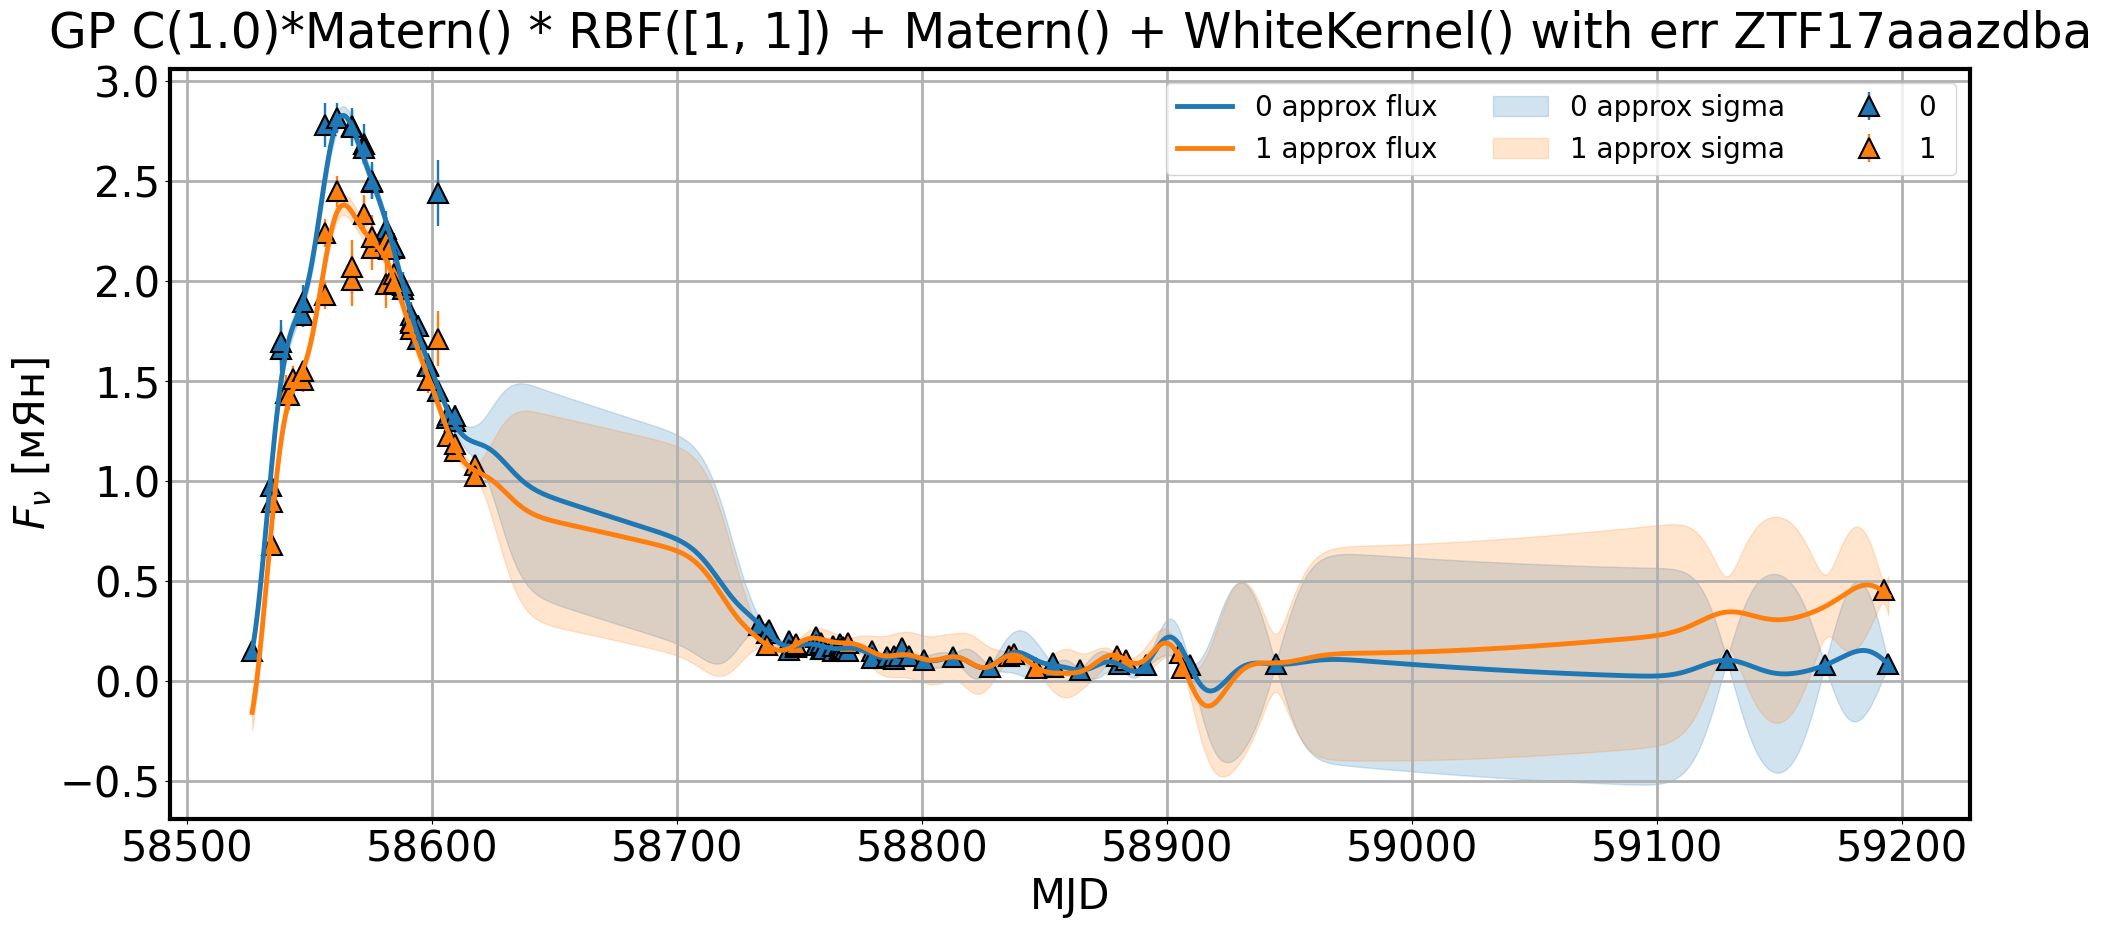

In [39]:
anobject = get_object(df_all, 'ZTF17aaazdba')
t = anobject['mjd'].values 
model_name = 'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err'#'NN (sklearn)'
model = models_dict_all[model_name]
model.fit(anobject['mjd'].values, anobject['flux'].values,
      anobject['flux_err'].values, anobject['passband'].values)

t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(t.min(),t.max())
fig = plt.figure(figsize=(20, 10), dpi=100)
plt.rcParams.update({"font.size": 30})
fig.subplots_adjust(left=0.08, right=0.98, top=0.90, bottom=0.15)
ax = plt.subplot(1, 1, 1)
ax.spines["bottom"].set_linewidth(3)
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.set_xlabel("MJD", size=30)
ax.set_ylabel(r"$F_{\nu}$ [мЯн]", size=30)
ax.grid(linewidth=2)
model.plot(ax = ax, title="{} {}".format(model_name, 'ZTF17aaazdba'), save="{}_{}_peak.pdf".format(model_name, 'ZTF17aaazdba'))

Your graph was saved into ZTF20aahbamv_19_06.pdf


<AxesSubplot:title={'center':'ZTF20aahbamv'}, xlabel='MJD', ylabel='$F_{\\nu}$ [мЯн]'>

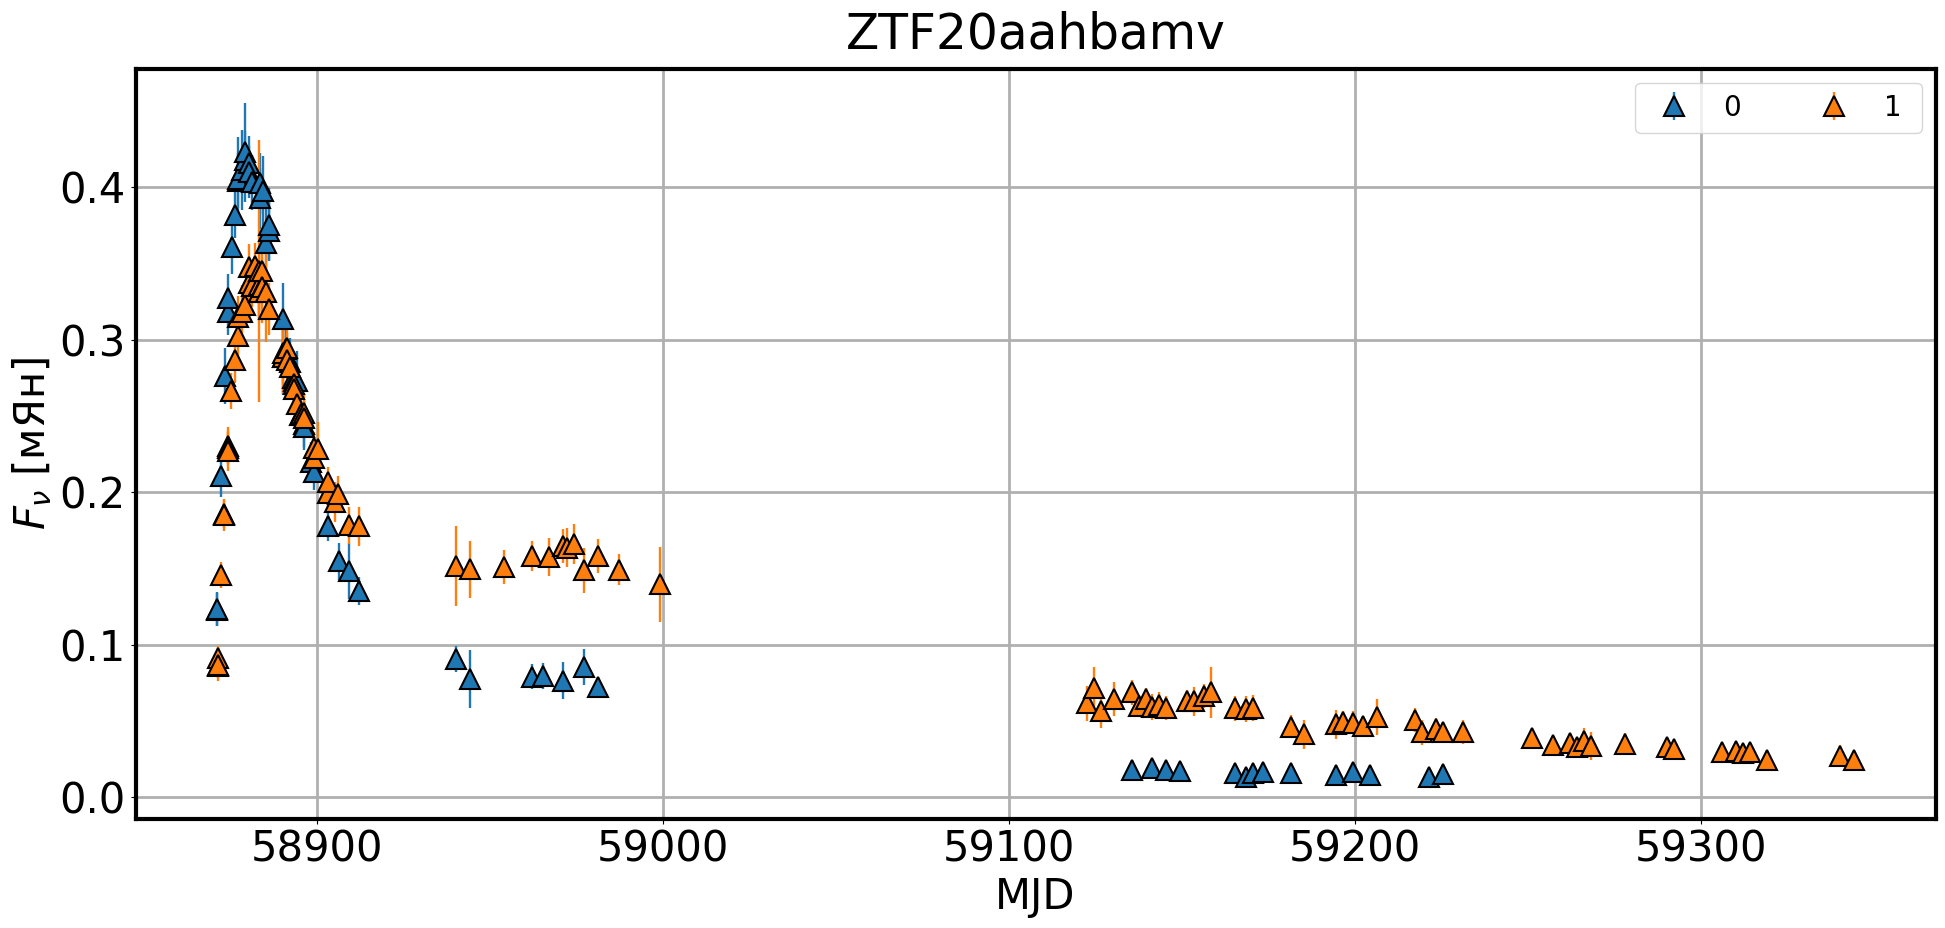

In [38]:
anobject = get_object(df_all, 'ZTF20aahbamv')
t = anobject['mjd'].values 
model_name = 'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err'
model = models_dict_all[model_name]
model.fit(anobject['mjd'].values, anobject['flux'].values,
      anobject['flux_err'].values, anobject['passband'].values)

t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(t.min(),t.max())
fig = plt.figure(figsize=(20, 10), dpi=100)
plt.rcParams.update({"font.size": 30})
fig.subplots_adjust(left=0.08, right=0.98, top=0.90, bottom=0.15)
ax = plt.subplot(1, 1, 1)
ax.spines["bottom"].set_linewidth(3)
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.set_xlabel("MJD", size=30)
ax.set_ylabel(r"$F_{\nu}$ [мЯн]", size=30)
ax.grid(linewidth=2)
model.plot(ax = ax, plot_approx= False, title="{}".format('ZTF20aahbamv'), save="{}_19_06.pdf".format('ZTF20aahbamv'))

In [28]:
model.plot(ax = ax, title="{} {}".format(model_name, 'ZTF17aadlxmv'), save="{}_{}.pdf".format(model_name, obj_name))

Your graph was saved into GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err_ZTF19abirmkt.pdf


<AxesSubplot:title={'center':'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel() with err ZTF17aadlxmv'}, xlabel='MJD', ylabel='$F_{\\nu}$ [мЯн]'>

<Figure size 432x288 with 0 Axes>

In [23]:
df_all['obj_type'].unique()

array(['SN Ia', 'SN II', 'SN IIn', 'SN Ia-91T', 'SN Ic', 'SN Ia-pec',
       'SN Ib', 'SN IIb', 'SN Ib-pec', 'SN Ic-BL', 'TDE', 'SN Ib/c',
       'SLSN-I', 'SN Iax', 'SN IIP', 'LBV', 'SN II-pec', 'SLSN-II',
       'nova', 'SN Ibn', 'ILRT', 'other', 'SN Ia-91bg', 'SN Ia-CSM'],
      dtype=object)